# Step 0.0. Install LightAutoML

# Step 0.1. Import necessary libraries 

In [124]:
%matplotlib inline

# Standard python libraries
import os
import time
import re

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, recall_score
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import multiprocess
from multiprocess import Pool
# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

from lightautoml.report.report_deco import ReportDeco
from scipy.signal import argrelmax,peak_prominences, find_peaks_cwt, peak_widths, peak_prominences, find_peaks

# Step 0.2. Parameters 

In [125]:
N_THREADS = 6 # threads cnt for lgbm and linear models
N_FOLDS = 6 # folds cnt for AutoML
RANDOM_STATE = 777 # fixed random state for various reasons
TEST_SIZE = 0.1 # Test size for metric check
TIMEOUT = 1800*3 # Time in seconds for automl run
TARGET = 'inf_rate'

# Step 0.3. Fix torch number of threads and numpy seed 

In [126]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Step 0.4. Data load 

In [142]:
%%time

train = pd.read_csv('covid_data_train.csv', sep=',', index_col=0)
train

Wall time: 17.5 ms


,lat,lng,name,population,district,subject,density,ivl_per_100k,ivl_number,ekmo_per_100k,...,epirank_avia,epirank_bus,epirank_train,epirank_avia_cat,epirank_bus_cat,epirank_train_cat,whole_population,urban,rural,has_metro
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,52.651055,90.101159,Абаза,17111.0,Сибирский,Хакасия,8.68,NaN,NaN,NaN,...,NaN,2.278095e-11,NaN,NaN,0.0,NaN,64241.0,44921.0,19320.0,0.0
1,53.720902,91.442435,Абакан,165183.0,Сибирский,Хакасия,8.68,NaN,NaN,NaN,...,0.000903,8.343086e-10,0.001383,0.0,1.0,0.0,64241.0,44921.0,19320.0,0.0
2,53.682800,53.655701,Абдулино,20663.0,Приволжский,Оренбургская область,15.95,27.7,542.0,0.05,...,NaN,5.164813e-14,0.000376,NaN,0.0,0.0,270081.0,156761.0,113320.0,0.0
3,44.864953,38.157819,Абинск,34926.0,Южный,Краснодарский край,73.73,17.6,1000.0,0.07,...,NaN,1.187676e-14,0.000186,NaN,0.0,0.0,847286.0,452437.0,394849.0,0.0
4,56.525460,52.997251,Агрыз,19299.0,Приволжский,Татарстан,57.27,28.2,1100.0,0.00,...,NaN,4.750316e-13,0.001003,NaN,0.0,0.0,527462.0,371965.0,155497.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,57.880402,43.807240,Макарьев,7114.0,Центральный,Костромская область,10.70,19.1,121.0,0.00,...,NaN,1.276106e-13,NaN,NaN,0.0,NaN,99956.0,68367.0,31589.0,0.0
447,55.208321,67.252739,Макушино,8337.0,Уральский,Курганская область,11.91,NaN,NaN,NaN,...,NaN,NaN,0.000050,NaN,NaN,0.0,138138.0,81631.0,56507.0,0.0
448,58.844215,32.218636,Малая Вишера,12461.0,Северо-Западный,Новгородская область,10.97,NaN,NaN,NaN,...,NaN,NaN,0.000679,NaN,NaN,0.0,103185.0,66160.0,37025.0,0.0


In [143]:
train.columns.to_list()

['lat',
 'lng',
 'name',
 'population',
 'district',
 'subject',
 'density',
 'ivl_per_100k',
 'ivl_number',
 'ekmo_per_100k',
 'ekmo_number',
 'life_quality_place_rating',
 'ecology',
 'cleanness',
 'public_services',
 'neighbourhood',
 'children_places',
 'sport_and_outdoor',
 'shops_and_malls',
 'public_transport',
 'security',
 'life_costs',
 'inf_rate',
 'avg_temp_min',
 'avg_temp_max',
 'avg_temp_std',
 'avg_temp_median',
 'humidity_min',
 'humidity_max',
 'humidity_std',
 'humidity_median',
 'pressure_min',
 'pressure_max',
 'pressure_std',
 'pressure_median',
 'wind_speed_ms_min',
 'wind_speed_ms_max',
 'wind_speed_ms_std',
 'wind_speed_ms_median',
 'region_x',
 'urban_50-54_years',
 'urban_55-59_years',
 'urban_60-64_years',
 'urban_65-69_years',
 'urban_70-74_years',
 'urban_75-79_years',
 'urban_80-84_years',
 'urban_85-89_years',
 'urban_90-94_years',
 'rural_50-54_years',
 'rural_55-59_years',
 'rural_60-64_years',
 'rural_65-69_years',
 'rural_70-74_years',
 'rural_75-79_

<AxesSubplot:>

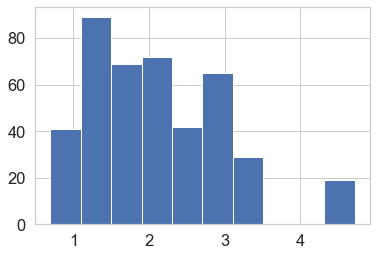

In [144]:
train[TARGET].hist()

In [145]:
train.dropna(subset=[TARGET], inplace=True)
train[TARGET+'_bin'] = (train[TARGET]>2).astype(int)

In [146]:
VRP = pd.read_csv('vrp.csv', encoding='utf-8')
VRP = VRP.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
for col in VRP.columns[1:]:
    VRP[col] = VRP[col].apply(lambda x: float(x) if x != '…' else None)

In [147]:
count_APO = pd.read_excel('APO.xls', index_col=0)
count_BO = pd.read_excel('Chislo_bolnich_organiz.xls', index_col=0)
count_APO.rename(columns={x:f'count_APO_{x}' for x in count_APO.columns}, inplace= True)
count_BO.rename(columns = {x:f'count_BO_{x}' for x in count_BO.columns}, inplace=True)
count_BO.reset_index(inplace=True)
count_APO.reset_index(inplace=True)

In [148]:
power = pd.read_excel('Мощность.xls', index_col=0)
kadr = pd.read_excel('Kadr.xls', index_col=0)
count_oper = pd.read_excel('Chislo_operac.xls', index_col=0)
power.rename(columns={x:f'power_{x}' for x in power.columns}, inplace= True)
kadr.rename(columns={x:f'kadr_{x}' for x in kadr.columns}, inplace= True)
count_oper.rename(columns = {x:f'count_oper_{x}' for x in count_oper.columns}, inplace=True)
power.reset_index(inplace=True)
kadr.reset_index(inplace=True)
count_oper.reset_index(inplace=True)

In [149]:
train = pd.merge(train, VRP, how='left', on='subject')
train = pd.merge(train, count_APO, how='left', on='subject')
train = pd.merge(train, count_BO, how='left', on='subject')
train = pd.merge(train, power, how='left', on='subject')
train = pd.merge(train, kadr, how='left', on='subject')
train = pd.merge(train, count_oper, how='left', on='subject')

In [150]:
dop1 = pd.read_excel('Затраты на терапию СЗЗ.xlsx')
dop2 = pd.read_excel('Базовые показатели эффективности региональных систем здравоохранения.xlsx')
dop3 = pd.read_excel('Базовые показатели эффективности региональных систем здравоохранения2.xlsx')
dop4 = pd.read_excel('Рейтинг регионов по базовым показателям эффективности систем.xlsx')
dop5 = pd.read_excel('Рейтинг регионов по удельным затратам на терапию ключевых социально значимых заболеваний.xlsx')
# dop1 = dop1.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# dop2 = dop2.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# dop3 = dop3.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# dop4 = dop4.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# dop5 = dop5.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
def tofloat(x):
    try:
        x = float(x)
        return x
    except:
        return None
for col in dop1.columns[1:]:
    dop1[col] = dop1[col].apply(tofloat)
for col in dop2.columns[1:]:
    dop2[col] = dop2[col].apply(tofloat)
for col in dop3.columns[1:]:
    dop3[col] = dop3[col].apply(tofloat)
for col in dop4.columns[1:]:
    dop4[col] = dop4[col].apply(tofloat)
for col in dop5.columns[1:]:
    dop5[col] = dop5[col].apply(tofloat)

In [151]:
train = pd.merge(train, dop1, how='left', on='subject')
train = pd.merge(train, dop2, how='left', on='subject')
train = pd.merge(train, dop3, how='left', on='subject')
train = pd.merge(train, dop4, how='left', on='subject')
train = pd.merge(train, dop5, how='left', on='subject')

In [152]:
train

,lat,lng,name,population,district,subject,density,ivl_per_100k,ivl_number,ekmo_per_100k,...,Ранг общей первичной заболева- емости,Итоговый ранг\nпо ком- плексу показате- лей ЗО,Итоговый рейтинг по показателям ЗО,Ранг по ГП Здра- воохранение,Ранг обеспеченно- сти МО,Ранг первичной заболеваемости,Итоговый рейтинг по затратам\nна СЗЗ,Ранг по затратам на ЗНО,Ранг по затратам на терапию ВИЧ,Ранг по затратам на терапию СД
0,52.651055,90.101159,Абаза,17111.0,Сибирский,Хакасия,8.68,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53.720902,91.442435,Абакан,165183.0,Сибирский,Хакасия,8.68,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,53.682800,53.655701,Абдулино,20663.0,Приволжский,Оренбургская область,15.95,27.7,542.0,0.05,...,50.0,64.0,64.0,67.0,38.0,50.0,21.0,27.0,38.0,29.0
3,44.864953,38.157819,Абинск,34926.0,Южный,Краснодарский край,73.73,17.6,1000.0,0.07,...,20.0,30.0,30.0,10.0,78.0,20.0,38.0,54.0,40.0,30.0
4,56.525460,52.997251,Агрыз,19299.0,Приволжский,Татарстан,57.27,28.2,1100.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,57.880402,43.807240,Макарьев,7114.0,Центральный,Костромская область,10.70,19.1,121.0,0.00,...,40.0,54.0,54.0,70.0,31.0,40.0,55.0,46.0,60.0,40.0
422,55.208321,67.252739,Макушино,8337.0,Уральский,Курганская область,11.91,NaN,NaN,NaN,...,72.0,83.0,83.0,76.0,54.0,72.0,34.0,39.0,63.0,14.0
423,58.844215,32.218636,Малая Вишера,12461.0,Северо-Западный,Новгородская область,10.97,NaN,NaN,NaN,...,54.0,75.0,NaN,NaN,NaN,NaN,70.0,81.0,57.0,41.0
424,52.399578,36.504021,Малоархангельск,3872.0,Центральный,Орловская область,30.25,21.8,160.0,0.00,...,78.0,72.0,72.0,72.0,20.0,78.0,30.0,30.0,46.0,32.0


# Step 0.5. Add new features

# Step 0.6. Data splitting for train-test 

In [153]:
tr_data, te_data = train_test_split(train, 
                                     test_size=TEST_SIZE,
#                                     shuffle=False,
                                        stratify=train[TARGET],
                                     random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(tr_data.shape, te_data.shape))

Data splitted. Parts sizes: tr_data = (383, 360), te_data = (43, 360)


# ========= AutoML preset usage =========


## Step 1. Create Task

In [154]:
%%time


task = Task('reg', loss='mae')

[08:36:16] sklearn doesn't support in general case mae and will not be used.
Wall time: 1.5 ms


## Step 2. Setup columns roles

In [155]:
%%time

roles = {
    'target': TARGET,
    'drop': ['infected_3003',
             'died_3003',
             'recovered_3003',
             'sick_3003',
             'infected_1503',
             'died_1503',
             'recovered_1503',
             'sick_1503',
            TARGET+'_bin']
}

Wall time: 0 ns


## Step 3. Create AutoML from preset and train on 80% of data

In [156]:
automl = TabularAutoML(task = task, 
                   timeout = TIMEOUT,
                   cpu_limit = N_THREADS,
                 general_params = {'use_algos': [['lgb','linear_l2','lgb_tuned']]},
                   reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                    )
report_automl = ReportDeco(output_path='report_blackbox', report_file_name='report.html')(automl)
report_automl.fit_predict(tr_data, roles = roles, verbose = 3)
report_automl.predict(te_data)

[08:36:17] Stdout logging level is INFO3.
[08:36:17] Task: reg

[08:36:17] Start automl preset with listed constraints:
[08:36:17] - time: 5400.00 seconds
[08:36:17] - CPU: 6 cores
[08:36:17] - memory: 16 GB

[08:36:17] Train data shape: (383, 360)

[08:36:23] Feats was rejected during automatic roles guess: []
[08:36:24] Layer 1 train process start. Time left 5393.71 secs
[08:36:25] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[08:36:25] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[08:36:25] Linear model: C = 1e-05 score = -0.28415322285055805
[08:36:26] Linear model: C = 5e-05 score = -0.1630196397173861
[08:36:26] Linear model: C = 0.0001 score = -0.1309171364603738
[08:36:26] Linear model: C = 0.0005 score = -0.0753923068963003
[08:36:27] Linear model: C = 0.001 score = -0.06655105980268904
[08:36:27] Linear model: C = 0.005 score = -0.05313829301714998
[08:36:28] Linear model: C = 0.01 score = -0.0504207657630618
[08:36:28] Linear model: C = 0.05 score =

[08:36:54] [1700]	valid's l2: 0.0545801
[08:36:54] [1800]	valid's l2: 0.0539711
[08:36:54] [1900]	valid's l2: 0.0533949
[08:36:55] [2000]	valid's l2: 0.0529421
[08:36:55] [2100]	valid's l2: 0.0524037
[08:36:55] [2200]	valid's l2: 0.0520095
[08:36:55] [2300]	valid's l2: 0.0517354
[08:36:55] [2400]	valid's l2: 0.0513121
[08:36:55] [2500]	valid's l2: 0.0508311
[08:36:56] [2600]	valid's l2: 0.0501806
[08:36:56] [2700]	valid's l2: 0.0499805
[08:36:56] [2800]	valid's l2: 0.0495866
[08:36:56] [2900]	valid's l2: 0.0491534
[08:36:56] [3000]	valid's l2: 0.0489689
[08:36:56] Selector_LightGBM fitting and predicting completed
[08:36:58] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[08:36:58] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[08:36:58] [1]	valid's l2: 0.728471
[08:36:58] Training until validation scores don't improve for 200 rounds
[08:36:58] [100]	valid's l2: 0.312115
[08:36:59] [200]	valid's l2: 0.187765
[08:36:59] [300]	valid's l2: 0.145173
[08:36:59] [400]	

[08:37:46] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.04350686828936342
[08:37:46] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[08:37:46] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[08:37:47] [1]	valid's l2: 0.728999
[08:37:47] Training until validation scores don't improve for 200 rounds
[08:37:47] [100]	valid's l2: 0.29331
[08:37:47] [200]	valid's l2: 0.17296
[08:37:47] [300]	valid's l2: 0.118539
[08:37:47] [400]	valid's l2: 0.0968647
[08:37:48] [500]	valid's l2: 0.0865377
[08:37:48] [600]	valid's l2: 0.0754569
[08:37:48] [700]	valid's l2: 0.0669923
[08:37:48] [800]	valid's l2: 0.0613986
[08:37:49] [900]	valid's l2: 0.0580492
[08:37:49] [1000]	valid's l2: 0.056233
[08:37:49] [1100]	valid's l2: 0.0549782
[08:37:49] [1200]	valid's l2: 0.0541171
[08:37:50] [1300]	valid's l2: 0.0533123
[08:37:50] [1400]	valid's l2: 0.0527539
[08:37:50] [1500]	valid's l2: 0.0520556
[08:37:50] [1600]	valid's l2: 0.0

[08:38:18] [1]	valid's l2: 0.728795
[08:38:18] Training until validation scores don't improve for 200 rounds
[08:38:18] [100]	valid's l2: 0.357003
[08:38:18] [200]	valid's l2: 0.224802
[08:38:18] [300]	valid's l2: 0.172872
[08:38:18] [400]	valid's l2: 0.150975
[08:38:19] [500]	valid's l2: 0.135098
[08:38:19] [600]	valid's l2: 0.126377
[08:38:19] [700]	valid's l2: 0.12211
[08:38:19] [800]	valid's l2: 0.110739
[08:38:19] [900]	valid's l2: 0.0944861
[08:38:19] [1000]	valid's l2: 0.0827257
[08:38:19] [1100]	valid's l2: 0.076065
[08:38:20] [1200]	valid's l2: 0.0727003
[08:38:20] [1300]	valid's l2: 0.0687496
[08:38:20] [1400]	valid's l2: 0.0669599
[08:38:20] [1500]	valid's l2: 0.0653746
[08:38:20] [1600]	valid's l2: 0.0637125
[08:38:20] [1700]	valid's l2: 0.0622409
[08:38:20] [1800]	valid's l2: 0.0612217
[08:38:21] [1900]	valid's l2: 0.0600949
[08:38:21] [2000]	valid's l2: 0.0578015
[08:38:21] [2100]	valid's l2: 0.0558888
[08:38:21] [2200]	valid's l2: 0.0550303
[08:38:21] [2300]	valid's l2: 

[08:38:46] [2500]	valid's l2: 0.0514173
[08:38:47] [2600]	valid's l2: 0.0513566
[08:38:47] [2700]	valid's l2: 0.0511159
[08:38:47] [2800]	valid's l2: 0.0508681
[08:38:47] [2900]	valid's l2: 0.0506884
[08:38:48] [3000]	valid's l2: 0.0501936
[08:38:48] Trial 11 with hyperparameters {'feature_fraction': 0.9725682721151934, 'num_leaves': 126, 'bagging_fraction': 0.7149885992524333, 'min_sum_hessian_in_leaf': 0.0011799062523159302, 'reg_alpha': 0.00240397308660953, 'reg_lambda': 0.016301353379407572} scored -0.05019362970713774 in 0:00:07.508994
[08:38:48] [1]	valid's l2: 0.728951
[08:38:48] Training until validation scores don't improve for 200 rounds
[08:38:48] [100]	valid's l2: 0.294472
[08:38:48] [200]	valid's l2: 0.165819
[08:38:48] [300]	valid's l2: 0.113486
[08:38:49] [400]	valid's l2: 0.0879915
[08:38:49] [500]	valid's l2: 0.0780259
[08:38:49] [600]	valid's l2: 0.068205
[08:38:49] [700]	valid's l2: 0.0596379
[08:38:50] [800]	valid's l2: 0.0549466
[08:38:50] [900]	valid's l2: 0.05202

[08:39:27] [2900]	valid's l2: 0.0403804
[08:39:27] [3000]	valid's l2: 0.0403121
[08:39:27] Trial 16 with hyperparameters {'feature_fraction': 0.593638853783253, 'num_leaves': 168, 'bagging_fraction': 0.9196629644604997, 'min_sum_hessian_in_leaf': 0.020809282168644038, 'reg_alpha': 0.15203858593612127, 'reg_lambda': 1.4864763723935082e-08} scored -0.040309039917708366 in 0:00:07.892499
[08:39:28] [1]	valid's l2: 0.728771
[08:39:28] Training until validation scores don't improve for 200 rounds
[08:39:28] [100]	valid's l2: 0.314981
[08:39:28] [200]	valid's l2: 0.181761
[08:39:28] [300]	valid's l2: 0.134877
[08:39:28] [400]	valid's l2: 0.100319
[08:39:29] [500]	valid's l2: 0.0844645
[08:39:29] [600]	valid's l2: 0.076845
[08:39:29] [700]	valid's l2: 0.0684246
[08:39:29] [800]	valid's l2: 0.0624392
[08:39:29] [900]	valid's l2: 0.0584227
[08:39:30] [1000]	valid's l2: 0.0563424
[08:39:30] [1100]	valid's l2: 0.0536731
[08:39:30] [1200]	valid's l2: 0.0523661
[08:39:30] [1300]	valid's l2: 0.05141

[08:40:16] [1]	valid's l2: 0.729091
[08:40:16] Training until validation scores don't improve for 200 rounds
[08:40:16] [100]	valid's l2: 0.296672
[08:40:16] [200]	valid's l2: 0.171324
[08:40:17] [300]	valid's l2: 0.12736
[08:40:17] [400]	valid's l2: 0.0916648
[08:40:17] [500]	valid's l2: 0.0778176
[08:40:18] [600]	valid's l2: 0.0708606
[08:40:18] [700]	valid's l2: 0.0623024
[08:40:18] [800]	valid's l2: 0.0563836
[08:40:19] [900]	valid's l2: 0.0502973
[08:40:19] [1000]	valid's l2: 0.0454465
[08:40:19] [1100]	valid's l2: 0.0438441
[08:40:20] [1200]	valid's l2: 0.0431554
[08:40:20] [1300]	valid's l2: 0.0424593
[08:40:20] [1400]	valid's l2: 0.0419323
[08:40:21] [1500]	valid's l2: 0.0414552
[08:40:21] [1600]	valid's l2: 0.0411071
[08:40:22] [1700]	valid's l2: 0.0410254
[08:40:22] [1800]	valid's l2: 0.0407156
[08:40:22] [1900]	valid's l2: 0.0402491
[08:40:22] [2000]	valid's l2: 0.039998
[08:40:23] [2100]	valid's l2: 0.0397315
[08:40:23] [2200]	valid's l2: 0.03931
[08:40:23] [2300]	valid's l

[08:41:10] [300]	valid's l2: 0.135758
[08:41:11] [400]	valid's l2: 0.105313
[08:41:11] [500]	valid's l2: 0.0882937
[08:41:11] [600]	valid's l2: 0.0792339
[08:41:12] [700]	valid's l2: 0.0723658
[08:41:12] [800]	valid's l2: 0.066403
[08:41:12] [900]	valid's l2: 0.0616864
[08:41:12] [1000]	valid's l2: 0.0583726
[08:41:13] [1100]	valid's l2: 0.0559008
[08:41:13] [1200]	valid's l2: 0.0542016
[08:41:13] [1300]	valid's l2: 0.0530708
[08:41:13] [1400]	valid's l2: 0.0526254
[08:41:13] [1500]	valid's l2: 0.0522811
[08:41:14] [1600]	valid's l2: 0.0516175
[08:41:14] [1700]	valid's l2: 0.0510235
[08:41:14] [1800]	valid's l2: 0.0503131
[08:41:14] [1900]	valid's l2: 0.0498185
[08:41:15] [2000]	valid's l2: 0.0494485
[08:41:15] [2100]	valid's l2: 0.0488922
[08:41:15] [2200]	valid's l2: 0.0486788
[08:41:15] [2300]	valid's l2: 0.0484687
[08:41:16] [2400]	valid's l2: 0.0480949
[08:41:16] [2500]	valid's l2: 0.0478848
[08:41:16] [2600]	valid's l2: 0.0477712
[08:41:16] [2700]	valid's l2: 0.0474485
[08:41:17]

[08:41:55] [700]	valid's l2: 0.0605238
[08:41:55] [800]	valid's l2: 0.0554294
[08:41:56] [900]	valid's l2: 0.0532105
[08:41:56] [1000]	valid's l2: 0.0515737
[08:41:56] [1100]	valid's l2: 0.0507208
[08:41:56] [1200]	valid's l2: 0.0501707
[08:41:57] [1300]	valid's l2: 0.0492031
[08:41:57] [1400]	valid's l2: 0.0483204
[08:41:57] [1500]	valid's l2: 0.0476243
[08:41:57] [1600]	valid's l2: 0.0473387
[08:41:58] [1700]	valid's l2: 0.0471559
[08:41:58] [1800]	valid's l2: 0.0468696
[08:41:58] [1900]	valid's l2: 0.0462833
[08:41:58] [2000]	valid's l2: 0.0458653
[08:41:59] [2100]	valid's l2: 0.0454898
[08:41:59] [2200]	valid's l2: 0.0452987
[08:41:59] [2300]	valid's l2: 0.0450049
[08:41:59] [2400]	valid's l2: 0.0443078
[08:42:00] [2500]	valid's l2: 0.0434833
[08:42:00] [2600]	valid's l2: 0.0432546
[08:42:00] [2700]	valid's l2: 0.0431365
[08:42:01] [2800]	valid's l2: 0.0431446
[08:42:01] [2900]	valid's l2: 0.0428224
[08:42:01] [3000]	valid's l2: 0.0425006
[08:42:01] Trial 32 with hyperparameters {'

[08:42:40] [1100]	valid's l2: 0.0455751
[08:42:40] [1200]	valid's l2: 0.0448028
[08:42:40] [1300]	valid's l2: 0.0441089
[08:42:41] [1400]	valid's l2: 0.0434819
[08:42:41] [1500]	valid's l2: 0.0424268
[08:42:41] [1600]	valid's l2: 0.04193
[08:42:41] [1700]	valid's l2: 0.0417815
[08:42:42] [1800]	valid's l2: 0.041048
[08:42:42] [1900]	valid's l2: 0.040663
[08:42:43] [2000]	valid's l2: 0.040421
[08:42:43] [2100]	valid's l2: 0.0399308
[08:42:43] [2200]	valid's l2: 0.0395631
[08:42:44] [2300]	valid's l2: 0.039141
[08:42:44] [2400]	valid's l2: 0.0390784
[08:42:44] [2500]	valid's l2: 0.0390303
[08:42:45] [2600]	valid's l2: 0.0389215
[08:42:45] [2700]	valid's l2: 0.0387558
[08:42:46] [2800]	valid's l2: 0.038498
[08:42:46] [2900]	valid's l2: 0.0382122
[08:42:46] [3000]	valid's l2: 0.0381287
[08:42:46] Trial 37 with hyperparameters {'feature_fraction': 0.9559427774835808, 'num_leaves': 210, 'bagging_fraction': 0.9937790817461453, 'min_sum_hessian_in_leaf': 0.002181872584569734, 'reg_alpha': 0.00

[08:43:23] [1200]	valid's l2: 0.0220396
[08:43:23] [1300]	valid's l2: 0.0218568
[08:43:24] [1400]	valid's l2: 0.0215515
[08:43:24] [1500]	valid's l2: 0.0214295
[08:43:24] [1600]	valid's l2: 0.0213206
[08:43:24] [1700]	valid's l2: 0.0211819
[08:43:25] [1800]	valid's l2: 0.0206351
[08:43:25] [1900]	valid's l2: 0.0203358
[08:43:25] [2000]	valid's l2: 0.0200225
[08:43:25] [2100]	valid's l2: 0.0196918
[08:43:26] [2200]	valid's l2: 0.0195825
[08:43:26] [2300]	valid's l2: 0.019151
[08:43:26] [2400]	valid's l2: 0.0189534
[08:43:26] [2500]	valid's l2: 0.0188399
[08:43:27] [2600]	valid's l2: 0.018518
[08:43:27] [2700]	valid's l2: 0.018444
[08:43:27] [2800]	valid's l2: 0.0184108
[08:43:27] [2900]	valid's l2: 0.0183335
[08:43:28] [3000]	valid's l2: 0.018058
[08:43:28] ===== Start working with fold 5 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[08:43:28] [1]	valid's l2: 0.956743
[08:43:28] Training until validation scores don't improve for 100 rounds
[08:43:28] [100]	valid's l2: 0.0629385
[08:43:28

array([[1.3928791],
       [1.58425  ],
       [1.1264175],
       [2.318025 ],
       [0.8731087],
       [1.5656708],
       [2.0017967],
       [2.7288363],
       [1.5653286],
       [2.370759 ],
       [2.7218697],
       [3.2270982],
       [0.680717 ],
       [1.6656002],
       [1.6269507],
       [1.0844855],
       [2.0477104],
       [2.7275095],
       [4.712066 ],
       [1.8892493],
       [1.4680347],
       [2.1644652],
       [4.706759 ],
       [2.9226382],
       [1.0493946],
       [0.6870127],
       [1.069718 ],
       [2.1003447],
       [3.2274075],
       [1.3659493],
       [3.227592 ],
       [1.0659225],
       [1.0604634],
       [1.5620708],
       [2.4164097],
       [2.5762932],
       [2.412956 ],
       [1.3609402],
       [1.7841314],
       [2.1150744],
       [2.5769036],
       [1.0777545],
       [2.7143526]], dtype=float32)

In [26]:
automl = TabularUtilizedAutoML(task = task, 
                   timeout = TIMEOUT,
                   cpu_limit = N_THREADS,
                 general_params = {'use_algos': [['lgb','linear_l2','lgb_tuned']]},
                   reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                    )
automl.fit_predict(train, roles=roles, verbose=3)

[16:30:35] Start automl utilizator with listed constraints:
[16:30:35] - time: 5400.00 seconds
[16:30:35] - CPU: 6 cores
[16:30:35] - memory: 16 GB

[16:30:35] If one preset completes earlier, next preset configuration will be started

[16:30:35] ==================================================
[16:30:35] Start 0 automl preset configuration:
[16:30:35] D:\Ananconda3\envs\lama\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[16:30:35] Found reader_params in kwargs, need to combine
[16:30:35] Merged variant for reader_params = {'n_jobs': 6, 'cv': 6, 'random_state': 42}
[16:30:35] Found general_params in kwargs, need to combine
[16:30:35] Merged variant for general_params = {'use_algos': [['lgb', 'linear_l2', 'lgb_tuned']], 'return_all_predictions': False}
[16:30:35] Stdout logging level is INFO3.
[16:30:35] Task: reg

[16:30:35] Start automl pre

[16:31:00] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[16:31:00] [1]	valid's l2: 0.781323
[16:31:00] Training until validation scores don't improve for 200 rounds
[16:31:00] [100]	valid's l2: 0.355964
[16:31:00] [200]	valid's l2: 0.217328
[16:31:01] [300]	valid's l2: 0.160467
[16:31:01] [400]	valid's l2: 0.133093
[16:31:01] [500]	valid's l2: 0.0700443
[16:31:01] [600]	valid's l2: 0.0568408
[16:31:02] [700]	valid's l2: 0.05271
[16:31:02] [800]	valid's l2: 0.0475909
[16:31:02] [900]	valid's l2: 0.039692
[16:31:02] [1000]	valid's l2: 0.0344645
[16:31:03] [1100]	valid's l2: 0.0316219
[16:31:03] [1200]	valid's l2: 0.0302252
[16:31:03] [1300]	valid's l2: 0.0290598
[16:31:03] [1400]	valid's l2: 0.0283022
[16:31:04] [1500]	valid's l2: 0.0278422
[16:31:04] [1600]	valid's l2: 0.027409
[16:31:04] [1700]	valid's l2: 0.0271944
[16:31:04] [1800]	valid's l2: 0.0268769
[16:31:05] [1900]	valid's l2: 0.0261231
[16:31:05] [2000]	valid's l2: 0.0258782
[16:31:05] [2100]	valid's l

[16:31:43] [2300]	valid's l2: 0.0299581
[16:31:43] [2400]	valid's l2: 0.0297833
[16:31:43] [2500]	valid's l2: 0.0295991
[16:31:43] [2600]	valid's l2: 0.0293388
[16:31:44] [2700]	valid's l2: 0.0288452
[16:31:44] [2800]	valid's l2: 0.0284735
[16:31:44] [2900]	valid's l2: 0.0281974
[16:31:44] [3000]	valid's l2: 0.0280215
[16:31:45] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored -0.028021477237278086 in 0:00:06.700499
[16:31:45] [1]	valid's l2: 0.779599
[16:31:45] Training until validation scores don't improve for 200 rounds
[16:31:45] [100]	valid's l2: 0.362014
[16:31:45] [200]	valid's l2: 0.228717
[16:31:45] [300]	valid's l2: 0.163904
[16:31:45] [400]	valid's l2: 0.134991
[16:31:45] [500]	valid's l2: 0.0823566
[16:31:45] [600]	valid's l2: 0.0719137
[16:31:45] [700]	valid's l2: 0.

[16:32:10] [2800]	valid's l2: 0.052439
[16:32:10] [2900]	valid's l2: 0.0520743
[16:32:10] [3000]	valid's l2: 0.0519194
[16:32:10] Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored -0.05191943880334479 in 0:00:03.989498
[16:32:10] [1]	valid's l2: 0.779857
[16:32:10] Training until validation scores don't improve for 200 rounds
[16:32:10] [100]	valid's l2: 0.344109
[16:32:10] [200]	valid's l2: 0.202395
[16:32:10] [300]	valid's l2: 0.122862
[16:32:11] [400]	valid's l2: 0.0852654
[16:32:11] [500]	valid's l2: 0.0703179
[16:32:11] [600]	valid's l2: 0.0622657
[16:32:11] [700]	valid's l2: 0.0576994
[16:32:12] [800]	valid's l2: 0.0517587
[16:32:12] [900]	valid's l2: 0.048285
[16:32:12] [1000]	valid's l2: 0.0458785
[16:32:12] [1100]	valid's l2: 0.0433917
[16:32:12] [1200]	valid's l2: 0.041194
[16:32:1

[16:32:37] [1]	valid's l2: 0.780077
[16:32:37] Training until validation scores don't improve for 200 rounds
[16:32:38] [100]	valid's l2: 0.341861
[16:32:38] [200]	valid's l2: 0.195915
[16:32:38] [300]	valid's l2: 0.108598
[16:32:38] [400]	valid's l2: 0.066556
[16:32:39] [500]	valid's l2: 0.0558493
[16:32:39] [600]	valid's l2: 0.0495691
[16:32:39] [700]	valid's l2: 0.0455925
[16:32:39] [800]	valid's l2: 0.0419043
[16:32:40] [900]	valid's l2: 0.0383545
[16:32:40] [1000]	valid's l2: 0.0365264
[16:32:40] [1100]	valid's l2: 0.0355648
[16:32:40] [1200]	valid's l2: 0.0348002
[16:32:40] [1300]	valid's l2: 0.0338899
[16:32:41] [1400]	valid's l2: 0.0331586
[16:32:41] [1500]	valid's l2: 0.0326747
[16:32:41] [1600]	valid's l2: 0.0321078
[16:32:41] [1700]	valid's l2: 0.0310729
[16:32:42] [1800]	valid's l2: 0.0307051
[16:32:42] [1900]	valid's l2: 0.0304617
[16:32:42] [2000]	valid's l2: 0.0298175
[16:32:42] [2100]	valid's l2: 0.0288985
[16:32:43] [2200]	valid's l2: 0.0285751
[16:32:43] [2300]	valid'

[16:33:11] [300]	valid's l2: 0.16948
[16:33:11] [400]	valid's l2: 0.143608
[16:33:11] [500]	valid's l2: 0.111068
[16:33:12] [600]	valid's l2: 0.0785058
[16:33:12] [700]	valid's l2: 0.0701623
[16:33:12] [800]	valid's l2: 0.0659002
[16:33:12] [900]	valid's l2: 0.0608659
[16:33:12] [1000]	valid's l2: 0.0539949
[16:33:12] [1100]	valid's l2: 0.049631
[16:33:13] [1200]	valid's l2: 0.0470652
[16:33:13] [1300]	valid's l2: 0.0456132
[16:33:13] [1400]	valid's l2: 0.0446202
[16:33:13] [1500]	valid's l2: 0.0437449
[16:33:13] [1600]	valid's l2: 0.0434568
[16:33:13] [1700]	valid's l2: 0.0431243
[16:33:14] [1800]	valid's l2: 0.0428575
[16:33:14] [1900]	valid's l2: 0.0423959
[16:33:14] [2000]	valid's l2: 0.0416401
[16:33:14] [2100]	valid's l2: 0.0412721
[16:33:14] [2200]	valid's l2: 0.0410125
[16:33:15] [2300]	valid's l2: 0.0407819
[16:33:15] [2400]	valid's l2: 0.0404773
[16:33:15] [2500]	valid's l2: 0.0401613
[16:33:15] [2600]	valid's l2: 0.0398236
[16:33:15] [2700]	valid's l2: 0.0395273
[16:33:16] [

[16:33:45] [800]	valid's l2: 0.0371757
[16:33:45] [900]	valid's l2: 0.0331667
[16:33:46] [1000]	valid's l2: 0.0307487
[16:33:46] [1100]	valid's l2: 0.0300274
[16:33:46] [1200]	valid's l2: 0.0296703
[16:33:46] [1300]	valid's l2: 0.0285312
[16:33:46] [1400]	valid's l2: 0.027558
[16:33:47] [1500]	valid's l2: 0.0271137
[16:33:47] [1600]	valid's l2: 0.0266746
[16:33:47] [1700]	valid's l2: 0.0263034
[16:33:47] [1800]	valid's l2: 0.0261584
[16:33:48] [1900]	valid's l2: 0.0259342
[16:33:48] [2000]	valid's l2: 0.0257661
[16:33:48] [2100]	valid's l2: 0.0254855
[16:33:48] [2200]	valid's l2: 0.0251809
[16:33:49] [2300]	valid's l2: 0.0249938
[16:33:49] [2400]	valid's l2: 0.024926
[16:33:49] [2500]	valid's l2: 0.0248438
[16:33:49] [2600]	valid's l2: 0.0245267
[16:33:49] [2700]	valid's l2: 0.0244141
[16:33:50] [2800]	valid's l2: 0.0243209
[16:33:50] [2900]	valid's l2: 0.0239688
[16:33:50] [3000]	valid's l2: 0.023553
[16:33:50] Trial 22 with hyperparameters {'feature_fraction': 0.6008964335081206, 'nu

[16:34:21] [1300]	valid's l2: 0.0287332
[16:34:21] [1400]	valid's l2: 0.0277562
[16:34:22] [1500]	valid's l2: 0.0273776
[16:34:22] [1600]	valid's l2: 0.0269452
[16:34:22] [1700]	valid's l2: 0.0262724
[16:34:22] [1800]	valid's l2: 0.0257169
[16:34:23] [1900]	valid's l2: 0.0254287
[16:34:23] [2000]	valid's l2: 0.0249098
[16:34:23] [2100]	valid's l2: 0.0246355
[16:34:23] [2200]	valid's l2: 0.0243273
[16:34:24] [2300]	valid's l2: 0.0241923
[16:34:24] [2400]	valid's l2: 0.0238063
[16:34:24] [2500]	valid's l2: 0.0235937
[16:34:25] [2600]	valid's l2: 0.0234832
[16:34:25] [2700]	valid's l2: 0.0232985
[16:34:25] [2800]	valid's l2: 0.0231788
[16:34:25] [2900]	valid's l2: 0.02308
[16:34:26] [3000]	valid's l2: 0.0226653
[16:34:26] Trial 27 with hyperparameters {'feature_fraction': 0.8388648153499056, 'num_leaves': 117, 'bagging_fraction': 0.9500822730819062, 'min_sum_hessian_in_leaf': 0.0011667020073359636, 'reg_alpha': 0.48032626401224954, 'reg_lambda': 0.002362664605880471} scored -0.02266534056

[16:34:58] [1800]	valid's l2: 0.0294857
[16:34:59] [1900]	valid's l2: 0.0290027
[16:34:59] [2000]	valid's l2: 0.0288093
[16:34:59] [2100]	valid's l2: 0.0281677
[16:34:59] [2200]	valid's l2: 0.0273491
[16:35:00] [2300]	valid's l2: 0.0267815
[16:35:00] [2400]	valid's l2: 0.0263842
[16:35:00] [2500]	valid's l2: 0.0259176
[16:35:01] [2600]	valid's l2: 0.0256276
[16:35:01] [2700]	valid's l2: 0.0253872
[16:35:01] [2800]	valid's l2: 0.0252235
[16:35:01] [2900]	valid's l2: 0.0249292
[16:35:02] [3000]	valid's l2: 0.0245856
[16:35:02] Trial 32 with hyperparameters {'feature_fraction': 0.7569165422888677, 'num_leaves': 177, 'bagging_fraction': 0.9592617309233864, 'min_sum_hessian_in_leaf': 0.38062561102155557, 'reg_alpha': 0.3269626515054215, 'reg_lambda': 0.01603511448674624} scored -0.024585596070778044 in 0:00:08.017998
[16:35:02] [1]	valid's l2: 0.781368
[16:35:02] Training until validation scores don't improve for 200 rounds
[16:35:02] [100]	valid's l2: 0.354998
[16:35:02] [200]	valid's l2: 

[16:35:34] [2300]	valid's l2: 0.0299907
[16:35:34] [2400]	valid's l2: 0.0298507
[16:35:34] [2500]	valid's l2: 0.0296609
[16:35:34] [2600]	valid's l2: 0.0293243
[16:35:35] [2700]	valid's l2: 0.0290008
[16:35:35] [2800]	valid's l2: 0.0282882
[16:35:35] [2900]	valid's l2: 0.0279591
[16:35:35] [3000]	valid's l2: 0.0278134
[16:35:36] Trial 37 with hyperparameters {'feature_fraction': 0.7829982684590404, 'num_leaves': 192, 'bagging_fraction': 0.9361425342126906, 'min_sum_hessian_in_leaf': 0.04390769078862585, 'reg_alpha': 8.719815700661617e-07, 'reg_lambda': 0.009310347384728627} scored -0.027813422621075456 in 0:00:07.716999
[16:35:36] [1]	valid's l2: 0.780916
[16:35:36] Training until validation scores don't improve for 200 rounds
[16:35:36] [100]	valid's l2: 0.346484
[16:35:36] [200]	valid's l2: 0.201708
[16:35:36] [300]	valid's l2: 0.11773
[16:35:37] [400]	valid's l2: 0.0758301
[16:35:37] [500]	valid's l2: 0.0618334
[16:35:37] [600]	valid's l2: 0.0542452
[16:35:37] [700]	valid's l2: 0.04

[16:36:09] [2800]	valid's l2: 0.0250235
[16:36:09] [2900]	valid's l2: 0.0249252
[16:36:09] [3000]	valid's l2: 0.0248323
[16:36:09] Trial 42 with hyperparameters {'feature_fraction': 0.6572957684525855, 'num_leaves': 219, 'bagging_fraction': 0.9954150752375991, 'min_sum_hessian_in_leaf': 1.0619767157133317, 'reg_alpha': 0.03451772479612012, 'reg_lambda': 3.560568587659645} scored -0.024832317172136905 in 0:00:06.980001
[16:36:09] [1]	valid's l2: 0.780916
[16:36:09] Training until validation scores don't improve for 200 rounds
[16:36:09] [100]	valid's l2: 0.358269
[16:36:10] [200]	valid's l2: 0.22145
[16:36:10] [300]	valid's l2: 0.161449
[16:36:10] [400]	valid's l2: 0.131435
[16:36:10] [500]	valid's l2: 0.0984176
[16:36:11] [600]	valid's l2: 0.0543422
[16:36:11] [700]	valid's l2: 0.0478874
[16:36:11] [800]	valid's l2: 0.0459209
[16:36:11] [900]	valid's l2: 0.0436555
[16:36:11] [1000]	valid's l2: 0.0368651
[16:36:12] [1100]	valid's l2: 0.0326167
[16:36:12] [1200]	valid's l2: 0.0306518
[16

[16:36:44] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[16:36:44] The set of hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}
 achieve -0.0207 mse
[16:36:44] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[16:36:44] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[16:36:44] [1]	valid's l2: 0.741117
[16:36:44] Training until validation scores don't improve for 100 rounds
[16:36:45] [100]	valid's l2: 0.141393
[16:36:45] [200]	valid's l2: 0.0778137
[16:36:45] [300]	valid's l2: 0.0394302
[16:36:45] [400]	valid's l2: 0.0341889
[16:36:45] [500]	valid's l2: 0.0316508
[16:36:46] [600]	valid's l2: 0.028825
[16:36:46] [700]	valid's l2: 0.0278219
[16:36:46] [800]	valid's l2: 0.0270885
[16:36:46] [900]	valid's l2: 0.0263232
[16:36:47] [1000]	valid's l2: 0.0

[16:37:11] Stdout logging level is INFO3.
[16:37:11] Task: reg

[16:37:11] Start automl preset with listed constraints:
[16:37:11] - time: 5003.62 seconds
[16:37:11] - CPU: 6 cores
[16:37:11] - memory: 16 GB

[16:37:11] Train data shape: (426, 263)

[16:37:16] Feats was rejected during automatic roles guess: []
[16:37:16] Layer 1 train process start. Time left 4998.76 secs
[16:37:17] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[16:37:17] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[16:37:17] Linear model: C = 1e-05 score = -0.32461185689629785
[16:37:17] Linear model: C = 5e-05 score = -0.15097937025056177
[16:37:18] Linear model: C = 0.0001 score = -0.1260197171280989
[16:37:18] Linear model: C = 0.0005 score = -0.09048792743482437
[16:37:18] Linear model: C = 0.001 score = -0.06963378302264878
[16:37:18] Linear model: C = 0.005 score = -0.06963151473280813
[16:37:18] Linear model: C = 0.01 score = -0.0696335702421446
[16:37:19] Linear model: C = 0.05 score

[16:37:45] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[16:37:45] [1]	valid's l2: 1.16173
[16:37:45] Training until validation scores don't improve for 200 rounds
[16:37:45] [100]	valid's l2: 0.619793
[16:37:46] [200]	valid's l2: 0.428402
[16:37:46] [300]	valid's l2: 0.308224
[16:37:46] [400]	valid's l2: 0.261355
[16:37:46] [500]	valid's l2: 0.170544
[16:37:47] [600]	valid's l2: 0.114224
[16:37:47] [700]	valid's l2: 0.0923377
[16:37:47] [800]	valid's l2: 0.0851059
[16:37:47] [900]	valid's l2: 0.079446
[16:37:47] [1000]	valid's l2: 0.0757851
[16:37:48] [1100]	valid's l2: 0.0742129
[16:37:48] [1200]	valid's l2: 0.0735599
[16:37:48] [1300]	valid's l2: 0.0730711
[16:37:48] [1400]	valid's l2: 0.0726884
[16:37:49] [1500]	valid's l2: 0.0724348
[16:37:49] [1600]	valid's l2: 0.0722169
[16:37:49] [1700]	valid's l2: 0.0719279
[16:37:49] [1800]	valid's l2: 0.071682
[16:37:49] [1900]	valid's l2: 0.071578
[16:37:50] [2000]	valid's l2: 0.0713968
[16:37:50] [2100]	valid's l2:

[16:38:24] [1200]	valid's l2: 0.0781397
[16:38:24] [1300]	valid's l2: 0.0772027
[16:38:25] [1400]	valid's l2: 0.0766567
[16:38:25] [1500]	valid's l2: 0.0764999
[16:38:25] [1600]	valid's l2: 0.0760107
[16:38:25] [1700]	valid's l2: 0.0754552
[16:38:25] [1800]	valid's l2: 0.0753613
[16:38:26] [1900]	valid's l2: 0.0752554
[16:38:26] [2000]	valid's l2: 0.0750523
[16:38:26] [2100]	valid's l2: 0.074915
[16:38:26] [2200]	valid's l2: 0.0747279
[16:38:26] [2300]	valid's l2: 0.0746452
[16:38:26] [2400]	valid's l2: 0.0745237
[16:38:27] [2500]	valid's l2: 0.0743991
[16:38:27] [2600]	valid's l2: 0.0743219
[16:38:27] [2700]	valid's l2: 0.0740812
[16:38:27] [2800]	valid's l2: 0.0739796
[16:38:27] [2900]	valid's l2: 0.0737062
[16:38:28] [3000]	valid's l2: 0.0736579
[16:38:28] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.

[16:38:49] [1700]	valid's l2: 0.110068
[16:38:49] [1800]	valid's l2: 0.103225
[16:38:49] [1900]	valid's l2: 0.100393
[16:38:49] [2000]	valid's l2: 0.0967787
[16:38:49] [2100]	valid's l2: 0.094048
[16:38:49] [2200]	valid's l2: 0.0925617
[16:38:49] [2300]	valid's l2: 0.091392
[16:38:50] [2400]	valid's l2: 0.0903651
[16:38:50] [2500]	valid's l2: 0.0867547
[16:38:50] [2600]	valid's l2: 0.0844445
[16:38:50] [2700]	valid's l2: 0.0829585
[16:38:50] [2800]	valid's l2: 0.0813259
[16:38:50] [2900]	valid's l2: 0.0805196
[16:38:50] [3000]	valid's l2: 0.0798965
[16:38:50] Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored -0.07989612165574267 in 0:00:02.853500
[16:38:50] [1]	valid's l2: 1.1619
[16:38:50] Training until validation scores don't improve for 200 rounds
[16:38:50] [100]	valid's l2: 0.610459
[1

[16:39:13] [2200]	valid's l2: 0.0721157
[16:39:14] [2300]	valid's l2: 0.0718601
[16:39:14] [2400]	valid's l2: 0.071689
[16:39:14] [2500]	valid's l2: 0.0716275
[16:39:14] [2600]	valid's l2: 0.0715794
[16:39:14] [2700]	valid's l2: 0.0714954
[16:39:14] [2800]	valid's l2: 0.071303
[16:39:15] [2900]	valid's l2: 0.0712146
[16:39:15] [3000]	valid's l2: 0.071073
[16:39:15] Trial 11 with hyperparameters {'feature_fraction': 0.9725682721151934, 'num_leaves': 129, 'bagging_fraction': 0.9847685553939332, 'min_sum_hessian_in_leaf': 5.997863556602819, 'reg_alpha': 7.159256876318388, 'reg_lambda': 0.12319224250434509} scored -0.07106978693813805 in 0:00:05.644001
[16:39:15] [1]	valid's l2: 1.1619
[16:39:15] Training until validation scores don't improve for 200 rounds
[16:39:15] [100]	valid's l2: 0.624876
[16:39:15] [200]	valid's l2: 0.454169
[16:39:15] [300]	valid's l2: 0.372144
[16:39:16] [400]	valid's l2: 0.288128
[16:39:16] [500]	valid's l2: 0.260606
[16:39:16] [600]	valid's l2: 0.246035
[16:39:1

[16:39:46] [2900]	valid's l2: 0.0750528
[16:39:46] [3000]	valid's l2: 0.0749664
[16:39:46] Trial 16 with hyperparameters {'feature_fraction': 0.8654556511517081, 'num_leaves': 20, 'bagging_fraction': 0.9308233753073204, 'min_sum_hessian_in_leaf': 0.025862000456164682, 'reg_alpha': 0.002614929404796846, 'reg_lambda': 0.6798091428908205} scored -0.07496637639555254 in 0:00:07.643999
[16:39:46] [1]	valid's l2: 1.1609
[16:39:46] Training until validation scores don't improve for 200 rounds
[16:39:46] [100]	valid's l2: 0.619341
[16:39:47] [200]	valid's l2: 0.421187
[16:39:47] [300]	valid's l2: 0.304473
[16:39:47] [400]	valid's l2: 0.259291
[16:39:47] [500]	valid's l2: 0.195011
[16:39:47] [600]	valid's l2: 0.138122
[16:39:47] [700]	valid's l2: 0.111883
[16:39:48] [800]	valid's l2: 0.0988737
[16:39:48] [900]	valid's l2: 0.091765
[16:39:48] [1000]	valid's l2: 0.0843994
[16:39:48] [1100]	valid's l2: 0.0815823
[16:39:48] [1200]	valid's l2: 0.0797015
[16:39:48] [1300]	valid's l2: 0.0784547
[16:39

[16:40:15] [800]	valid's l2: 0.124623
[16:40:15] [900]	valid's l2: 0.116071
[16:40:16] [1000]	valid's l2: 0.09116
[16:40:16] [1100]	valid's l2: 0.0826809
[16:40:16] [1200]	valid's l2: 0.0810812
[16:40:16] [1300]	valid's l2: 0.0800533
[16:40:16] [1400]	valid's l2: 0.0785195
[16:40:17] [1500]	valid's l2: 0.0767387
[16:40:17] [1600]	valid's l2: 0.0759286
[16:40:17] [1700]	valid's l2: 0.0755702
[16:40:17] [1800]	valid's l2: 0.0754223
[16:40:18] [1900]	valid's l2: 0.0752185
[16:40:18] [2000]	valid's l2: 0.0748755
[16:40:18] [2100]	valid's l2: 0.0745938
[16:40:18] [2200]	valid's l2: 0.0743763
[16:40:19] [2300]	valid's l2: 0.0743205
[16:40:19] [2400]	valid's l2: 0.0740361
[16:40:19] [2500]	valid's l2: 0.0739365
[16:40:19] [2600]	valid's l2: 0.0737934
[16:40:19] [2700]	valid's l2: 0.0736289
[16:40:20] [2800]	valid's l2: 0.0735172
[16:40:20] [2900]	valid's l2: 0.0733988
[16:40:20] [3000]	valid's l2: 0.0733603
[16:40:20] Trial 22 with hyperparameters {'feature_fraction': 0.9222637896792147, 'num

[16:40:49] [2700]	valid's l2: 0.0743737
[16:40:49] [2800]	valid's l2: 0.0743518
[16:40:49] [2900]	valid's l2: 0.0742893
[16:40:50] [3000]	valid's l2: 0.0742639
[16:40:50] Trial 27 with hyperparameters {'feature_fraction': 0.9487632340024197, 'num_leaves': 82, 'bagging_fraction': 0.7830492064977974, 'min_sum_hessian_in_leaf': 0.015614228071471573, 'reg_alpha': 0.50806731732923, 'reg_lambda': 0.002362664605880471} scored -0.07426388198338925 in 0:00:06.702501
[16:40:50] [1]	valid's l2: 1.16162
[16:40:50] Training until validation scores don't improve for 200 rounds
[16:40:50] [100]	valid's l2: 0.617501
[16:40:50] [200]	valid's l2: 0.449021
[16:40:50] [300]	valid's l2: 0.331372
[16:40:51] [400]	valid's l2: 0.274471
[16:40:51] [500]	valid's l2: 0.251887
[16:40:51] [600]	valid's l2: 0.129043
[16:40:51] [700]	valid's l2: 0.102985
[16:40:51] [800]	valid's l2: 0.0917005
[16:40:51] [900]	valid's l2: 0.0860705
[16:40:52] [1000]	valid's l2: 0.0829647
[16:40:52] [1100]	valid's l2: 0.0799276
[16:40

[16:41:22] [1]	valid's l2: 1.15982
[16:41:22] Training until validation scores don't improve for 200 rounds
[16:41:22] [100]	valid's l2: 0.609131
[16:41:23] [200]	valid's l2: 0.38673
[16:41:23] [300]	valid's l2: 0.277108
[16:41:23] [400]	valid's l2: 0.230457
[16:41:23] [500]	valid's l2: 0.131331
[16:41:23] [600]	valid's l2: 0.0975521
[16:41:23] [700]	valid's l2: 0.0897316
[16:41:24] [800]	valid's l2: 0.0851505
[16:41:24] [900]	valid's l2: 0.0812035
[16:41:24] [1000]	valid's l2: 0.079127
[16:41:24] [1100]	valid's l2: 0.0781814
[16:41:24] [1200]	valid's l2: 0.0777357
[16:41:25] [1300]	valid's l2: 0.0772671
[16:41:25] [1400]	valid's l2: 0.0768384
[16:41:25] [1500]	valid's l2: 0.0762805
[16:41:25] [1600]	valid's l2: 0.0760093
[16:41:25] [1700]	valid's l2: 0.0756241
[16:41:25] [1800]	valid's l2: 0.0754682
[16:41:26] [1900]	valid's l2: 0.0753724
[16:41:26] [2000]	valid's l2: 0.0750849
[16:41:26] [2100]	valid's l2: 0.074996
[16:41:26] [2200]	valid's l2: 0.0749004
[16:41:26] [2300]	valid's l2:

[16:41:52] [900]	valid's l2: 0.0850744
[16:41:52] [1000]	valid's l2: 0.0822867
[16:41:52] [1100]	valid's l2: 0.0808764
[16:41:52] [1200]	valid's l2: 0.0798082
[16:41:53] [1300]	valid's l2: 0.0787917
[16:41:53] [1400]	valid's l2: 0.0784066
[16:41:53] [1500]	valid's l2: 0.0779887
[16:41:53] [1600]	valid's l2: 0.0777663
[16:41:53] [1700]	valid's l2: 0.0774799
[16:41:54] [1800]	valid's l2: 0.0769599
[16:41:54] [1900]	valid's l2: 0.0769026
[16:41:54] [2000]	valid's l2: 0.076807
[16:41:54] [2100]	valid's l2: 0.0767263
[16:41:54] [2200]	valid's l2: 0.0764995
[16:41:55] [2300]	valid's l2: 0.0763958
[16:41:55] [2400]	valid's l2: 0.0763262
[16:41:55] [2500]	valid's l2: 0.0762495
[16:41:55] [2600]	valid's l2: 0.076169
[16:41:55] [2700]	valid's l2: 0.0761171
[16:41:56] [2800]	valid's l2: 0.0760249
[16:41:56] [2900]	valid's l2: 0.0758916
[16:41:56] [3000]	valid's l2: 0.0758382
[16:41:56] Trial 38 with hyperparameters {'feature_fraction': 0.7397313474670868, 'num_leaves': 56, 'bagging_fraction': 0.8

[16:42:23] [1400]	valid's l2: 0.0732895
[16:42:24] [1500]	valid's l2: 0.0731037
[16:42:24] [1600]	valid's l2: 0.07271
[16:42:24] [1700]	valid's l2: 0.0724925
[16:42:24] [1800]	valid's l2: 0.0722946
[16:42:24] [1900]	valid's l2: 0.0721368
[16:42:25] [2000]	valid's l2: 0.071971
[16:42:25] [2100]	valid's l2: 0.0718287
[16:42:25] [2200]	valid's l2: 0.0717598
[16:42:25] [2300]	valid's l2: 0.0716345
[16:42:25] [2400]	valid's l2: 0.0716148
[16:42:26] [2500]	valid's l2: 0.0715163
[16:42:26] [2600]	valid's l2: 0.0715028
[16:42:26] [2700]	valid's l2: 0.0713752
[16:42:26] [2800]	valid's l2: 0.0712762
[16:42:26] [2900]	valid's l2: 0.0710912
[16:42:27] [3000]	valid's l2: 0.0710276
[16:42:27] Trial 43 with hyperparameters {'feature_fraction': 0.6409523052349941, 'num_leaves': 120, 'bagging_fraction': 0.8989862666557562, 'min_sum_hessian_in_leaf': 0.16985584206519813, 'reg_alpha': 0.005183447739432556, 'reg_lambda': 3.887656222304859e-05} scored -0.0710231988845682 in 0:00:06.057999
[16:42:27] [1]	va

[16:42:55] [1900]	valid's l2: 0.0754466
[16:42:55] [2000]	valid's l2: 0.0750658
[16:42:55] [2100]	valid's l2: 0.074819
[16:42:56] [2200]	valid's l2: 0.0746594
[16:42:56] [2300]	valid's l2: 0.0745712
[16:42:56] [2400]	valid's l2: 0.0744917
[16:42:56] [2500]	valid's l2: 0.0742311
[16:42:57] [2600]	valid's l2: 0.0740664
[16:42:57] [2700]	valid's l2: 0.0739453
[16:42:57] [2800]	valid's l2: 0.073937
[16:42:57] [2900]	valid's l2: 0.0738693
[16:42:57] [3000]	valid's l2: 0.0737708
[16:42:58] Trial 48 with hyperparameters {'feature_fraction': 0.7441788242881919, 'num_leaves': 218, 'bagging_fraction': 0.9737983336711613, 'min_sum_hessian_in_leaf': 0.0026444094670608253, 'reg_alpha': 0.22940586694768386, 'reg_lambda': 0.0005432515853934959} scored -0.07376563013907392 in 0:00:07.110998
[16:42:58] [1]	valid's l2: 1.15986
[16:42:58] Training until validation scores don't improve for 200 rounds
[16:42:58] [100]	valid's l2: 0.615359
[16:42:58] [200]	valid's l2: 0.404588
[16:42:58] [300]	valid's l2: 0

[16:43:26] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[16:43:26] The set of hyperparameters {'feature_fraction': 0.6999031655669861, 'num_leaves': 205, 'bagging_fraction': 0.9699001997266834, 'min_sum_hessian_in_leaf': 0.0052668608589264325, 'reg_alpha': 3.3057459100888593, 'reg_lambda': 0.00024953468320397716}
 achieve -0.0663 mse
[16:43:26] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[16:43:26] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[16:43:26] [1]	valid's l2: 1.12547
[16:43:26] Training until validation scores don't improve for 100 rounds
[16:43:26] [100]	valid's l2: 0.286145
[16:43:26] [200]	valid's l2: 0.233487
[16:43:26] [300]	valid's l2: 0.162701
[16:43:26] [400]	valid's l2: 0.0801338
[16:43:27] [500]	valid's l2: 0.077157
[16:43:27] [600]	valid's l2: 0.0765536
[16:43:27] [700]	valid's l2: 0.07599
[16:43:27] [800]	valid's l2: 0.075408
[16:43:27] [900]	valid's l2: 0.075173
[16:43:28] [1000]	valid's l2: 0

[16:43:51] Found reader_params in kwargs, need to combine
[16:43:51] Merged variant for reader_params = {'n_jobs': 6, 'cv': 6, 'random_state': 44}
[16:43:51] Found general_params in kwargs, need to combine
[16:43:51] Merged variant for general_params = {'use_algos': [['lgb', 'linear_l2', 'lgb_tuned']], 'return_all_predictions': False}
[16:43:51] Stdout logging level is INFO3.
[16:43:51] Task: reg

[16:43:51] Start automl preset with listed constraints:
[16:43:51] - time: 4603.79 seconds
[16:43:51] - CPU: 6 cores
[16:43:51] - memory: 16 GB

[16:43:51] Train data shape: (426, 263)

[16:43:51] Layer 1 train process start. Time left 4603.62 secs
[16:43:51] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[16:43:51] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[16:43:51] Linear model: C = 1e-05 score = -0.5692686746515679
[16:43:51] Linear model: C = 5e-05 score = -0.3512913120387202
[16:43:52] Linear model: C = 0.0001 score = -0.2750471212243239
[16:43:52] Linear mode

[16:44:07] [1700]	valid's l2: 0.098639
[16:44:08] [1800]	valid's l2: 0.0979693
[16:44:08] [1900]	valid's l2: 0.0958658
[16:44:08] [2000]	valid's l2: 0.0939534
[16:44:08] [2100]	valid's l2: 0.0925383
[16:44:08] [2200]	valid's l2: 0.0918732
[16:44:08] [2300]	valid's l2: 0.0914672
[16:44:08] [2400]	valid's l2: 0.0905202
[16:44:09] [2500]	valid's l2: 0.089214
[16:44:09] [2600]	valid's l2: 0.0889845
[16:44:09] [2700]	valid's l2: 0.0887439
[16:44:09] [2800]	valid's l2: 0.0886388
[16:44:09] [2900]	valid's l2: 0.0884783
[16:44:09] [3000]	valid's l2: 0.0884276
[16:44:09] Selector_LightGBM fitting and predicting completed
[16:44:10] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[16:44:10] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[16:44:10] [1]	valid's l2: 0.888521
[16:44:10] Training until validation scores don't improve for 200 rounds
[16:44:10] [100]	valid's l2: 0.463888
[16:44:10] [200]	valid's l2: 0.294992
[16:44:10] [300]	valid's l2: 0.220646
[16:44:10] [400]	va

[16:44:38] [2600]	valid's l2: 0.0180202
[16:44:39] [2700]	valid's l2: 0.0175758
[16:44:39] [2800]	valid's l2: 0.0173097
[16:44:39] [2900]	valid's l2: 0.0170564
[16:44:39] [3000]	valid's l2: 0.0169261
[16:44:39] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.042587276072920115
[16:44:39] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[16:44:39] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[16:44:39] [1]	valid's l2: 0.889823
[16:44:39] Training until validation scores don't improve for 200 rounds
[16:44:39] [100]	valid's l2: 0.466764
[16:44:40] [200]	valid's l2: 0.301146
[16:44:40] [300]	valid's l2: 0.219974
[16:44:40] [400]	valid's l2: 0.160218
[16:44:40] [500]	valid's l2: 0.117757
[16:44:40] [600]	valid's l2: 0.105117
[16:44:41] [700]	valid's l2: 0.100423
[16:44:41] [800]	valid's l2: 0.0968608
[16:44:41] [900]	valid's l2: 0.093496
[16:44:41] [1000]	valid's l2: 0.0895155
[16:44:41] [1100]	valid's l2: 0.08

[16:44:55] [2000]	valid's l2: 0.118769
[16:44:56] [2100]	valid's l2: 0.114883
[16:44:56] [2200]	valid's l2: 0.110657
[16:44:56] [2300]	valid's l2: 0.10704
[16:44:56] [2400]	valid's l2: 0.105248
[16:44:56] [2500]	valid's l2: 0.104022
[16:44:56] [2600]	valid's l2: 0.10237
[16:44:56] [2700]	valid's l2: 0.101418
[16:44:56] [2800]	valid's l2: 0.101073
[16:44:56] [2900]	valid's l2: 0.101046
[16:44:56] [3000]	valid's l2: 0.101275
[16:44:56] Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored -0.10097751457730038 in 0:00:02.145499
[16:44:56] [1]	valid's l2: 0.889823
[16:44:56] Training until validation scores don't improve for 200 rounds
[16:44:56] [100]	valid's l2: 0.460643
[16:44:57] [200]	valid's l2: 0.300682
[16:44:57] [300]	valid's l2: 0.226248
[16:44:57] [400]	valid's l2: 0.196255
[16:44:57] [50

[16:45:11] [500]	valid's l2: 0.188404
[16:45:11] [600]	valid's l2: 0.152342
[16:45:11] [700]	valid's l2: 0.10316
[16:45:11] [800]	valid's l2: 0.0960638
[16:45:11] [900]	valid's l2: 0.0950841
[16:45:11] [1000]	valid's l2: 0.0947786
[16:45:11] [1100]	valid's l2: 0.0916439
[16:45:12] [1200]	valid's l2: 0.0876129
[16:45:12] [1300]	valid's l2: 0.0839788
[16:45:12] [1400]	valid's l2: 0.0814146
[16:45:12] [1500]	valid's l2: 0.0796183
[16:45:12] [1600]	valid's l2: 0.078459
[16:45:12] [1700]	valid's l2: 0.0777102
[16:45:12] [1800]	valid's l2: 0.07718
[16:45:12] [1900]	valid's l2: 0.0769576
[16:45:13] [2000]	valid's l2: 0.0768549
[16:45:13] [2100]	valid's l2: 0.0769206
[16:45:13] [2200]	valid's l2: 0.0767273
[16:45:13] [2300]	valid's l2: 0.0766835
[16:45:13] [2400]	valid's l2: 0.076495
[16:45:13] [2500]	valid's l2: 0.0765009
[16:45:13] [2600]	valid's l2: 0.0763708
[16:45:13] [2700]	valid's l2: 0.0764539
[16:45:14] Trial 12 with hyperparameters {'feature_fraction': 0.5075721185513784, 'num_leaves

[16:45:29] [1]	valid's l2: 0.888521
[16:45:29] Training until validation scores don't improve for 200 rounds
[16:45:29] [100]	valid's l2: 0.467869
[16:45:29] [200]	valid's l2: 0.308233
[16:45:29] [300]	valid's l2: 0.22816
[16:45:29] [400]	valid's l2: 0.201186
[16:45:30] [500]	valid's l2: 0.124365
[16:45:30] [600]	valid's l2: 0.101543
[16:45:30] [700]	valid's l2: 0.0923753
[16:45:30] [800]	valid's l2: 0.0890774
[16:45:30] [900]	valid's l2: 0.0869808
[16:45:30] [1000]	valid's l2: 0.0835732
[16:45:30] [1100]	valid's l2: 0.0786841
[16:45:31] [1200]	valid's l2: 0.0728009
[16:45:31] [1300]	valid's l2: 0.0700143
[16:45:31] [1400]	valid's l2: 0.0684762
[16:45:31] [1500]	valid's l2: 0.067111
[16:45:31] [1600]	valid's l2: 0.0663731
[16:45:31] [1700]	valid's l2: 0.0661322
[16:45:31] [1800]	valid's l2: 0.0658878
[16:45:32] [1900]	valid's l2: 0.0667254
[16:45:32] Trial 19 with hyperparameters {'feature_fraction': 0.8671516207368498, 'num_leaves': 204, 'bagging_fraction': 0.9080934735832694, 'min_su

[16:45:52] Training until validation scores don't improve for 200 rounds
[16:45:52] [100]	valid's l2: 0.466845
[16:45:52] [200]	valid's l2: 0.317338
[16:45:52] [300]	valid's l2: 0.227579
[16:45:52] [400]	valid's l2: 0.200257
[16:45:52] [500]	valid's l2: 0.144262
[16:45:52] [600]	valid's l2: 0.109084
[16:45:53] [700]	valid's l2: 0.101168
[16:45:53] [800]	valid's l2: 0.0954023
[16:45:53] [900]	valid's l2: 0.0904063
[16:45:53] [1000]	valid's l2: 0.0886287
[16:45:53] [1100]	valid's l2: 0.0853166
[16:45:53] [1200]	valid's l2: 0.0811497
[16:45:53] [1300]	valid's l2: 0.0787785
[16:45:54] [1400]	valid's l2: 0.0770509
[16:45:54] [1500]	valid's l2: 0.0760778
[16:45:54] [1600]	valid's l2: 0.0757679
[16:45:54] [1700]	valid's l2: 0.0753366
[16:45:54] [1800]	valid's l2: 0.0754842
[16:45:54] [1900]	valid's l2: 0.0758578
[16:45:54] Trial 26 with hyperparameters {'feature_fraction': 0.778060409046716, 'num_leaves': 189, 'bagging_fraction': 0.8667826414902233, 'min_sum_hessian_in_leaf': 2.20664939063137

[16:46:12] [1200]	valid's l2: 0.088939
[16:46:13] [1300]	valid's l2: 0.0873036
[16:46:13] [1400]	valid's l2: 0.0863698
[16:46:13] [1500]	valid's l2: 0.0858032
[16:46:13] [1600]	valid's l2: 0.0850108
[16:46:13] [1700]	valid's l2: 0.0830256
[16:46:13] [1800]	valid's l2: 0.0812157
[16:46:13] [1900]	valid's l2: 0.0805864
[16:46:13] [2000]	valid's l2: 0.0795219
[16:46:13] [2100]	valid's l2: 0.0785348
[16:46:14] [2200]	valid's l2: 0.0776904
[16:46:14] [2300]	valid's l2: 0.0769395
[16:46:14] [2400]	valid's l2: 0.0764528
[16:46:14] [2500]	valid's l2: 0.0763123
[16:46:14] [2600]	valid's l2: 0.0758559
[16:46:14] [2700]	valid's l2: 0.0754498
[16:46:14] [2800]	valid's l2: 0.0752349
[16:46:14] [2900]	valid's l2: 0.0749778
[16:46:14] [3000]	valid's l2: 0.0747017
[16:46:15] Trial 33 with hyperparameters {'feature_fraction': 0.6974277691311613, 'num_leaves': 41, 'bagging_fraction': 0.9051439731381108, 'min_sum_hessian_in_leaf': 0.8896066421788899, 'reg_alpha': 2.4944312039759997, 'reg_lambda': 0.04943

[16:46:34] [1700]	valid's l2: 0.0729352
[16:46:35] Trial 39 with hyperparameters {'feature_fraction': 0.9640282674663987, 'num_leaves': 211, 'bagging_fraction': 0.8439241821752939, 'min_sum_hessian_in_leaf': 3.9474065506089753, 'reg_alpha': 2.966408277344832e-05, 'reg_lambda': 3.3326839045441474} scored -0.07281268409708205 in 0:00:02.798500
[16:46:35] [1]	valid's l2: 0.888521
[16:46:35] Training until validation scores don't improve for 200 rounds
[16:46:35] [100]	valid's l2: 0.465143
[16:46:35] [200]	valid's l2: 0.301994
[16:46:35] [300]	valid's l2: 0.225597
[16:46:35] [400]	valid's l2: 0.201158
[16:46:35] [500]	valid's l2: 0.169
[16:46:35] [600]	valid's l2: 0.115044
[16:46:36] [700]	valid's l2: 0.105547
[16:46:37] [800]	valid's l2: 0.101005
[16:46:37] [900]	valid's l2: 0.0987663
[16:46:38] [1000]	valid's l2: 0.0968324
[16:46:38] [1100]	valid's l2: 0.0934877
[16:46:38] [1200]	valid's l2: 0.0900562
[16:46:38] [1300]	valid's l2: 0.0855173
[16:46:39] [1400]	valid's l2: 0.0819335
[16:46:

[16:47:04] [800]	valid's l2: 0.114611
[16:47:04] [900]	valid's l2: 0.109376
[16:47:04] [1000]	valid's l2: 0.105742
[16:47:05] [1100]	valid's l2: 0.0990372
[16:47:05] [1200]	valid's l2: 0.0920056
[16:47:05] [1300]	valid's l2: 0.0874287
[16:47:05] [1400]	valid's l2: 0.0866671
[16:47:05] [1500]	valid's l2: 0.0859337
[16:47:06] [1600]	valid's l2: 0.0857778
[16:47:06] [1700]	valid's l2: 0.0867926
[16:47:06] [1800]	valid's l2: 0.0873181
[16:47:06] Trial 46 with hyperparameters {'feature_fraction': 0.8402300567667286, 'num_leaves': 180, 'bagging_fraction': 0.9620704833890339, 'min_sum_hessian_in_leaf': 0.07633684654240205, 'reg_alpha': 1.8631306366233476e-06, 'reg_lambda': 0.26466529649027265} scored -0.08558481155071841 in 0:00:03.682999
[16:47:06] [1]	valid's l2: 0.889823
[16:47:06] Training until validation scores don't improve for 200 rounds
[16:47:06] [100]	valid's l2: 0.470713
[16:47:06] [200]	valid's l2: 0.318195
[16:47:07] [300]	valid's l2: 0.228323
[16:47:07] [400]	valid's l2: 0.1511

[16:47:28] [1]	valid's l2: 0.889569
[16:47:28] Training until validation scores don't improve for 200 rounds
[16:47:28] [100]	valid's l2: 0.476065
[16:47:28] [200]	valid's l2: 0.301918
[16:47:28] [300]	valid's l2: 0.22547
[16:47:28] [400]	valid's l2: 0.200835
[16:47:28] [500]	valid's l2: 0.156389
[16:47:28] [600]	valid's l2: 0.104573
[16:47:29] [700]	valid's l2: 0.0909614
[16:47:29] [800]	valid's l2: 0.0854098
[16:47:29] [900]	valid's l2: 0.0835979
[16:47:29] [1000]	valid's l2: 0.0818386
[16:47:29] [1100]	valid's l2: 0.0786007
[16:47:29] [1200]	valid's l2: 0.0753681
[16:47:29] [1300]	valid's l2: 0.0722303
[16:47:30] [1400]	valid's l2: 0.0700527
[16:47:30] [1500]	valid's l2: 0.0687016
[16:47:30] [1600]	valid's l2: 0.067801
[16:47:30] [1700]	valid's l2: 0.0668832
[16:47:30] [1800]	valid's l2: 0.0666776
[16:47:30] [1900]	valid's l2: 0.0664642
[16:47:31] [2000]	valid's l2: 0.0666529
[16:47:31] [2100]	valid's l2: 0.0667423
[16:47:31] Trial 54 with hyperparameters {'feature_fraction': 0.7851

[16:47:49] [300]	valid's l2: 0.217234
[16:47:50] [400]	valid's l2: 0.18369
[16:47:50] [500]	valid's l2: 0.125221
[16:47:50] [600]	valid's l2: 0.106287
[16:47:50] [700]	valid's l2: 0.0965269
[16:47:50] [800]	valid's l2: 0.090775
[16:47:50] [900]	valid's l2: 0.0859828
[16:47:50] [1000]	valid's l2: 0.0818074
[16:47:51] [1100]	valid's l2: 0.0782958
[16:47:51] [1200]	valid's l2: 0.0753613
[16:47:51] [1300]	valid's l2: 0.0742978
[16:47:51] [1400]	valid's l2: 0.0731038
[16:47:51] [1500]	valid's l2: 0.0721318
[16:47:51] [1600]	valid's l2: 0.0716593
[16:47:52] [1700]	valid's l2: 0.0716617
[16:47:52] [1800]	valid's l2: 0.0733552
[16:47:52] Trial 60 with hyperparameters {'feature_fraction': 0.9533659577716209, 'num_leaves': 198, 'bagging_fraction': 0.8550292426114665, 'min_sum_hessian_in_leaf': 0.07857620870322994, 'reg_alpha': 0.03539872451825662, 'reg_lambda': 4.8762119412406735} scored -0.07152752971741579 in 0:00:02.847997
[16:47:52] [1]	valid's l2: 0.889873
[16:47:52] Training until validati

[16:48:15] Trial 66 with hyperparameters {'feature_fraction': 0.8506587643660753, 'num_leaves': 195, 'bagging_fraction': 0.9568777828107929, 'min_sum_hessian_in_leaf': 0.2255469313642009, 'reg_alpha': 0.0035610267759288573, 'reg_lambda': 9.597134543399601} scored -0.07044791672696105 in 0:00:02.868003
[16:48:15] [1]	valid's l2: 0.888521
[16:48:15] Training until validation scores don't improve for 200 rounds
[16:48:15] [100]	valid's l2: 0.467071
[16:48:15] [200]	valid's l2: 0.316166
[16:48:15] [300]	valid's l2: 0.231523
[16:48:15] [400]	valid's l2: 0.182524
[16:48:15] [500]	valid's l2: 0.115578
[16:48:15] [600]	valid's l2: 0.0990516
[16:48:15] [700]	valid's l2: 0.0926004
[16:48:16] [800]	valid's l2: 0.0876936
[16:48:16] [900]	valid's l2: 0.0834394
[16:48:16] [1000]	valid's l2: 0.0800154
[16:48:16] [1100]	valid's l2: 0.0764145
[16:48:16] [1200]	valid's l2: 0.0735985
[16:48:16] [1300]	valid's l2: 0.0720062
[16:48:16] [1400]	valid's l2: 0.0711226
[16:48:17] [1500]	valid's l2: 0.0696615
[1

[16:48:35] [1]	valid's l2: 0.888521
[16:48:35] Training until validation scores don't improve for 200 rounds
[16:48:35] [100]	valid's l2: 0.4769
[16:48:35] [200]	valid's l2: 0.338885
[16:48:35] [300]	valid's l2: 0.254482
[16:48:35] [400]	valid's l2: 0.218763
[16:48:35] [500]	valid's l2: 0.203019
[16:48:35] [600]	valid's l2: 0.195975
[16:48:35] [700]	valid's l2: 0.12749
[16:48:36] [800]	valid's l2: 0.105543
[16:48:36] [900]	valid's l2: 0.101492
[16:48:36] [1000]	valid's l2: 0.0977332
[16:48:36] [1100]	valid's l2: 0.0959827
[16:48:36] [1200]	valid's l2: 0.0932978
[16:48:36] [1300]	valid's l2: 0.0913686
[16:48:36] [1400]	valid's l2: 0.0886077
[16:48:36] [1500]	valid's l2: 0.0866841
[16:48:37] [1600]	valid's l2: 0.0846036
[16:48:37] [1700]	valid's l2: 0.0831909
[16:48:37] [1800]	valid's l2: 0.0822608
[16:48:37] [1900]	valid's l2: 0.0816021
[16:48:37] [2000]	valid's l2: 0.0809325
[16:48:37] [2100]	valid's l2: 0.0801381
[16:48:37] [2200]	valid's l2: 0.0797157
[16:48:38] [2300]	valid's l2: 0.

[16:48:56] [1]	valid's l2: 0.889681
[16:48:56] Training until validation scores don't improve for 200 rounds
[16:48:56] [100]	valid's l2: 0.475741
[16:48:56] [200]	valid's l2: 0.294579
[16:48:56] [300]	valid's l2: 0.217697
[16:48:56] [400]	valid's l2: 0.176116
[16:48:56] [500]	valid's l2: 0.152622
[16:48:56] [600]	valid's l2: 0.124653
[16:48:56] [700]	valid's l2: 0.114767
[16:48:57] [800]	valid's l2: 0.109464
[16:48:57] [900]	valid's l2: 0.107307
[16:48:57] [1000]	valid's l2: 0.104797
[16:48:57] [1100]	valid's l2: 0.103043
[16:48:57] [1200]	valid's l2: 0.0966826
[16:48:57] [1300]	valid's l2: 0.0943984
[16:48:57] [1400]	valid's l2: 0.0919134
[16:48:57] [1500]	valid's l2: 0.0905025
[16:48:57] [1600]	valid's l2: 0.0896407
[16:48:58] [1700]	valid's l2: 0.0885893
[16:48:58] [1800]	valid's l2: 0.0881903
[16:48:58] [1900]	valid's l2: 0.088378
[16:48:58] [2000]	valid's l2: 0.0882991
[16:48:58] Trial 81 with hyperparameters {'feature_fraction': 0.7491011972817149, 'num_leaves': 239, 'bagging_fr

[16:49:21] [2000]	valid's l2: 0.0730182
[16:49:21] [2100]	valid's l2: 0.0727487
[16:49:21] [2200]	valid's l2: 0.0728175
[16:49:21] [2300]	valid's l2: 0.0728353
[16:49:22] Trial 87 with hyperparameters {'feature_fraction': 0.8619299663020914, 'num_leaves': 219, 'bagging_fraction': 0.9125977684568108, 'min_sum_hessian_in_leaf': 0.5423326433567248, 'reg_alpha': 6.213204321347671e-05, 'reg_lambda': 0.9001615471048009} scored -0.07261339531333524 in 0:00:04.248500
[16:49:22] [1]	valid's l2: 0.889884
[16:49:22] Training until validation scores don't improve for 200 rounds
[16:49:22] [100]	valid's l2: 0.453191
[16:49:22] [200]	valid's l2: 0.304781
[16:49:22] [300]	valid's l2: 0.235125
[16:49:22] [400]	valid's l2: 0.193588
[16:49:22] [500]	valid's l2: 0.177732
[16:49:23] [600]	valid's l2: 0.170472
[16:49:23] [700]	valid's l2: 0.164734
[16:49:23] [800]	valid's l2: 0.159686
[16:49:23] [900]	valid's l2: 0.133554
[16:49:23] [1000]	valid's l2: 0.0906524
[16:49:23] [1100]	valid's l2: 0.0820925
[16:4

[16:49:42] [200]	valid's l2: 0.12569
[16:49:42] [300]	valid's l2: 0.0355413
[16:49:42] [400]	valid's l2: 0.0338201
[16:49:42] [500]	valid's l2: 0.0328481
[16:49:42] [600]	valid's l2: 0.032353
[16:49:43] [700]	valid's l2: 0.0315892
[16:49:43] [800]	valid's l2: 0.0312684
[16:49:43] [900]	valid's l2: 0.0310959
[16:49:43] [1000]	valid's l2: 0.0308932
[16:49:43] [1100]	valid's l2: 0.0308381
[16:49:44] [1200]	valid's l2: 0.030794
[16:49:44] [1300]	valid's l2: 0.030761
[16:49:44] [1400]	valid's l2: 0.0306932
[16:49:44] [1500]	valid's l2: 0.0306154
[16:49:45] [1600]	valid's l2: 0.0305761
[16:49:45] [1700]	valid's l2: 0.0304101
[16:49:45] [1800]	valid's l2: 0.0303099
[16:49:45] [1900]	valid's l2: 0.0301887
[16:49:46] [2000]	valid's l2: 0.0301658
[16:49:46] [2100]	valid's l2: 0.0302098
[16:49:46] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[16:49:46] [1]	valid's l2: 0.515533
[16:49:46] Training until validation scores don't improve for 100 rounds
[16:49:47] [100]	

[16:50:24] Linear model: C = 0.05 score = -0.008787469476611999
[16:50:25] Linear model: C = 0.1 score = -0.006924714748944453
[16:50:25] Linear model: C = 0.5 score = -0.005765803875899031
[16:50:25] Linear model: C = 1 score = -0.004626001420177349
[16:50:25] Linear model: C = 5 score = -0.004618594422972154
[16:50:26] Linear model: C = 10 score = -0.00394114116986861
[16:50:26] Linear model: C = 50 score = -0.003474129641412207
[16:50:26] Linear model: C = 100 score = -0.00346390107512395
[16:50:26] Linear model: C = 500 score = -0.0034624654325326326
[16:50:26] Linear model: C = 1000 score = -0.0034645503550676687
[16:50:26] Linear model: C = 5000 score = -0.0034627753979012362
[16:50:26] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[16:50:26] Linear model: C = 1e-05 score = -0.35111032242568846
[16:50:26] Linear model: C = 5e-05 score = -0.2430541369787878
[16:50:27] Linear model: C = 0.0001 score = -0.23097120547000788
[16:50:27] Linear model: C = 0.0005 

[16:50:48] [200]	valid's l2: 0.422772
[16:50:48] [300]	valid's l2: 0.278227
[16:50:49] [400]	valid's l2: 0.229565
[16:50:49] [500]	valid's l2: 0.214126
[16:50:49] [600]	valid's l2: 0.189276
[16:50:49] [700]	valid's l2: 0.0648767
[16:50:49] [800]	valid's l2: 0.0404227
[16:50:50] [900]	valid's l2: 0.0290043
[16:50:50] [1000]	valid's l2: 0.0262746
[16:50:50] [1100]	valid's l2: 0.0250415
[16:50:50] [1200]	valid's l2: 0.0242878
[16:50:50] [1300]	valid's l2: 0.0238846
[16:50:51] [1400]	valid's l2: 0.0235418
[16:50:51] [1500]	valid's l2: 0.0231031
[16:50:51] [1600]	valid's l2: 0.0229513
[16:50:51] [1700]	valid's l2: 0.0225607
[16:50:52] [1800]	valid's l2: 0.0223498
[16:50:52] [1900]	valid's l2: 0.0222122
[16:50:52] [2000]	valid's l2: 0.0220735
[16:50:52] [2100]	valid's l2: 0.0219645
[16:50:53] [2200]	valid's l2: 0.0218767
[16:50:53] [2300]	valid's l2: 0.021642
[16:50:53] [2400]	valid's l2: 0.0214497
[16:50:53] [2500]	valid's l2: 0.0212154
[16:50:54] [2600]	valid's l2: 0.0209547
[16:50:54] [27

[16:51:38] [1500]	valid's l2: 0.0222888
[16:51:38] [1600]	valid's l2: 0.0220841
[16:51:38] [1700]	valid's l2: 0.0219863
[16:51:38] [1800]	valid's l2: 0.0217863
[16:51:38] [1900]	valid's l2: 0.0216469
[16:51:39] [2000]	valid's l2: 0.0214963
[16:51:39] [2100]	valid's l2: 0.0212773
[16:51:39] [2200]	valid's l2: 0.0210873
[16:51:39] [2300]	valid's l2: 0.020678
[16:51:40] [2400]	valid's l2: 0.0202956
[16:51:40] [2500]	valid's l2: 0.0199763
[16:51:40] [2600]	valid's l2: 0.0199435
[16:51:40] [2700]	valid's l2: 0.0199065
[16:51:40] [2800]	valid's l2: 0.0197407
[16:51:41] [2900]	valid's l2: 0.0194214
[16:51:41] [3000]	valid's l2: 0.0190609
[16:51:41] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored -0.019060871140991427 in 0:00:06.228501
[16:51:41] [1]	valid's l2: 1.18491
[16:51:41] Train

[16:52:03] [2000]	valid's l2: 0.0524664
[16:52:03] [2100]	valid's l2: 0.050923
[16:52:03] [2200]	valid's l2: 0.0497894
[16:52:03] [2300]	valid's l2: 0.0484839
[16:52:03] [2400]	valid's l2: 0.0447959
[16:52:04] [2500]	valid's l2: 0.0398755
[16:52:04] [2600]	valid's l2: 0.0371198
[16:52:04] [2700]	valid's l2: 0.0341486
[16:52:04] [2800]	valid's l2: 0.0316851
[16:52:04] [2900]	valid's l2: 0.0293447
[16:52:04] [3000]	valid's l2: 0.0277827
[16:52:04] Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored -0.027782711782539788 in 0:00:02.809999
[16:52:04] [1]	valid's l2: 1.18461
[16:52:04] Training until validation scores don't improve for 200 rounds
[16:52:04] [100]	valid's l2: 0.597459
[16:52:04] [200]	valid's l2: 0.327973
[16:52:04] [300]	valid's l2: 0.216973
[16:52:05] [400]	valid's l2: 0.113774
[1

[16:52:27] [2500]	valid's l2: 0.0176093
[16:52:27] [2600]	valid's l2: 0.0172805
[16:52:27] [2700]	valid's l2: 0.0170786
[16:52:27] [2800]	valid's l2: 0.0168721
[16:52:27] [2900]	valid's l2: 0.0166161
[16:52:27] [3000]	valid's l2: 0.016481
[16:52:27] Trial 11 with hyperparameters {'feature_fraction': 0.9725682721151934, 'num_leaves': 129, 'bagging_fraction': 0.9847685553939332, 'min_sum_hessian_in_leaf': 5.997863556602819, 'reg_alpha': 7.159256876318388, 'reg_lambda': 0.12319224250434509} scored -0.01648101244604958 in 0:00:04.541499
[16:52:28] [1]	valid's l2: 1.18555
[16:52:28] Training until validation scores don't improve for 200 rounds
[16:52:28] [100]	valid's l2: 0.618595
[16:52:28] [200]	valid's l2: 0.456869
[16:52:28] [300]	valid's l2: 0.338818
[16:52:28] [400]	valid's l2: 0.25745
[16:52:28] [500]	valid's l2: 0.232308
[16:52:29] [600]	valid's l2: 0.222823
[16:52:29] [700]	valid's l2: 0.216337
[16:52:29] [800]	valid's l2: 0.213259
[16:52:29] [900]	valid's l2: 0.211045
[16:52:29] [

[16:52:59] [3000]	valid's l2: 0.0181309
[16:52:59] Trial 16 with hyperparameters {'feature_fraction': 0.783402910298474, 'num_leaves': 167, 'bagging_fraction': 0.9207925561021314, 'min_sum_hessian_in_leaf': 0.03513566750882195, 'reg_alpha': 0.11275208697885639, 'reg_lambda': 0.010501733133265813} scored -0.01813089924226265 in 0:00:06.960000
[16:52:59] [1]	valid's l2: 1.18451
[16:52:59] Training until validation scores don't improve for 200 rounds
[16:52:59] [100]	valid's l2: 0.619487
[16:53:00] [200]	valid's l2: 0.385428
[16:53:00] [300]	valid's l2: 0.26939
[16:53:00] [400]	valid's l2: 0.230322
[16:53:00] [500]	valid's l2: 0.188563
[16:53:00] [600]	valid's l2: 0.106663
[16:53:00] [700]	valid's l2: 0.0726798
[16:53:00] [800]	valid's l2: 0.051667
[16:53:01] [900]	valid's l2: 0.0387842
[16:53:01] [1000]	valid's l2: 0.0316801
[16:53:01] [1100]	valid's l2: 0.0277999
[16:53:01] [1200]	valid's l2: 0.0250039
[16:53:01] [1300]	valid's l2: 0.0235356
[16:53:01] [1400]	valid's l2: 0.0224821
[16:5

[16:53:31] [1]	valid's l2: 1.18462
[16:53:31] Training until validation scores don't improve for 200 rounds
[16:53:31] [100]	valid's l2: 0.612293
[16:53:31] [200]	valid's l2: 0.424012
[16:53:31] [300]	valid's l2: 0.28867
[16:53:32] [400]	valid's l2: 0.236703
[16:53:32] [500]	valid's l2: 0.219647
[16:53:32] [600]	valid's l2: 0.213453
[16:53:32] [700]	valid's l2: 0.149663
[16:53:33] [800]	valid's l2: 0.0646335
[16:53:33] [900]	valid's l2: 0.0448123
[16:53:33] [1000]	valid's l2: 0.0325573
[16:53:33] [1100]	valid's l2: 0.0252556
[16:53:33] [1200]	valid's l2: 0.0231457
[16:53:33] [1300]	valid's l2: 0.0224596
[16:53:34] [1400]	valid's l2: 0.02156
[16:53:34] [1500]	valid's l2: 0.0211779
[16:53:34] [1600]	valid's l2: 0.0207325
[16:53:35] [1700]	valid's l2: 0.0202301
[16:53:35] [1800]	valid's l2: 0.0195995
[16:53:35] [1900]	valid's l2: 0.0193724
[16:53:35] [2000]	valid's l2: 0.0191955
[16:53:35] [2100]	valid's l2: 0.0190905
[16:53:36] [2200]	valid's l2: 0.0189271
[16:53:36] [2300]	valid's l2: 0

[16:54:09] [300]	valid's l2: 0.239294
[16:54:09] [400]	valid's l2: 0.115931
[16:54:09] [500]	valid's l2: 0.0612749
[16:54:10] [600]	valid's l2: 0.037822
[16:54:10] [700]	valid's l2: 0.0294955
[16:54:10] [800]	valid's l2: 0.0261562
[16:54:10] [900]	valid's l2: 0.0238645
[16:54:11] [1000]	valid's l2: 0.0222688
[16:54:11] [1100]	valid's l2: 0.0215883
[16:54:11] [1200]	valid's l2: 0.0211701
[16:54:11] [1300]	valid's l2: 0.0207518
[16:54:11] [1400]	valid's l2: 0.0205392
[16:54:12] [1500]	valid's l2: 0.020155
[16:54:12] [1600]	valid's l2: 0.0199698
[16:54:12] [1700]	valid's l2: 0.0197929
[16:54:12] [1800]	valid's l2: 0.0196749
[16:54:13] [1900]	valid's l2: 0.0194245
[16:54:13] [2000]	valid's l2: 0.0192676
[16:54:13] [2100]	valid's l2: 0.0190716
[16:54:13] [2200]	valid's l2: 0.0188428
[16:54:13] [2300]	valid's l2: 0.0188067
[16:54:13] [2400]	valid's l2: 0.0187566
[16:54:14] [2500]	valid's l2: 0.0185064
[16:54:14] [2600]	valid's l2: 0.0183506
[16:54:14] [2700]	valid's l2: 0.0182959
[16:54:14] 

[16:54:43] [800]	valid's l2: 0.0277917
[16:54:43] [900]	valid's l2: 0.0255757
[16:54:43] [1000]	valid's l2: 0.0245152
[16:54:43] [1100]	valid's l2: 0.0237155
[16:54:44] [1200]	valid's l2: 0.0229278
[16:54:44] [1300]	valid's l2: 0.0223302
[16:54:44] [1400]	valid's l2: 0.0217586
[16:54:44] [1500]	valid's l2: 0.0214877
[16:54:45] [1600]	valid's l2: 0.0211834
[16:54:45] [1700]	valid's l2: 0.0209704
[16:54:45] [1800]	valid's l2: 0.0208795
[16:54:46] [1900]	valid's l2: 0.0206474
[16:54:46] [2000]	valid's l2: 0.020521
[16:54:46] [2100]	valid's l2: 0.0204007
[16:54:46] [2200]	valid's l2: 0.0202115
[16:54:47] [2300]	valid's l2: 0.0198342
[16:54:47] [2400]	valid's l2: 0.0196747
[16:54:47] [2500]	valid's l2: 0.0195268
[16:54:47] [2600]	valid's l2: 0.0193518
[16:54:48] [2700]	valid's l2: 0.0191344
[16:54:48] [2800]	valid's l2: 0.0189218
[16:54:48] [2900]	valid's l2: 0.0187253
[16:54:49] [3000]	valid's l2: 0.0185423
[16:54:49] Trial 32 with hyperparameters {'feature_fraction': 0.8848598335756926, '

[16:55:12] [1300]	valid's l2: 0.0336966
[16:55:12] [1400]	valid's l2: 0.0287105
[16:55:12] [1500]	valid's l2: 0.0255267
[16:55:12] [1600]	valid's l2: 0.021202
[16:55:12] [1700]	valid's l2: 0.0197364
[16:55:12] [1800]	valid's l2: 0.0187729
[16:55:13] [1900]	valid's l2: 0.0181217
[16:55:13] [2000]	valid's l2: 0.0173982
[16:55:13] [2100]	valid's l2: 0.0166992
[16:55:13] [2200]	valid's l2: 0.0164196
[16:55:13] [2300]	valid's l2: 0.0162934
[16:55:13] [2400]	valid's l2: 0.0160491
[16:55:13] [2500]	valid's l2: 0.0159074
[16:55:13] [2600]	valid's l2: 0.015615
[16:55:14] [2700]	valid's l2: 0.0153413
[16:55:14] [2800]	valid's l2: 0.0151903
[16:55:14] [2900]	valid's l2: 0.0150617
[16:55:14] [3000]	valid's l2: 0.0149692
[16:55:14] Trial 37 with hyperparameters {'feature_fraction': 0.7500949942496842, 'num_leaves': 203, 'bagging_fraction': 0.9698009078228107, 'min_sum_hessian_in_leaf': 3.3769290909997225, 'reg_alpha': 9.15114475050033, 'reg_lambda': 1.7577700726316043} scored -0.014969209171783179 

[16:55:44] [1800]	valid's l2: 0.0187479
[16:55:45] [1900]	valid's l2: 0.0185313
[16:55:45] [2000]	valid's l2: 0.0184655
[16:55:46] [2100]	valid's l2: 0.0182927
[16:55:46] [2200]	valid's l2: 0.018169
[16:55:46] [2300]	valid's l2: 0.0180575
[16:55:47] [2400]	valid's l2: 0.0177704
[16:55:47] [2500]	valid's l2: 0.0173457
[16:55:48] [2600]	valid's l2: 0.0172366
[16:55:48] [2700]	valid's l2: 0.017142
[16:55:48] [2800]	valid's l2: 0.0170818
[16:55:49] [2900]	valid's l2: 0.0169349
[16:55:49] [3000]	valid's l2: 0.0167525
[16:55:49] Trial 42 with hyperparameters {'feature_fraction': 0.9500469074701707, 'num_leaves': 87, 'bagging_fraction': 0.9700113945385926, 'min_sum_hessian_in_leaf': 3.513620110345572, 'reg_alpha': 1.8384243207402102, 'reg_lambda': 3.306223623714784e-05} scored -0.016752488920942665 in 0:00:09.645997
[16:55:49] [1]	valid's l2: 1.18509
[16:55:49] Training until validation scores don't improve for 200 rounds
[16:55:49] [100]	valid's l2: 0.601875
[16:55:50] [200]	valid's l2: 0.39

[16:56:24] [2300]	valid's l2: 0.0192596
[16:56:24] [2400]	valid's l2: 0.0190374
[16:56:24] [2500]	valid's l2: 0.0188469
[16:56:24] [2600]	valid's l2: 0.0186733
[16:56:25] [2700]	valid's l2: 0.0185487
[16:56:25] [2800]	valid's l2: 0.0183899
[16:56:25] [2900]	valid's l2: 0.0183139
[16:56:25] [3000]	valid's l2: 0.0182191
[16:56:25] Trial 47 with hyperparameters {'feature_fraction': 0.9668081741553063, 'num_leaves': 254, 'bagging_fraction': 0.938622050493108, 'min_sum_hessian_in_leaf': 1.3464530872249405, 'reg_alpha': 4.147999071280508, 'reg_lambda': 0.0007836682770153654} scored -0.018219056163980087 in 0:00:06.271999
[16:56:25] [1]	valid's l2: 1.18486
[16:56:25] Training until validation scores don't improve for 200 rounds
[16:56:26] [100]	valid's l2: 0.600672
[16:56:26] [200]	valid's l2: 0.354136
[16:56:26] [300]	valid's l2: 0.226219
[16:56:26] [400]	valid's l2: 0.184744
[16:56:26] [500]	valid's l2: 0.0720937
[16:56:27] [600]	valid's l2: 0.0382094
[16:56:27] [700]	valid's l2: 0.029085
[

[16:56:59] [2500]	valid's l2: 0.0297026
[16:57:00] [2600]	valid's l2: 0.029571
[16:57:00] [2700]	valid's l2: 0.0293447
[16:57:00] [2800]	valid's l2: 0.0293392
[16:57:00] [2900]	valid's l2: 0.0293142
[16:57:01] [3000]	valid's l2: 0.0291581
[16:57:01] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[16:57:01] [1]	valid's l2: 0.697586
[16:57:01] Training until validation scores don't improve for 100 rounds
[16:57:01] [100]	valid's l2: 0.0673335
[16:57:01] [200]	valid's l2: 0.0498657
[16:57:02] [300]	valid's l2: 0.0446835
[16:57:02] [400]	valid's l2: 0.0431314
[16:57:02] [500]	valid's l2: 0.0418422
[16:57:02] [600]	valid's l2: 0.0415214
[16:57:03] [700]	valid's l2: 0.0407273
[16:57:03] [800]	valid's l2: 0.0404781
[16:57:03] [900]	valid's l2: 0.0400703
[16:57:04] [1000]	valid's l2: 0.0399818
[16:57:04] [1100]	valid's l2: 0.0397014
[16:57:04] [1200]	valid's l2: 0.0394489
[16:57:04] [1300]	valid's l2: 0.0393116
[16:57:05] [1400]	valid's l2: 0.039397
[16:57:05] ====

[16:57:29] Linear model: C = 1000 score = -0.04977161701657849
[16:57:29] Linear model: C = 5000 score = -0.04976638864804785
[16:57:29] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[16:57:30] Linear model: C = 1e-05 score = -0.26143030277150575
[16:57:30] Linear model: C = 5e-05 score = -0.11094030694189039
[16:57:30] Linear model: C = 0.0001 score = -0.08538724408021915
[16:57:30] Linear model: C = 0.0005 score = -0.08533822386722487
[16:57:31] Linear model: C = 0.001 score = -0.047483179362953765
[16:57:31] Linear model: C = 0.005 score = -0.03871723132101364
[16:57:31] Linear model: C = 0.01 score = -0.0377310080452618
[16:57:32] Linear model: C = 0.05 score = -0.03721260182645562
[16:57:32] Linear model: C = 0.1 score = -0.03471634712565904
[16:57:32] Linear model: C = 0.5 score = -0.034069938973517115
[16:57:32] Linear model: C = 1 score = -0.03410264913376482
[16:57:32] Linear model: C = 5 score = -0.0340989987131289
[16:57:32] ===== Start working with f

[16:58:04] [1]	valid's l2: 0.816191
[16:58:04] Training until validation scores don't improve for 200 rounds
[16:58:04] [100]	valid's l2: 0.363051
[16:58:04] [200]	valid's l2: 0.216936
[16:58:05] [300]	valid's l2: 0.15619
[16:58:05] [400]	valid's l2: 0.133106
[16:58:05] [500]	valid's l2: 0.0803759
[16:58:05] [600]	valid's l2: 0.0446731
[16:58:06] [700]	valid's l2: 0.0386945
[16:58:06] [800]	valid's l2: 0.0365362
[16:58:06] [900]	valid's l2: 0.0339475
[16:58:06] [1000]	valid's l2: 0.0310409
[16:58:07] [1100]	valid's l2: 0.0293471
[16:58:07] [1200]	valid's l2: 0.0277324
[16:58:07] [1300]	valid's l2: 0.027119
[16:58:07] [1400]	valid's l2: 0.0266465
[16:58:08] [1500]	valid's l2: 0.0265735
[16:58:08] [1600]	valid's l2: 0.0259993
[16:58:08] [1700]	valid's l2: 0.0257511
[16:58:08] [1800]	valid's l2: 0.0257393
[16:58:09] [1900]	valid's l2: 0.0254526
[16:58:09] [2000]	valid's l2: 0.0252747
[16:58:09] [2100]	valid's l2: 0.0251118
[16:58:09] [2200]	valid's l2: 0.0250505
[16:58:10] [2300]	valid's 

[16:58:37] [400]	valid's l2: 0.110193
[16:58:38] [500]	valid's l2: 0.0744819
[16:58:38] [600]	valid's l2: 0.0647603
[16:58:38] [700]	valid's l2: 0.0594392
[16:58:38] [800]	valid's l2: 0.0555987
[16:58:38] [900]	valid's l2: 0.0531551
[16:58:39] [1000]	valid's l2: 0.051433
[16:58:39] [1100]	valid's l2: 0.0501426
[16:58:39] [1200]	valid's l2: 0.0489619
[16:58:39] [1300]	valid's l2: 0.0482141
[16:58:39] [1400]	valid's l2: 0.0470858
[16:58:40] [1500]	valid's l2: 0.0460878
[16:58:40] [1600]	valid's l2: 0.0454381
[16:58:40] [1700]	valid's l2: 0.0448214
[16:58:40] [1800]	valid's l2: 0.0444061
[16:58:40] [1900]	valid's l2: 0.044054
[16:58:41] [2000]	valid's l2: 0.0438905
[16:58:41] [2100]	valid's l2: 0.0437057
[16:58:41] [2200]	valid's l2: 0.0434746
[16:58:41] [2300]	valid's l2: 0.0430734
[16:58:41] [2400]	valid's l2: 0.0426392
[16:58:42] [2500]	valid's l2: 0.0425431
[16:58:42] [2600]	valid's l2: 0.0423807
[16:58:42] [2700]	valid's l2: 0.0422575
[16:58:42] [2800]	valid's l2: 0.0421947
[16:58:42

[16:59:02] [900]	valid's l2: 0.0434839
[16:59:03] [1000]	valid's l2: 0.0430283
[16:59:03] [1100]	valid's l2: 0.0411796
[16:59:03] [1200]	valid's l2: 0.0383582
[16:59:03] [1300]	valid's l2: 0.0367805
[16:59:03] [1400]	valid's l2: 0.0356575
[16:59:03] [1500]	valid's l2: 0.0350905
[16:59:04] [1600]	valid's l2: 0.0343861
[16:59:04] [1700]	valid's l2: 0.0336605
[16:59:04] [1800]	valid's l2: 0.0331202
[16:59:04] [1900]	valid's l2: 0.0327955
[16:59:05] [2000]	valid's l2: 0.032551
[16:59:05] [2100]	valid's l2: 0.0322599
[16:59:05] [2200]	valid's l2: 0.032081
[16:59:05] [2300]	valid's l2: 0.0317092
[16:59:05] [2400]	valid's l2: 0.0314958
[16:59:05] [2500]	valid's l2: 0.0309352
[16:59:06] [2600]	valid's l2: 0.030533
[16:59:06] [2700]	valid's l2: 0.0301411
[16:59:06] [2800]	valid's l2: 0.0299319
[16:59:06] [2900]	valid's l2: 0.0298059
[16:59:06] [3000]	valid's l2: 0.0297733
[16:59:07] Trial 9 with hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.984

[16:59:34] [1400]	valid's l2: 0.0414844
[16:59:34] [1500]	valid's l2: 0.0409555
[16:59:34] [1600]	valid's l2: 0.0402304
[16:59:35] [1700]	valid's l2: 0.0397385
[16:59:35] [1800]	valid's l2: 0.0394276
[16:59:35] [1900]	valid's l2: 0.039067
[16:59:35] [2000]	valid's l2: 0.0385137
[16:59:35] [2100]	valid's l2: 0.0381341
[16:59:36] [2200]	valid's l2: 0.037654
[16:59:36] [2300]	valid's l2: 0.0372923
[16:59:36] [2400]	valid's l2: 0.0369135
[16:59:36] [2500]	valid's l2: 0.0366217
[16:59:36] [2600]	valid's l2: 0.0361742
[16:59:37] [2700]	valid's l2: 0.0356333
[16:59:37] [2800]	valid's l2: 0.0353624
[16:59:37] [2900]	valid's l2: 0.0351972
[16:59:37] [3000]	valid's l2: 0.034895
[16:59:37] Trial 14 with hyperparameters {'feature_fraction': 0.5901243216926416, 'num_leaves': 112, 'bagging_fraction': 0.9181021677456221, 'min_sum_hessian_in_leaf': 2.041989525628919, 'reg_alpha': 0.10130492013778493, 'reg_lambda': 0.04173699717654095} scored -0.034894888319049695 in 0:00:06.385999
[16:59:38] [1]	valid

[17:00:09] [1900]	valid's l2: 0.0376559
[17:00:09] [2000]	valid's l2: 0.0370075
[17:00:09] [2100]	valid's l2: 0.0362783
[17:00:10] [2200]	valid's l2: 0.0359533
[17:00:10] [2300]	valid's l2: 0.0353078
[17:00:10] [2400]	valid's l2: 0.0349474
[17:00:11] [2500]	valid's l2: 0.0344935
[17:00:11] [2600]	valid's l2: 0.034354
[17:00:11] [2700]	valid's l2: 0.0340358
[17:00:11] [2800]	valid's l2: 0.0338791
[17:00:12] [2900]	valid's l2: 0.0335112
[17:00:12] [3000]	valid's l2: 0.0333304
[17:00:12] Trial 19 with hyperparameters {'feature_fraction': 0.6353142220787996, 'num_leaves': 194, 'bagging_fraction': 0.9913430783889023, 'min_sum_hessian_in_leaf': 0.2397961035757594, 'reg_alpha': 0.00010503877949490084, 'reg_lambda': 0.610504240510048} scored -0.03332993615734608 in 0:00:09.134002
[17:00:12] [1]	valid's l2: 0.88238
[17:00:12] Training until validation scores don't improve for 200 rounds
[17:00:13] [100]	valid's l2: 0.411585
[17:00:13] [200]	valid's l2: 0.258326
[17:00:14] [300]	valid's l2: 0.18

[17:00:49] [2400]	valid's l2: 0.0388996
[17:00:49] [2500]	valid's l2: 0.0385841
[17:00:49] [2600]	valid's l2: 0.0383766
[17:00:49] [2700]	valid's l2: 0.0378506
[17:00:50] [2800]	valid's l2: 0.037555
[17:00:50] [2900]	valid's l2: 0.0373621
[17:00:50] [3000]	valid's l2: 0.0372479
[17:00:50] Trial 24 with hyperparameters {'feature_fraction': 0.6548432382985347, 'num_leaves': 172, 'bagging_fraction': 0.9483790396095415, 'min_sum_hessian_in_leaf': 0.14168660795220728, 'reg_alpha': 2.6010281931010188e-05, 'reg_lambda': 0.026276084960821497} scored -0.037247882332919466 in 0:00:07.634999
[17:00:50] [1]	valid's l2: 0.880792
[17:00:50] Training until validation scores don't improve for 200 rounds
[17:00:50] [100]	valid's l2: 0.40257
[17:00:51] [200]	valid's l2: 0.251725
[17:00:51] [300]	valid's l2: 0.180389
[17:00:51] [400]	valid's l2: 0.15337
[17:00:51] [500]	valid's l2: 0.0888606
[17:00:52] [600]	valid's l2: 0.0498612
[17:00:52] [700]	valid's l2: 0.0445184
[17:00:52] [800]	valid's l2: 0.04139

[17:01:23] [2900]	valid's l2: 0.0434619
[17:01:24] [3000]	valid's l2: 0.0431507
[17:01:24] Trial 29 with hyperparameters {'feature_fraction': 0.8207140902283538, 'num_leaves': 92, 'bagging_fraction': 0.8344575509946713, 'min_sum_hessian_in_leaf': 0.4345262846037169, 'reg_alpha': 0.004730666278593511, 'reg_lambda': 0.005150488514257358} scored -0.043150660993206115 in 0:00:06.855499
[17:01:24] [1]	valid's l2: 0.882246
[17:01:24] Training until validation scores don't improve for 200 rounds
[17:01:24] [100]	valid's l2: 0.41259
[17:01:24] [200]	valid's l2: 0.267178
[17:01:24] [300]	valid's l2: 0.196411
[17:01:24] [400]	valid's l2: 0.166523
[17:01:25] [500]	valid's l2: 0.0999515
[17:01:25] [600]	valid's l2: 0.0669578
[17:01:25] [700]	valid's l2: 0.0598428
[17:01:25] [800]	valid's l2: 0.0562166
[17:01:25] [900]	valid's l2: 0.0540329
[17:01:25] [1000]	valid's l2: 0.050745
[17:01:26] [1100]	valid's l2: 0.048361
[17:01:26] [1200]	valid's l2: 0.0466826
[17:01:26] [1300]	valid's l2: 0.0452548
[1

[17:01:56] [1]	valid's l2: 0.881273
[17:01:56] Training until validation scores don't improve for 200 rounds
[17:01:56] [100]	valid's l2: 0.411407
[17:01:56] [200]	valid's l2: 0.259489
[17:01:56] [300]	valid's l2: 0.188272
[17:01:56] [400]	valid's l2: 0.140158
[17:01:57] [500]	valid's l2: 0.0789879
[17:01:57] [600]	valid's l2: 0.0638259
[17:01:57] [700]	valid's l2: 0.058206
[17:01:57] [800]	valid's l2: 0.0543694
[17:01:57] [900]	valid's l2: 0.0514796
[17:01:58] [1000]	valid's l2: 0.0497939
[17:01:58] [1100]	valid's l2: 0.0485437
[17:01:58] [1200]	valid's l2: 0.0477045
[17:01:58] [1300]	valid's l2: 0.0468962
[17:01:58] [1400]	valid's l2: 0.04618
[17:01:59] [1500]	valid's l2: 0.0457326
[17:01:59] [1600]	valid's l2: 0.0453849
[17:01:59] [1700]	valid's l2: 0.0450102
[17:01:59] [1800]	valid's l2: 0.0445823
[17:01:59] [1900]	valid's l2: 0.0442175
[17:02:00] [2000]	valid's l2: 0.0440444
[17:02:00] [2100]	valid's l2: 0.0439114
[17:02:00] [2200]	valid's l2: 0.0437075
[17:02:00] [2300]	valid's l

[17:02:24] [300]	valid's l2: 0.185181
[17:02:24] [400]	valid's l2: 0.139787
[17:02:24] [500]	valid's l2: 0.0802213
[17:02:24] [600]	valid's l2: 0.0628019
[17:02:25] [700]	valid's l2: 0.05743
[17:02:25] [800]	valid's l2: 0.053059
[17:02:25] [900]	valid's l2: 0.050441
[17:02:25] [1000]	valid's l2: 0.0486605
[17:02:25] [1100]	valid's l2: 0.0474582
[17:02:26] [1200]	valid's l2: 0.0464567
[17:02:26] [1300]	valid's l2: 0.0455949
[17:02:26] [1400]	valid's l2: 0.0451978
[17:02:26] [1500]	valid's l2: 0.044402
[17:02:26] [1600]	valid's l2: 0.0439694
[17:02:26] [1700]	valid's l2: 0.0435796
[17:02:27] [1800]	valid's l2: 0.0430683
[17:02:27] [1900]	valid's l2: 0.0427787
[17:02:27] [2000]	valid's l2: 0.0424587
[17:02:27] [2100]	valid's l2: 0.0421207
[17:02:27] [2200]	valid's l2: 0.042003
[17:02:28] [2300]	valid's l2: 0.0419686
[17:02:28] [2400]	valid's l2: 0.0418183
[17:02:28] [2500]	valid's l2: 0.041251
[17:02:28] [2600]	valid's l2: 0.0410508
[17:02:28] [2700]	valid's l2: 0.0408832
[17:02:29] [2800

[17:02:56] [800]	valid's l2: 0.049138
[17:02:57] [900]	valid's l2: 0.0472304
[17:02:57] [1000]	valid's l2: 0.0451186
[17:02:57] [1100]	valid's l2: 0.0443845
[17:02:57] [1200]	valid's l2: 0.0435717
[17:02:58] [1300]	valid's l2: 0.043168
[17:02:58] [1400]	valid's l2: 0.0421858
[17:02:58] [1500]	valid's l2: 0.0411376
[17:02:58] [1600]	valid's l2: 0.040897
[17:02:58] [1700]	valid's l2: 0.0400871
[17:02:59] [1800]	valid's l2: 0.0394735
[17:02:59] [1900]	valid's l2: 0.0387724
[17:02:59] [2000]	valid's l2: 0.0382174
[17:02:59] [2100]	valid's l2: 0.0379306
[17:02:59] [2200]	valid's l2: 0.0374494
[17:03:00] [2300]	valid's l2: 0.0367802
[17:03:00] [2400]	valid's l2: 0.0362799
[17:03:00] [2500]	valid's l2: 0.0358656
[17:03:00] [2600]	valid's l2: 0.0354066
[17:03:01] [2700]	valid's l2: 0.035149
[17:03:01] [2800]	valid's l2: 0.0350259
[17:03:01] [2900]	valid's l2: 0.0345662
[17:03:01] [3000]	valid's l2: 0.0343036
[17:03:01] Trial 45 with hyperparameters {'feature_fraction': 0.6066911340588436, 'num

[17:03:28] [400]	valid's l2: 0.0362431
[17:03:29] [500]	valid's l2: 0.036298
[17:03:29] [600]	valid's l2: 0.0358005
[17:03:29] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:03:29] [1]	valid's l2: 0.646877
[17:03:29] Training until validation scores don't improve for 100 rounds
[17:03:29] [100]	valid's l2: 0.0593618
[17:03:30] [200]	valid's l2: 0.0422089
[17:03:30] [300]	valid's l2: 0.0394373
[17:03:30] [400]	valid's l2: 0.037042
[17:03:30] [500]	valid's l2: 0.0354257
[17:03:31] [600]	valid's l2: 0.0345138
[17:03:31] [700]	valid's l2: 0.0337499
[17:03:31] [800]	valid's l2: 0.0330857
[17:03:31] [900]	valid's l2: 0.0328028
[17:03:31] [1000]	valid's l2: 0.0319975
[17:03:32] [1100]	valid's l2: 0.0318121
[17:03:32] [1200]	valid's l2: 0.0314773
[17:03:32] [1300]	valid's l2: 0.0313893
[17:03:32] [1400]	valid's l2: 0.0311225
[17:03:33] [1500]	valid's l2: 0.0309497
[17:03:33] [1600]	valid's l2: 0.0306508
[17:03:33] [1700]	valid's l2: 0.0304369
[17:03:33] [1800]	

[17:03:59] Linear model: C = 0.005 score = -0.048165030040876536
[17:03:59] Linear model: C = 0.01 score = -0.028465073216216892
[17:03:59] Linear model: C = 0.05 score = -0.021503395378614395
[17:04:00] Linear model: C = 0.1 score = -0.01759244337351352
[17:04:00] Linear model: C = 0.5 score = -0.016167760970042962
[17:04:00] Linear model: C = 1 score = -0.01455948011896219
[17:04:01] Linear model: C = 5 score = -0.014518246028384129
[17:04:01] Linear model: C = 10 score = -0.014516574313805921
[17:04:01] Linear model: C = 50 score = -0.014522181371682777
[17:04:01] Linear model: C = 100 score = -0.014508533586359071
[17:04:01] Linear model: C = 500 score = -0.014497375154569642
[17:04:01] Linear model: C = 1000 score = -0.014499682416723595
[17:04:01] Linear model: C = 5000 score = -0.014499626192512627
[17:04:01] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[17:04:01] Linear model: C = 1e-05 score = -0.2991520895224378
[17:04:01] Linear model: C = 5e-05 scor

[17:04:37] [600]	valid's l2: 0.0595229
[17:04:38] [700]	valid's l2: 0.0542502
[17:04:38] [800]	valid's l2: 0.0525675
[17:04:38] [900]	valid's l2: 0.0506251
[17:04:38] [1000]	valid's l2: 0.0493709
[17:04:38] [1100]	valid's l2: 0.0482271
[17:04:39] [1200]	valid's l2: 0.0478292
[17:04:39] [1300]	valid's l2: 0.0475063
[17:04:39] [1400]	valid's l2: 0.046995
[17:04:40] [1500]	valid's l2: 0.0467818
[17:04:40] [1600]	valid's l2: 0.0464994
[17:04:40] [1700]	valid's l2: 0.0461862
[17:04:40] [1800]	valid's l2: 0.0458572
[17:04:41] [1900]	valid's l2: 0.0452733
[17:04:41] [2000]	valid's l2: 0.0450544
[17:04:41] [2100]	valid's l2: 0.044884
[17:04:42] [2200]	valid's l2: 0.044816
[17:04:42] [2300]	valid's l2: 0.044657
[17:04:42] [2400]	valid's l2: 0.0445237
[17:04:42] [2500]	valid's l2: 0.0444491
[17:04:43] [2600]	valid's l2: 0.0444314
[17:04:43] [2700]	valid's l2: 0.0447967
[17:04:43] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[17:04:43] [1]	valid's l2: 0.866149
[17:04:43] 

[17:05:16] [100]	valid's l2: 0.391092
[17:05:16] [200]	valid's l2: 0.228521
[17:05:16] [300]	valid's l2: 0.157146
[17:05:16] [400]	valid's l2: 0.082708
[17:05:16] [500]	valid's l2: 0.0583117
[17:05:17] [600]	valid's l2: 0.0515538
[17:05:17] [700]	valid's l2: 0.0475146
[17:05:17] [800]	valid's l2: 0.045847
[17:05:17] [900]	valid's l2: 0.0439071
[17:05:18] [1000]	valid's l2: 0.042303
[17:05:18] [1100]	valid's l2: 0.0413747
[17:05:18] [1200]	valid's l2: 0.0408806
[17:05:18] [1300]	valid's l2: 0.0405914
[17:05:18] [1400]	valid's l2: 0.0402187
[17:05:19] [1500]	valid's l2: 0.0403353
[17:05:19] [1600]	valid's l2: 0.0402695
[17:05:19] ===== Start working with fold 5 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:05:19] [1]	valid's l2: 0.946401
[17:05:19] Training until validation scores don't improve for 200 rounds
[17:05:19] [100]	valid's l2: 0.426862
[17:05:19] [200]	valid's l2: 0.244159
[17:05:19] [300]	valid's l2: 0.136913
[17:05:20] [400]	valid's l2: 0.0766962
[17:05:20] [500]	valid's l

[17:05:44] [1600]	valid's l2: 0.0377116
[17:05:44] [1700]	valid's l2: 0.0376671
[17:05:44] [1800]	valid's l2: 0.0377704
[17:05:44] [1900]	valid's l2: 0.0376615
[17:05:44] [2000]	valid's l2: 0.0373481
[17:05:44] [2100]	valid's l2: 0.0371208
[17:05:45] [2200]	valid's l2: 0.0369473
[17:05:45] [2300]	valid's l2: 0.0366843
[17:05:45] [2400]	valid's l2: 0.0366283
[17:05:45] [2500]	valid's l2: 0.0365458
[17:05:45] [2600]	valid's l2: 0.0364049
[17:05:45] [2700]	valid's l2: 0.0363263
[17:05:45] [2800]	valid's l2: 0.0363246
[17:05:46] [2900]	valid's l2: 0.0361217
[17:05:46] [3000]	valid's l2: 0.0360141
[17:05:46] ===== Start working with fold 5 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:05:46] [1]	valid's l2: 0.944122
[17:05:46] Training until validation scores don't improve for 200 rounds
[17:05:46] [100]	valid's l2: 0.436372
[17:05:47] [200]	valid's l2: 0.287011
[17:05:47] [300]	valid's l2: 0.182035
[17:05:47] [400]	valid's l2: 0.112081
[17:05:47] [500]	valid's l2: 0.0814851
[17:05:47] [6

[17:06:11] [3000]	valid's l2: 0.0355479
[17:06:11] ===== Start working with fold 5 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:06:11] [1]	valid's l2: 0.947716
[17:06:11] Training until validation scores don't improve for 200 rounds
[17:06:11] [100]	valid's l2: 0.437408
[17:06:12] [200]	valid's l2: 0.253357
[17:06:12] [300]	valid's l2: 0.183724
[17:06:12] [400]	valid's l2: 0.130466
[17:06:12] [500]	valid's l2: 0.104965
[17:06:12] [600]	valid's l2: 0.090882
[17:06:12] [700]	valid's l2: 0.0853355
[17:06:13] [800]	valid's l2: 0.0817159
[17:06:13] [900]	valid's l2: 0.0794725
[17:06:13] [1000]	valid's l2: 0.0770776
[17:06:13] [1100]	valid's l2: 0.0756071
[17:06:13] [1200]	valid's l2: 0.0752025
[17:06:13] [1300]	valid's l2: 0.0747706
[17:06:14] [1400]	valid's l2: 0.0746112
[17:06:14] [1500]	valid's l2: 0.0744253
[17:06:14] [1600]	valid's l2: 0.074463
[17:06:14] [1700]	valid's l2: 0.0744028
[17:06:14] [1800]	valid's l2: 0.074413
[17:06:14] [1900]	valid's l2: 0.0743336
[17:06:15] [2000]	val

[17:06:41] [700]	valid's l2: 0.0644182
[17:06:41] [800]	valid's l2: 0.0624778
[17:06:41] [900]	valid's l2: 0.0613259
[17:06:41] [1000]	valid's l2: 0.0605653
[17:06:42] [1100]	valid's l2: 0.0602077
[17:06:42] [1200]	valid's l2: 0.0600351
[17:06:42] [1300]	valid's l2: 0.0598872
[17:06:42] [1400]	valid's l2: 0.0598837
[17:06:42] [1500]	valid's l2: 0.0599063
[17:06:42] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.055533696061281355
[17:06:42] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[17:06:42] Trial 4 with hyperparameters {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05} scored -0.055533696061281355 in 0:00:27.541499
[17:06:42] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[17:06:42] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:06:42] [1

[17:07:05] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[17:07:05] Trial 5 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08} scored -0.06411007501912767 in 0:00:22.444999
[17:07:05] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[17:07:05] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:07:05] [1]	valid's l2: 0.994461
[17:07:05] Training until validation scores don't improve for 200 rounds
[17:07:05] [100]	valid's l2: 0.544262
[17:07:05] [200]	valid's l2: 0.402893
[17:07:05] [300]	valid's l2: 0.302912
[17:07:05] [400]	valid's l2: 0.245747
[17:07:05] [500]	valid's l2: 0.227127
[17:07:06] [600]	valid's l2: 0.221057
[17:07:06] [700]	valid's l2: 0.217945
[17:07:06] [800]	valid's l2: 0.215907
[17:07:06] [900]	valid's l2: 0.179458
[17:07:06] [10

[17:07:22] [2100]	valid's l2: 0.0863547
[17:07:22] [2200]	valid's l2: 0.0861894
[17:07:22] [2300]	valid's l2: 0.0858356
[17:07:22] [2400]	valid's l2: 0.0857471
[17:07:22] [2500]	valid's l2: 0.0854743
[17:07:22] [2600]	valid's l2: 0.085397
[17:07:22] [2700]	valid's l2: 0.0850268
[17:07:23] [2800]	valid's l2: 0.0848237
[17:07:23] [2900]	valid's l2: 0.0848442
[17:07:23] [3000]	valid's l2: 0.0847695
[17:07:23] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.06938623598172908
[17:07:23] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[17:07:23] Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored -0.06938623598172908 in 0:00:17.969501
[17:07:23] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[17:07:23] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tune

[17:07:51] [1000]	valid's l2: 0.0616548
[17:07:51] [1100]	valid's l2: 0.0614021
[17:07:51] [1200]	valid's l2: 0.061355
[17:07:52] [1300]	valid's l2: 0.0612413
[17:07:52] [1400]	valid's l2: 0.0613034
[17:07:52] [1500]	valid's l2: 0.0616175
[17:07:52] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.052182192396293854
[17:07:52] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[17:07:52] Trial 7 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574} scored -0.052182192396293854 in 0:00:29.302999
[17:07:52] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[17:07:52] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:07:52] [1]	valid's l2: 0.993346
[17:07:52] Training until validation scores don't improve for 200 rounds
[17:07:52] [100]	valid

[17:08:11] [700]	valid's l2: 0.0771804
[17:08:11] [800]	valid's l2: 0.0742084
[17:08:12] [900]	valid's l2: 0.0726106
[17:08:12] [1000]	valid's l2: 0.0715971
[17:08:12] [1100]	valid's l2: 0.0707846
[17:08:12] [1200]	valid's l2: 0.0704092
[17:08:12] [1300]	valid's l2: 0.0701828
[17:08:12] [1400]	valid's l2: 0.0699495
[17:08:12] [1500]	valid's l2: 0.0697359
[17:08:12] [1600]	valid's l2: 0.0696706
[17:08:13] [1700]	valid's l2: 0.0696091
[17:08:13] [1800]	valid's l2: 0.0694236
[17:08:13] [1900]	valid's l2: 0.0692566
[17:08:13] [2000]	valid's l2: 0.0693796
[17:08:13] [2100]	valid's l2: 0.0692092
[17:08:13] [2200]	valid's l2: 0.0692059
[17:08:13] [2300]	valid's l2: 0.0690905
[17:08:13] [2400]	valid's l2: 0.0691061
[17:08:13] [2500]	valid's l2: 0.0691204
[17:08:14] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.06278384196608927
[17:08:14] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[17:08:14] Trial 8 with hyperparameters {'feature_fraction': 0.5171942605

[17:08:36] [100]	valid's l2: 0.522363
[17:08:36] [200]	valid's l2: 0.340426
[17:08:36] [300]	valid's l2: 0.263387
[17:08:36] [400]	valid's l2: 0.224124
[17:08:36] [500]	valid's l2: 0.173034
[17:08:36] [600]	valid's l2: 0.127694
[17:08:37] [700]	valid's l2: 0.100188
[17:08:37] [800]	valid's l2: 0.0793809
[17:08:37] [900]	valid's l2: 0.0679861
[17:08:37] [1000]	valid's l2: 0.0595276
[17:08:37] [1100]	valid's l2: 0.0528273
[17:08:37] [1200]	valid's l2: 0.049215
[17:08:37] [1300]	valid's l2: 0.0457265
[17:08:38] [1400]	valid's l2: 0.0433122
[17:08:38] [1500]	valid's l2: 0.0412074
[17:08:38] [1600]	valid's l2: 0.0398299
[17:08:38] [1700]	valid's l2: 0.03877
[17:08:38] [1800]	valid's l2: 0.0379027
[17:08:38] [1900]	valid's l2: 0.0371237
[17:08:38] [2000]	valid's l2: 0.0365183
[17:08:38] [2100]	valid's l2: 0.0361342
[17:08:39] [2200]	valid's l2: 0.0357039
[17:08:39] [2300]	valid's l2: 0.0354937
[17:08:39] [2400]	valid's l2: 0.0352676
[17:08:39] [2500]	valid's l2: 0.0350332
[17:08:39] [2600]	v

[17:08:59] [100]	valid's l2: 0.523614
[17:08:59] [200]	valid's l2: 0.328416
[17:08:59] [300]	valid's l2: 0.207785
[17:08:59] [400]	valid's l2: 0.0944905
[17:08:59] [500]	valid's l2: 0.0563234
[17:08:59] [600]	valid's l2: 0.0447867
[17:09:00] [700]	valid's l2: 0.0395656
[17:09:00] [800]	valid's l2: 0.0356349
[17:09:00] [900]	valid's l2: 0.0329287
[17:09:00] [1000]	valid's l2: 0.0311482
[17:09:01] [1100]	valid's l2: 0.0301003
[17:09:01] [1200]	valid's l2: 0.029368
[17:09:01] [1300]	valid's l2: 0.0288189
[17:09:01] [1400]	valid's l2: 0.0280744
[17:09:01] [1500]	valid's l2: 0.0274652
[17:09:02] [1600]	valid's l2: 0.0266145
[17:09:02] [1700]	valid's l2: 0.0263428
[17:09:02] [1800]	valid's l2: 0.0254131
[17:09:02] [1900]	valid's l2: 0.0249256
[17:09:02] [2000]	valid's l2: 0.0246342
[17:09:03] [2100]	valid's l2: 0.0245064
[17:09:03] [2200]	valid's l2: 0.0240836
[17:09:03] [2300]	valid's l2: 0.0238841
[17:09:03] [2400]	valid's l2: 0.0237323
[17:09:03] [2500]	valid's l2: 0.0235622
[17:09:04] [2

[17:09:32] [2000]	valid's l2: 0.0278696
[17:09:32] [2100]	valid's l2: 0.027509
[17:09:32] [2200]	valid's l2: 0.0273961
[17:09:32] [2300]	valid's l2: 0.0270543
[17:09:33] [2400]	valid's l2: 0.0269014
[17:09:33] [2500]	valid's l2: 0.0262992
[17:09:33] [2600]	valid's l2: 0.0258228
[17:09:33] [2700]	valid's l2: 0.025331
[17:09:33] [2800]	valid's l2: 0.0252199
[17:09:34] [2900]	valid's l2: 0.0250697
[17:09:34] [3000]	valid's l2: 0.0249116
[17:09:34] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:09:34] [1]	valid's l2: 0.796794
[17:09:34] Training until validation scores don't improve for 200 rounds
[17:09:34] [100]	valid's l2: 0.345908
[17:09:34] [200]	valid's l2: 0.194959
[17:09:34] [300]	valid's l2: 0.119753
[17:09:35] [400]	valid's l2: 0.0774102
[17:09:35] [500]	valid's l2: 0.0690918
[17:09:35] [600]	valid's l2: 0.0645637
[17:09:35] [700]	valid's l2: 0.0622276
[17:09:35] [800]	valid's l2: 0.0610825
[17:09:36] [900]	valid's l2: 0.0602334
[17:09:36] [1000]	

[17:10:03] [2600]	valid's l2: 0.0541249
[17:10:03] [2700]	valid's l2: 0.0540077
[17:10:04] [2800]	valid's l2: 0.0538276
[17:10:04] [2900]	valid's l2: 0.0538803
[17:10:04] [3000]	valid's l2: 0.0539804
[17:10:04] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:10:04] [1]	valid's l2: 0.910665
[17:10:04] Training until validation scores don't improve for 200 rounds
[17:10:04] [100]	valid's l2: 0.468864
[17:10:05] [200]	valid's l2: 0.316825
[17:10:05] [300]	valid's l2: 0.241703
[17:10:05] [400]	valid's l2: 0.182131
[17:10:05] [500]	valid's l2: 0.146449
[17:10:05] [600]	valid's l2: 0.136238
[17:10:06] [700]	valid's l2: 0.130885
[17:10:06] [800]	valid's l2: 0.128257
[17:10:06] [900]	valid's l2: 0.123937
[17:10:06] [1000]	valid's l2: 0.120947
[17:10:07] [1100]	valid's l2: 0.119487
[17:10:07] [1200]	valid's l2: 0.118444
[17:10:07] [1300]	valid's l2: 0.11798
[17:10:07] [1400]	valid's l2: 0.117208
[17:10:07] [1500]	valid's l2: 0.116411
[17:10:08] [1600]	valid's l2:

[17:10:32] [1400]	valid's l2: 0.0402751
[17:10:33] [1500]	valid's l2: 0.0401381
[17:10:33] [1600]	valid's l2: 0.0399899
[17:10:33] [1700]	valid's l2: 0.0398563
[17:10:33] [1800]	valid's l2: 0.0397518
[17:10:33] [1900]	valid's l2: 0.0396825
[17:10:34] [2000]	valid's l2: 0.0396287
[17:10:34] [2100]	valid's l2: 0.0395619
[17:10:34] [2200]	valid's l2: 0.0395139
[17:10:34] [2300]	valid's l2: 0.0394096
[17:10:34] [2400]	valid's l2: 0.0393348
[17:10:35] [2500]	valid's l2: 0.0392173
[17:10:35] [2600]	valid's l2: 0.0391475
[17:10:35] [2700]	valid's l2: 0.0390724
[17:10:35] [2800]	valid's l2: 0.038999
[17:10:35] [2900]	valid's l2: 0.0389355
[17:10:36] [3000]	valid's l2: 0.0388181
[17:10:36] ===== Start working with fold 5 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:10:36] [1]	valid's l2: 0.897994
[17:10:36] Training until validation scores don't improve for 100 rounds
[17:10:36] [100]	valid's l2: 0.0600352
[17:10:36] [200]	valid's l2: 0.052157
[17:10:36] [300]	valid's l2: 0.0504969
[17:10:37

[17:10:59] Linear model: C = 5e-05 score = -0.23691530642711411
[17:10:59] Linear model: C = 0.0001 score = -0.22176795798434237
[17:10:59] Linear model: C = 0.0005 score = -0.18358881160526241
[17:11:00] Linear model: C = 0.001 score = -0.14580372524605958
[17:11:00] Linear model: C = 0.005 score = -0.12954369869242033
[17:11:00] Linear model: C = 0.01 score = -0.12357701402376034
[17:11:01] Linear model: C = 0.05 score = -0.11728590833775097
[17:11:01] Linear model: C = 0.1 score = -0.11731164406846324
[17:11:01] Linear model: C = 0.5 score = -0.11705920528307062
[17:11:01] Linear model: C = 1 score = -0.11734162022885737
[17:11:01] Linear model: C = 5 score = -0.11723917721217587
[17:11:01] ===== Start working with fold 5 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[17:11:01] Linear model: C = 1e-05 score = -0.21493910642073724
[17:11:01] Linear model: C = 5e-05 score = -0.11655453542997585
[17:11:02] Linear model: C = 0.0001 score = -0.0929546532531251
[17:11:02] Linear model: C = 0.0005

[17:11:32] [400]	valid's l2: 0.165275
[17:11:33] [500]	valid's l2: 0.135385
[17:11:33] [600]	valid's l2: 0.124997
[17:11:33] [700]	valid's l2: 0.123278
[17:11:33] [800]	valid's l2: 0.123383
[17:11:33] [900]	valid's l2: 0.121843
[17:11:34] [1000]	valid's l2: 0.122037
[17:11:34] [1100]	valid's l2: 0.122575
[17:11:34] ===== Start working with fold 5 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[17:11:34] [1]	valid's l2: 0.761256
[17:11:34] Training until validation scores don't improve for 200 rounds
[17:11:34] [100]	valid's l2: 0.369023
[17:11:34] [200]	valid's l2: 0.219209
[17:11:35] [300]	valid's l2: 0.154822
[17:11:35] [400]	valid's l2: 0.0999085
[17:11:35] [500]	valid's l2: 0.0930594
[17:11:35] [600]	valid's l2: 0.0920998
[17:11:35] [700]	valid's l2: 0.0906501
[17:11:36] [800]	valid's l2: 0.0854471
[17:11:36] [900]	valid's l2: 0.0753342
[17:11:36] [1000]	valid's l2: 0.0704128
[17:11:36] [1100]	valid's l2: 0.0678599
[17:11:36] [1200]	valid's l2: 0.0675363
[17:11:37] [1300]	valid's l2: 0.0672

[17:11:58] [2200]	valid's l2: 0.0151208
[17:11:58] [2300]	valid's l2: 0.0148098
[17:11:58] [2400]	valid's l2: 0.014592
[17:11:58] [2500]	valid's l2: 0.0144928
[17:11:58] [2600]	valid's l2: 0.0142832
[17:11:59] [2700]	valid's l2: 0.0142339
[17:11:59] [2800]	valid's l2: 0.0140562
[17:11:59] [2900]	valid's l2: 0.0139021
[17:11:59] [3000]	valid's l2: 0.0137079
[17:11:59] Trial 5 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08} scored -0.01370793389335408 in 0:00:04.189500
[17:11:59] [1]	valid's l2: 1.02085
[17:11:59] Training until validation scores don't improve for 200 rounds
[17:11:59] [100]	valid's l2: 0.531815
[17:11:59] [200]	valid's l2: 0.38004
[17:11:59] [300]	valid's l2: 0.286181
[17:12:00] [400]	valid's l2: 0.229071
[17:12:00] [500]	valid's l2: 0.206541
[17:12:00] [600]	valid's l2: 0.193887

[17:12:18] [1]	valid's l2: 1.02257
[17:12:18] Training until validation scores don't improve for 200 rounds
[17:12:19] [100]	valid's l2: 0.522309
[17:12:19] [200]	valid's l2: 0.365905
[17:12:19] [300]	valid's l2: 0.26034
[17:12:19] [400]	valid's l2: 0.221332
[17:12:19] [500]	valid's l2: 0.200217
[17:12:19] [600]	valid's l2: 0.190799
[17:12:20] [700]	valid's l2: 0.185245
[17:12:20] [800]	valid's l2: 0.182498
[17:12:20] [900]	valid's l2: 0.181172
[17:12:20] [1000]	valid's l2: 0.179803
[17:12:20] [1100]	valid's l2: 0.136248
[17:12:20] [1200]	valid's l2: 0.0508927
[17:12:21] [1300]	valid's l2: 0.0291914
[17:12:21] [1400]	valid's l2: 0.0252553
[17:12:21] [1500]	valid's l2: 0.0249392
[17:12:21] [1600]	valid's l2: 0.0242158
[17:12:21] [1700]	valid's l2: 0.0237935
[17:12:21] [1800]	valid's l2: 0.023614
[17:12:21] [1900]	valid's l2: 0.022608
[17:12:21] [2000]	valid's l2: 0.0207915
[17:12:22] [2100]	valid's l2: 0.0204833
[17:12:22] [2200]	valid's l2: 0.0200155
[17:12:22] [2300]	valid's l2: 0.019

[17:12:44] [800]	valid's l2: 0.024637
[17:12:44] [900]	valid's l2: 0.0219595
[17:12:44] [1000]	valid's l2: 0.0193228
[17:12:44] [1100]	valid's l2: 0.0179511
[17:12:45] [1200]	valid's l2: 0.0167375
[17:12:45] [1300]	valid's l2: 0.0163998
[17:12:45] [1400]	valid's l2: 0.0162168
[17:12:45] [1500]	valid's l2: 0.015987
[17:12:45] [1600]	valid's l2: 0.0158526
[17:12:45] [1700]	valid's l2: 0.0155644
[17:12:46] [1800]	valid's l2: 0.0152139
[17:12:46] [1900]	valid's l2: 0.0149403
[17:12:46] [2000]	valid's l2: 0.01483
[17:12:46] [2100]	valid's l2: 0.0147743
[17:12:46] [2200]	valid's l2: 0.0145595
[17:12:47] [2300]	valid's l2: 0.0143235
[17:12:47] [2400]	valid's l2: 0.0142757
[17:12:47] [2500]	valid's l2: 0.0142204
[17:12:47] [2600]	valid's l2: 0.0141331
[17:12:47] [2700]	valid's l2: 0.01406
[17:12:47] [2800]	valid's l2: 0.013762
[17:12:48] [2900]	valid's l2: 0.0136432
[17:12:48] [3000]	valid's l2: 0.0135471
[17:12:48] Trial 16 with hyperparameters {'feature_fraction': 0.5979390294194185, 'num_le

[17:13:13] [1300]	valid's l2: 0.0202598
[17:13:13] [1400]	valid's l2: 0.0197995
[17:13:13] [1500]	valid's l2: 0.0195718
[17:13:13] [1600]	valid's l2: 0.0193266
[17:13:13] [1700]	valid's l2: 0.0190711
[17:13:13] [1800]	valid's l2: 0.0188996
[17:13:14] [1900]	valid's l2: 0.0188802
[17:13:14] [2000]	valid's l2: 0.0185832
[17:13:14] [2100]	valid's l2: 0.0183488
[17:13:14] [2200]	valid's l2: 0.0183518
[17:13:14] [2300]	valid's l2: 0.0183216
[17:13:14] [2400]	valid's l2: 0.018195
[17:13:15] [2500]	valid's l2: 0.018062
[17:13:15] [2600]	valid's l2: 0.0180119
[17:13:15] [2700]	valid's l2: 0.0178363
[17:13:15] [2800]	valid's l2: 0.0177403
[17:13:15] [2900]	valid's l2: 0.0176896
[17:13:15] [3000]	valid's l2: 0.0176565
[17:13:16] Trial 21 with hyperparameters {'feature_fraction': 0.5706367953608718, 'num_leaves': 22, 'bagging_fraction': 0.8684079321082339, 'min_sum_hessian_in_leaf': 1.3214097966962166, 'reg_alpha': 8.430542834627418e-05, 'reg_lambda': 0.0027022498910676037} scored -0.017656479575

[17:13:35] [1]	valid's l2: 1.02254
[17:13:35] Training until validation scores don't improve for 200 rounds
[17:13:36] [100]	valid's l2: 0.502947
[17:13:36] [200]	valid's l2: 0.310091
[17:13:36] [300]	valid's l2: 0.18428
[17:13:36] [400]	valid's l2: 0.146037
[17:13:37] [500]	valid's l2: 0.0811135
[17:13:37] [600]	valid's l2: 0.040777
[17:13:37] [700]	valid's l2: 0.0296643
[17:13:37] [800]	valid's l2: 0.0273246
[17:13:38] [900]	valid's l2: 0.0253774
[17:13:38] [1000]	valid's l2: 0.0236653
[17:13:38] [1100]	valid's l2: 0.0224549
[17:13:38] [1200]	valid's l2: 0.0214459
[17:13:39] [1300]	valid's l2: 0.0207431
[17:13:39] [1400]	valid's l2: 0.0203245
[17:13:39] [1500]	valid's l2: 0.0201064
[17:13:39] [1600]	valid's l2: 0.0200231
[17:13:40] [1700]	valid's l2: 0.0196837
[17:13:40] [1800]	valid's l2: 0.0193995
[17:13:40] [1900]	valid's l2: 0.0192642
[17:13:40] [2000]	valid's l2: 0.0192189
[17:13:41] [2100]	valid's l2: 0.0188926
[17:13:41] [2200]	valid's l2: 0.0187969
[17:13:41] [2300]	valid's l

[17:14:05] [1500]	valid's l2: 0.0173922
[17:14:05] [1600]	valid's l2: 0.0173485
[17:14:05] [1700]	valid's l2: 0.0170778
[17:14:06] [1800]	valid's l2: 0.0170511
[17:14:06] [1900]	valid's l2: 0.0169851
[17:14:06] [2000]	valid's l2: 0.0167678
[17:14:06] [2100]	valid's l2: 0.0166585
[17:14:06] [2200]	valid's l2: 0.0165149
[17:14:06] [2300]	valid's l2: 0.0162981
[17:14:07] [2400]	valid's l2: 0.0162149
[17:14:07] [2500]	valid's l2: 0.0161533
[17:14:07] [2600]	valid's l2: 0.0159538
[17:14:07] [2700]	valid's l2: 0.0158207
[17:14:07] [2800]	valid's l2: 0.0157675
[17:14:08] [2900]	valid's l2: 0.0155571
[17:14:08] [3000]	valid's l2: 0.0153791
[17:14:08] Trial 32 with hyperparameters {'feature_fraction': 0.5995301658441092, 'num_leaves': 174, 'bagging_fraction': 0.9143796163797931, 'min_sum_hessian_in_leaf': 1.7965205175495378, 'reg_alpha': 0.4972942201049136, 'reg_lambda': 0.281157155266318} scored -0.01537914250124174 in 0:00:05.452002
[17:14:08] [1]	valid's l2: 1.02226
[17:14:08] Training until

[17:14:25] [2100]	valid's l2: 0.0146726
[17:14:25] [2200]	valid's l2: 0.0145489
[17:14:25] [2300]	valid's l2: 0.0145262
[17:14:25] [2400]	valid's l2: 0.0144118
[17:14:25] [2500]	valid's l2: 0.0141785
[17:14:25] [2600]	valid's l2: 0.0140513
[17:14:25] [2700]	valid's l2: 0.0138681
[17:14:26] [2800]	valid's l2: 0.0137622
[17:14:26] [2900]	valid's l2: 0.0137621
[17:14:26] [3000]	valid's l2: 0.0136912
[17:14:26] Trial 37 with hyperparameters {'feature_fraction': 0.6284394051449756, 'num_leaves': 249, 'bagging_fraction': 0.96089366241364, 'min_sum_hessian_in_leaf': 3.3024745159895366, 'reg_alpha': 9.332231247094532, 'reg_lambda': 0.48108514798508034} scored -0.013691222412286127 in 0:00:03.489999
[17:14:26] [1]	valid's l2: 1.02268
[17:14:26] Training until validation scores don't improve for 200 rounds
[17:14:26] [100]	valid's l2: 0.511994
[17:14:26] [200]	valid's l2: 0.348485
[17:14:26] [300]	valid's l2: 0.242323
[17:14:27] [400]	valid's l2: 0.20271
[17:14:27] [500]	valid's l2: 0.189117
[17

[17:14:53] [600]	valid's l2: 0.182296
[17:14:53] [700]	valid's l2: 0.179555
[17:14:53] [800]	valid's l2: 0.17831
[17:14:53] [900]	valid's l2: 0.1164
[17:14:54] [1000]	valid's l2: 0.0381689
[17:14:54] [1100]	valid's l2: 0.0294506
[17:14:54] [1200]	valid's l2: 0.0251092
[17:14:54] [1300]	valid's l2: 0.0231512
[17:14:54] [1400]	valid's l2: 0.0221774
[17:14:55] [1500]	valid's l2: 0.0215154
[17:14:55] [1600]	valid's l2: 0.020566
[17:14:55] [1700]	valid's l2: 0.0198429
[17:14:55] [1800]	valid's l2: 0.019224
[17:14:56] [1900]	valid's l2: 0.0187125
[17:14:56] [2000]	valid's l2: 0.0184915
[17:14:56] [2100]	valid's l2: 0.0184629
[17:14:56] [2200]	valid's l2: 0.0184704
[17:14:56] [2300]	valid's l2: 0.0183698
[17:14:57] [2400]	valid's l2: 0.0181391
[17:14:57] [2500]	valid's l2: 0.0178185
[17:14:57] [2600]	valid's l2: 0.0176724
[17:14:57] [2700]	valid's l2: 0.0175594
[17:14:58] [2800]	valid's l2: 0.0173389
[17:14:58] [2900]	valid's l2: 0.0172184
[17:14:58] [3000]	valid's l2: 0.0169029
[17:14:58] Tr

[17:15:22] [2100]	valid's l2: 0.0175862
[17:15:23] [2200]	valid's l2: 0.0175339
[17:15:23] [2300]	valid's l2: 0.0174295
[17:15:23] [2400]	valid's l2: 0.0173395
[17:15:23] [2500]	valid's l2: 0.0171578
[17:15:24] [2600]	valid's l2: 0.0170661
[17:15:24] [2700]	valid's l2: 0.0168558
[17:15:24] [2800]	valid's l2: 0.0166997
[17:15:24] [2900]	valid's l2: 0.0164824
[17:15:25] [3000]	valid's l2: 0.0161224
[17:15:25] Trial 48 with hyperparameters {'feature_fraction': 0.9248796664982629, 'num_leaves': 230, 'bagging_fraction': 0.9017289032923178, 'min_sum_hessian_in_leaf': 0.3140664953568173, 'reg_alpha': 0.2042538827361927, 'reg_lambda': 0.1533396987742588} scored -0.016122375006332984 in 0:00:07.530497
[17:15:25] [1]	valid's l2: 1.02322
[17:15:25] Training until validation scores don't improve for 200 rounds
[17:15:25] [100]	valid's l2: 0.516018
[17:15:25] [200]	valid's l2: 0.3397
[17:15:25] [300]	valid's l2: 0.238243
[17:15:26] [400]	valid's l2: 0.201373
[17:15:26] [500]	valid's l2: 0.182232
[1

[17:15:55] [1]	valid's l2: 1.02226
[17:15:55] Training until validation scores don't improve for 200 rounds
[17:15:56] [100]	valid's l2: 0.513513
[17:15:56] [200]	valid's l2: 0.353353
[17:15:56] [300]	valid's l2: 0.245532
[17:15:56] [400]	valid's l2: 0.203751
[17:15:56] [500]	valid's l2: 0.189452
[17:15:57] [600]	valid's l2: 0.184422
[17:15:57] [700]	valid's l2: 0.181213
[17:15:57] [800]	valid's l2: 0.122886
[17:15:57] [900]	valid's l2: 0.0394876
[17:15:57] [1000]	valid's l2: 0.023943
[17:15:57] [1100]	valid's l2: 0.0215826
[17:15:57] [1200]	valid's l2: 0.0215437
[17:15:58] [1300]	valid's l2: 0.0204174
[17:15:58] [1400]	valid's l2: 0.018997
[17:15:58] [1500]	valid's l2: 0.0185856
[17:15:58] [1600]	valid's l2: 0.0175449
[17:15:58] [1700]	valid's l2: 0.016393
[17:15:58] [1800]	valid's l2: 0.0157933
[17:15:59] [1900]	valid's l2: 0.01531
[17:15:59] [2000]	valid's l2: 0.0151181
[17:15:59] [2100]	valid's l2: 0.0150895
[17:15:59] [2200]	valid's l2: 0.0148728
[17:15:59] [2300]	valid's l2: 0.01

[17:16:19] [800]	valid's l2: 0.0274979
[17:16:19] [900]	valid's l2: 0.0243329
[17:16:19] [1000]	valid's l2: 0.0210818
[17:16:20] [1100]	valid's l2: 0.0192324
[17:16:20] [1200]	valid's l2: 0.0180019
[17:16:20] [1300]	valid's l2: 0.017216
[17:16:20] [1400]	valid's l2: 0.0165674
[17:16:20] [1500]	valid's l2: 0.0161418
[17:16:21] [1600]	valid's l2: 0.0158838
[17:16:21] [1700]	valid's l2: 0.0158278
[17:16:21] [1800]	valid's l2: 0.0157722
[17:16:21] [1900]	valid's l2: 0.0156584
[17:16:21] [2000]	valid's l2: 0.0154808
[17:16:22] [2100]	valid's l2: 0.0152257
[17:16:22] [2200]	valid's l2: 0.0150706
[17:16:22] [2300]	valid's l2: 0.0151269
[17:16:22] Trial 59 with hyperparameters {'feature_fraction': 0.8207310261723202, 'num_leaves': 242, 'bagging_fraction': 0.7895389202278391, 'min_sum_hessian_in_leaf': 0.007246301465139067, 'reg_alpha': 0.0039679522643672385, 'reg_lambda': 0.15840435893491195} scored -0.015067204002921284 in 0:00:04.806001
[17:16:22] [1]	valid's l2: 1.0227
[17:16:22] Training u

[17:16:49] [2500]	valid's l2: 0.0222298
[17:16:49] [2600]	valid's l2: 0.0221284
[17:16:49] [2700]	valid's l2: 0.0216647
[17:16:49] [2800]	valid's l2: 0.0216218
[17:16:49] [2900]	valid's l2: 0.0213364
[17:16:49] [3000]	valid's l2: 0.0211986
[17:16:50] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:16:50] [1]	valid's l2: 1.0435
[17:16:50] Training until validation scores don't improve for 100 rounds
[17:16:50] [100]	valid's l2: 0.27504
[17:16:50] [200]	valid's l2: 0.194051
[17:16:50] [300]	valid's l2: 0.130259
[17:16:50] [400]	valid's l2: 0.103403
[17:16:50] [500]	valid's l2: 0.0777533
[17:16:51] [600]	valid's l2: 0.0479181
[17:16:51] [700]	valid's l2: 0.0442456
[17:16:51] [800]	valid's l2: 0.0439963
[17:16:51] [900]	valid's l2: 0.0437548
[17:16:51] [1000]	valid's l2: 0.0434096
[17:16:51] [1100]	valid's l2: 0.0433768
[17:16:51] [1200]	valid's l2: 0.0432239
[17:16:52] [1300]	valid's l2: 0.0431228
[17:16:52] [1400]	valid's l2: 0.0430798
[17:16:52] [1500]	va

[17:17:16] Linear model: C = 1e-05 score = -0.3229330598547875
[17:17:16] Linear model: C = 5e-05 score = -0.17773723933226387
[17:17:16] Linear model: C = 0.0001 score = -0.15909352562950368
[17:17:17] Linear model: C = 0.0005 score = -0.12860778778470905
[17:17:17] Linear model: C = 0.001 score = -0.1286321431508735
[17:17:17] Linear model: C = 0.005 score = -0.1286135552064341
[17:17:17] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[17:17:17] Linear model: C = 1e-05 score = -0.24781522270996267
[17:17:17] Linear model: C = 5e-05 score = -0.07712828300637081
[17:17:17] Linear model: C = 0.0001 score = -0.05068296452182606
[17:17:18] Linear model: C = 0.0005 score = -0.03396731554911683
[17:17:18] Linear model: C = 0.001 score = -0.03179917831627902
[17:17:18] Linear model: C = 0.005 score = -0.02527121222446144
[17:17:19] Linear model: C = 0.01 score = -0.019614105998052182
[17:17:19] Linear model: C = 0.05 score = -0.016000389214316794
[17:17:19] Linear mode

[17:17:53] [500]	valid's l2: 0.0466104
[17:17:54] [600]	valid's l2: 0.04389
[17:17:54] [700]	valid's l2: 0.0422291
[17:17:54] [800]	valid's l2: 0.0409742
[17:17:54] [900]	valid's l2: 0.0405712
[17:17:55] [1000]	valid's l2: 0.0406867
[17:17:55] [1100]	valid's l2: 0.0408346
[17:17:55] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.05629793425089466
[17:17:55] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[17:17:55] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[17:17:55] [1]	valid's l2: 0.519675
[17:17:55] Training until validation scores don't improve for 200 rounds
[17:17:55] [100]	valid's l2: 0.201374
[17:17:55] [200]	valid's l2: 0.120182
[17:17:55] [300]	valid's l2: 0.0961825
[17:17:56] [400]	valid's l2: 0.0839069
[17:17:56] [500]	valid's l2: 0.0802675
[17:17:56] [600]	valid's l2: 0.0766534
[17:17:56] [700]	valid's l2: 0.0757347
[17:17:56] [800]	valid's l2: 0.0752567
[17:17:57] [900]	valid's l2: 0.0750

[17:18:18] [1200]	valid's l2: 0.068912
[17:18:18] [1300]	valid's l2: 0.0689337
[17:18:18] [1400]	valid's l2: 0.0686131
[17:18:18] [1500]	valid's l2: 0.0687971
[17:18:18] [1600]	valid's l2: 0.0678642
[17:18:18] [1700]	valid's l2: 0.0666026
[17:18:19] [1800]	valid's l2: 0.0654771
[17:18:19] [1900]	valid's l2: 0.0646217
[17:18:19] [2000]	valid's l2: 0.0641267
[17:18:19] [2100]	valid's l2: 0.063913
[17:18:19] [2200]	valid's l2: 0.0636956
[17:18:20] [2300]	valid's l2: 0.06341
[17:18:20] [2400]	valid's l2: 0.0628095
[17:18:20] [2500]	valid's l2: 0.0619613
[17:18:20] [2600]	valid's l2: 0.0614715
[17:18:20] [2700]	valid's l2: 0.0605748
[17:18:20] [2800]	valid's l2: 0.0597639
[17:18:21] [2900]	valid's l2: 0.0596695
[17:18:21] [3000]	valid's l2: 0.0590965
[17:18:21] Trial 7 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.0002

[17:18:43] Trial 14 with hyperparameters {'feature_fraction': 0.6079180203564428, 'num_leaves': 16, 'bagging_fraction': 0.6985437619179986, 'min_sum_hessian_in_leaf': 0.024142096469713308, 'reg_alpha': 0.0001653282123997987, 'reg_lambda': 0.007785572861244704} scored -0.08950047819649348 in 0:00:01.440002
[17:18:43] [1]	valid's l2: 0.519656
[17:18:43] Training until validation scores don't improve for 200 rounds
[17:18:43] [100]	valid's l2: 0.195764
[17:18:44] [200]	valid's l2: 0.117794
[17:18:44] [300]	valid's l2: 0.0908619
[17:18:44] [400]	valid's l2: 0.0807048
[17:18:44] [500]	valid's l2: 0.0772805
[17:18:45] [600]	valid's l2: 0.0759581
[17:18:45] [700]	valid's l2: 0.0751194
[17:18:45] [800]	valid's l2: 0.0741576
[17:18:45] [900]	valid's l2: 0.0737275
[17:18:46] [1000]	valid's l2: 0.0732559
[17:18:46] [1100]	valid's l2: 0.0721581
[17:18:46] [1200]	valid's l2: 0.0712523
[17:18:46] [1300]	valid's l2: 0.0707574
[17:18:47] [1400]	valid's l2: 0.0705797
[17:18:47] [1500]	valid's l2: 0.070

[17:19:17] [1]	valid's l2: 0.51857
[17:19:17] Training until validation scores don't improve for 200 rounds
[17:19:18] [100]	valid's l2: 0.196613
[17:19:18] [200]	valid's l2: 0.123768
[17:19:18] [300]	valid's l2: 0.0885211
[17:19:18] [400]	valid's l2: 0.0769807
[17:19:18] [500]	valid's l2: 0.0783069
[17:19:19] Trial 20 with hyperparameters {'feature_fraction': 0.5615761743728894, 'num_leaves': 169, 'bagging_fraction': 0.9957282996897325, 'min_sum_hessian_in_leaf': 8.290600699824669, 'reg_alpha': 0.0747698577213294, 'reg_lambda': 0.05740835784199965} scored -0.07694437115060801 in 0:00:01.240000
[17:19:19] [1]	valid's l2: 0.518588
[17:19:19] Training until validation scores don't improve for 200 rounds
[17:19:19] [100]	valid's l2: 0.203344
[17:19:19] [200]	valid's l2: 0.124657
[17:19:19] [300]	valid's l2: 0.0936339
[17:19:19] [400]	valid's l2: 0.081597
[17:19:19] [500]	valid's l2: 0.0790165
[17:19:20] [600]	valid's l2: 0.0770912
[17:19:20] [700]	valid's l2: 0.0761918
[17:19:20] [800]	va

[17:19:50] [2800]	valid's l2: 0.0627809
[17:19:50] [2900]	valid's l2: 0.0627534
[17:19:50] [3000]	valid's l2: 0.062736
[17:19:50] Trial 25 with hyperparameters {'feature_fraction': 0.6091330191487017, 'num_leaves': 94, 'bagging_fraction': 0.8857534152116421, 'min_sum_hessian_in_leaf': 0.011202318754518454, 'reg_alpha': 0.0004940093295442366, 'reg_lambda': 0.0025245160341587137} scored -0.06273595187517757 in 0:00:05.888999
[17:19:50] [1]	valid's l2: 0.519448
[17:19:50] Training until validation scores don't improve for 200 rounds
[17:19:51] [100]	valid's l2: 0.198268
[17:19:51] [200]	valid's l2: 0.118472
[17:19:51] [300]	valid's l2: 0.086157
[17:19:51] [400]	valid's l2: 0.0772571
[17:19:51] [500]	valid's l2: 0.0763596
[17:19:52] [600]	valid's l2: 0.0750758
[17:19:52] [700]	valid's l2: 0.0738952
[17:19:52] [800]	valid's l2: 0.0732637
[17:19:52] [900]	valid's l2: 0.0728923
[17:19:53] [1000]	valid's l2: 0.0722576
[17:19:53] [1100]	valid's l2: 0.0718557
[17:19:53] [1200]	valid's l2: 0.0717

[17:20:17] [1600]	valid's l2: 0.0631321
[17:20:17] [1700]	valid's l2: 0.0629326
[17:20:17] [1800]	valid's l2: 0.062717
[17:20:18] [1900]	valid's l2: 0.0625801
[17:20:18] [2000]	valid's l2: 0.0624166
[17:20:18] [2100]	valid's l2: 0.062344
[17:20:18] [2200]	valid's l2: 0.0622065
[17:20:18] [2300]	valid's l2: 0.0622187
[17:20:19] [2400]	valid's l2: 0.0621959
[17:20:19] [2500]	valid's l2: 0.0618352
[17:20:19] [2600]	valid's l2: 0.0617356
[17:20:19] [2700]	valid's l2: 0.0613913
[17:20:19] [2800]	valid's l2: 0.0610967
[17:20:20] [2900]	valid's l2: 0.0610065
[17:20:20] [3000]	valid's l2: 0.0608195
[17:20:20] Trial 32 with hyperparameters {'feature_fraction': 0.5802892795732805, 'num_leaves': 165, 'bagging_fraction': 0.9674588212014112, 'min_sum_hessian_in_leaf': 3.5530068000699973, 'reg_alpha': 0.026131439378127536, 'reg_lambda': 0.00011775480920937184} scored -0.0608180809521937 in 0:00:06.314000
[17:20:20] [1]	valid's l2: 0.518626
[17:20:20] Training until validation scores don't improve fo

[17:20:47] [1]	valid's l2: 0.518626
[17:20:47] Training until validation scores don't improve for 200 rounds
[17:20:47] [100]	valid's l2: 0.202333
[17:20:47] [200]	valid's l2: 0.117099
[17:20:47] [300]	valid's l2: 0.0906694
[17:20:47] [400]	valid's l2: 0.079892
[17:20:48] [500]	valid's l2: 0.0760009
[17:20:48] [600]	valid's l2: 0.0743384
[17:20:48] [700]	valid's l2: 0.0734636
[17:20:48] [800]	valid's l2: 0.0730976
[17:20:48] [900]	valid's l2: 0.0722097
[17:20:49] [1000]	valid's l2: 0.0712913
[17:20:49] [1100]	valid's l2: 0.0706228
[17:20:49] [1200]	valid's l2: 0.0696209
[17:20:49] [1300]	valid's l2: 0.0691699
[17:20:49] [1400]	valid's l2: 0.0688905
[17:20:50] [1500]	valid's l2: 0.0684582
[17:20:50] [1600]	valid's l2: 0.0676239
[17:20:50] [1700]	valid's l2: 0.0671857
[17:20:50] [1800]	valid's l2: 0.0666271
[17:20:50] [1900]	valid's l2: 0.0660594
[17:20:51] [2000]	valid's l2: 0.0653752
[17:20:51] [2100]	valid's l2: 0.0646461
[17:20:51] [2200]	valid's l2: 0.0646565
[17:20:51] [2300]	valid

[17:21:15] [600]	valid's l2: 0.0717711
[17:21:16] [700]	valid's l2: 0.0702587
[17:21:16] [800]	valid's l2: 0.0695174
[17:21:16] [900]	valid's l2: 0.0688855
[17:21:16] [1000]	valid's l2: 0.0682396
[17:21:17] [1100]	valid's l2: 0.0676992
[17:21:17] [1200]	valid's l2: 0.0675939
[17:21:17] [1300]	valid's l2: 0.0674251
[17:21:17] [1400]	valid's l2: 0.066961
[17:21:17] [1500]	valid's l2: 0.0667872
[17:21:18] [1600]	valid's l2: 0.0664727
[17:21:18] [1700]	valid's l2: 0.0662887
[17:21:18] [1800]	valid's l2: 0.0655951
[17:21:18] [1900]	valid's l2: 0.0648783
[17:21:19] [2000]	valid's l2: 0.0641628
[17:21:19] [2100]	valid's l2: 0.0623621
[17:21:19] [2200]	valid's l2: 0.0617269
[17:21:19] [2300]	valid's l2: 0.0617297
[17:21:19] [2400]	valid's l2: 0.0617637
[17:21:20] [2500]	valid's l2: 0.0613767
[17:21:20] [2600]	valid's l2: 0.0610947
[17:21:20] [2700]	valid's l2: 0.0610049
[17:21:20] [2800]	valid's l2: 0.06066
[17:21:20] [2900]	valid's l2: 0.0606242
[17:21:21] [3000]	valid's l2: 0.0604469
[17:21:

[17:21:45] [700]	valid's l2: 0.106639
[17:21:45] [800]	valid's l2: 0.102484
[17:21:45] [900]	valid's l2: 0.100274
[17:21:45] [1000]	valid's l2: 0.100157
[17:21:45] [1100]	valid's l2: 0.100641
[17:21:46] Trial 50 with hyperparameters {'feature_fraction': 0.8767735907977774, 'num_leaves': 63, 'bagging_fraction': 0.558509036338938, 'min_sum_hessian_in_leaf': 1.1836752469262064, 'reg_alpha': 0.09362604504152147, 'reg_lambda': 1.1251761047758162} scored -0.09984610782798618 in 0:00:01.800999
[17:21:46] [1]	valid's l2: 0.519448
[17:21:46] Training until validation scores don't improve for 200 rounds
[17:21:46] [100]	valid's l2: 0.198534
[17:21:46] [200]	valid's l2: 0.117915
[17:21:46] [300]	valid's l2: 0.0858685
[17:21:46] [400]	valid's l2: 0.0753216
[17:21:47] [500]	valid's l2: 0.0730617
[17:21:47] [600]	valid's l2: 0.0712551
[17:21:47] [700]	valid's l2: 0.0700605
[17:21:47] [800]	valid's l2: 0.0691838
[17:21:48] [900]	valid's l2: 0.0684657
[17:21:48] [1000]	valid's l2: 0.0676841
[17:21:48]

[17:22:13] [100]	valid's l2: 0.198258
[17:22:14] [200]	valid's l2: 0.11528
[17:22:14] [300]	valid's l2: 0.086495
[17:22:14] [400]	valid's l2: 0.0770386
[17:22:14] [500]	valid's l2: 0.0729411
[17:22:14] [600]	valid's l2: 0.0703826
[17:22:14] [700]	valid's l2: 0.0696255
[17:22:15] [800]	valid's l2: 0.0692047
[17:22:15] [900]	valid's l2: 0.0690173
[17:22:15] [1000]	valid's l2: 0.0682752
[17:22:15] [1100]	valid's l2: 0.0680405
[17:22:15] [1200]	valid's l2: 0.0678603
[17:22:15] [1300]	valid's l2: 0.0678377
[17:22:16] [1400]	valid's l2: 0.0677107
[17:22:16] [1500]	valid's l2: 0.0671928
[17:22:16] [1600]	valid's l2: 0.0670409
[17:22:16] [1700]	valid's l2: 0.0669668
[17:22:16] [1800]	valid's l2: 0.0666119
[17:22:17] [1900]	valid's l2: 0.0660583
[17:22:17] [2000]	valid's l2: 0.0659259
[17:22:17] [2100]	valid's l2: 0.0658433
[17:22:17] [2200]	valid's l2: 0.0657587
[17:22:17] [2300]	valid's l2: 0.065518
[17:22:17] [2400]	valid's l2: 0.0651429
[17:22:18] [2500]	valid's l2: 0.0648049
[17:22:18] [26

[17:22:46] [100]	valid's l2: 0.202562
[17:22:47] [200]	valid's l2: 0.125902
[17:22:47] [300]	valid's l2: 0.0899581
[17:22:47] [400]	valid's l2: 0.0783583
[17:22:47] [500]	valid's l2: 0.0763133
[17:22:48] [600]	valid's l2: 0.075484
[17:22:48] [700]	valid's l2: 0.0741125
[17:22:48] [800]	valid's l2: 0.073851
[17:22:48] [900]	valid's l2: 0.0730379
[17:22:49] [1000]	valid's l2: 0.0728279
[17:22:49] [1100]	valid's l2: 0.0725847
[17:22:49] [1200]	valid's l2: 0.0726629
[17:22:49] [1300]	valid's l2: 0.0724093
[17:22:49] [1400]	valid's l2: 0.0717934
[17:22:50] [1500]	valid's l2: 0.0713021
[17:22:50] [1600]	valid's l2: 0.0711412
[17:22:50] [1700]	valid's l2: 0.0700907
[17:22:50] [1800]	valid's l2: 0.069979
[17:22:51] [1900]	valid's l2: 0.0693452
[17:22:51] [2000]	valid's l2: 0.0683691
[17:22:51] [2100]	valid's l2: 0.0680809
[17:22:51] [2200]	valid's l2: 0.067909
[17:22:52] [2300]	valid's l2: 0.0675744
[17:22:52] [2400]	valid's l2: 0.0674215
[17:22:52] [2500]	valid's l2: 0.0665405
[17:22:52] [260

[17:23:21] [1600]	valid's l2: 0.0304081
[17:23:21] [1700]	valid's l2: 0.030112
[17:23:21] [1800]	valid's l2: 0.0300329
[17:23:21] [1900]	valid's l2: 0.0296609
[17:23:22] [2000]	valid's l2: 0.029597
[17:23:22] [2100]	valid's l2: 0.029523
[17:23:22] [2200]	valid's l2: 0.0294552
[17:23:22] [2300]	valid's l2: 0.0293524
[17:23:22] [2400]	valid's l2: 0.0289043
[17:23:23] [2500]	valid's l2: 0.028765
[17:23:23] [2600]	valid's l2: 0.0287058
[17:23:23] [2700]	valid's l2: 0.0286694
[17:23:23] [2800]	valid's l2: 0.0285739
[17:23:24] [2900]	valid's l2: 0.0283205
[17:23:24] [3000]	valid's l2: 0.0283005
[17:23:24] ===== Start working with fold 5 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:23:24] [1]	valid's l2: 0.49196
[17:23:24] Training until validation scores don't improve for 100 rounds
[17:23:24] [100]	valid's l2: 0.0406213
[17:23:24] [200]	valid's l2: 0.0321149
[17:23:25] [300]	valid's l2: 0.0311337
[17:23:25] [400]	valid's l2: 0.0309993
[17:23:25] [500]	valid's l2: 0.030581
[17:23:25] [600

[17:23:49] Linear model: C = 100 score = -0.06443751439076492
[17:23:49] ===== Start working with fold 5 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[17:23:49] Linear model: C = 1e-05 score = -0.30905773186684515
[17:23:49] Linear model: C = 5e-05 score = -0.11678683882891773
[17:23:49] Linear model: C = 0.0001 score = -0.08223323563082267
[17:23:50] Linear model: C = 0.0005 score = -0.06331692799339746
[17:23:50] Linear model: C = 0.001 score = -0.05388794890195351
[17:23:50] Linear model: C = 0.005 score = -0.04465943321457881
[17:23:50] Linear model: C = 0.01 score = -0.04036798308773107
[17:23:51] Linear model: C = 0.05 score = -0.0339896511246948
[17:23:51] Linear model: C = 0.1 score = -0.03156186590795629
[17:23:51] Linear model: C = 0.5 score = -0.02884473529450945
[17:23:51] Linear model: C = 1 score = -0.02890163196753135
[17:23:52] Linear model: C = 5 score = -0.027530075795516716
[17:23:52] Linear model: C = 10 score = -0.027498884515727164
[17:23:52] Linear model: C = 50 score =

[17:24:20] [100]	valid's l2: 0.5938
[17:24:20] [200]	valid's l2: 0.411582
[17:24:21] [300]	valid's l2: 0.303818
[17:24:21] [400]	valid's l2: 0.268988
[17:24:21] [500]	valid's l2: 0.254453
[17:24:21] [600]	valid's l2: 0.248314
[17:24:22] [700]	valid's l2: 0.152374
[17:24:22] [800]	valid's l2: 0.101947
[17:24:22] [900]	valid's l2: 0.0777221
[17:24:22] [1000]	valid's l2: 0.0558418
[17:24:22] [1100]	valid's l2: 0.049692
[17:24:22] [1200]	valid's l2: 0.0469779
[17:24:23] [1300]	valid's l2: 0.045303
[17:24:23] [1400]	valid's l2: 0.0432667
[17:24:23] [1500]	valid's l2: 0.0418456
[17:24:23] [1600]	valid's l2: 0.0408482
[17:24:24] [1700]	valid's l2: 0.039911
[17:24:24] [1800]	valid's l2: 0.0389181
[17:24:24] [1900]	valid's l2: 0.0378874
[17:24:24] [2000]	valid's l2: 0.0374838
[17:24:25] [2100]	valid's l2: 0.0370654
[17:24:25] [2200]	valid's l2: 0.0367614
[17:24:25] [2300]	valid's l2: 0.0367027
[17:24:25] [2400]	valid's l2: 0.0366784
[17:24:26] [2500]	valid's l2: 0.03635
[17:24:26] [2600]	valid'

[17:24:49] [600]	valid's l2: 0.129024
[17:24:49] [700]	valid's l2: 0.120745
[17:24:49] [800]	valid's l2: 0.114225
[17:24:49] [900]	valid's l2: 0.109102
[17:24:49] [1000]	valid's l2: 0.105812
[17:24:49] [1100]	valid's l2: 0.104226
[17:24:50] [1200]	valid's l2: 0.102398
[17:24:50] [1300]	valid's l2: 0.101005
[17:24:50] [1400]	valid's l2: 0.0999014
[17:24:50] [1500]	valid's l2: 0.0991631
[17:24:50] [1600]	valid's l2: 0.0985037
[17:24:50] [1700]	valid's l2: 0.0979885
[17:24:50] [1800]	valid's l2: 0.0975567
[17:24:51] [1900]	valid's l2: 0.0972605
[17:24:51] [2000]	valid's l2: 0.0959136
[17:24:51] [2100]	valid's l2: 0.0957062
[17:24:51] [2200]	valid's l2: 0.0952308
[17:24:51] [2300]	valid's l2: 0.0951145
[17:24:51] [2400]	valid's l2: 0.0949301
[17:24:51] [2500]	valid's l2: 0.0947684
[17:24:52] [2600]	valid's l2: 0.0945812
[17:24:52] [2700]	valid's l2: 0.0944606
[17:24:52] [2800]	valid's l2: 0.0940511
[17:24:52] [2900]	valid's l2: 0.0940637
[17:24:52] [3000]	valid's l2: 0.0938862
[17:24:52] T

[17:25:13] [1200]	valid's l2: 0.104509
[17:25:13] [1300]	valid's l2: 0.102754
[17:25:13] [1400]	valid's l2: 0.101088
[17:25:13] [1500]	valid's l2: 0.10016
[17:25:13] [1600]	valid's l2: 0.0993826
[17:25:14] [1700]	valid's l2: 0.0986405
[17:25:14] [1800]	valid's l2: 0.0980613
[17:25:14] [1900]	valid's l2: 0.0975609
[17:25:14] [2000]	valid's l2: 0.0970815
[17:25:14] [2100]	valid's l2: 0.0966251
[17:25:14] [2200]	valid's l2: 0.0963151
[17:25:14] [2300]	valid's l2: 0.0959541
[17:25:14] [2400]	valid's l2: 0.0956149
[17:25:15] [2500]	valid's l2: 0.0952265
[17:25:15] [2600]	valid's l2: 0.0951057
[17:25:15] [2700]	valid's l2: 0.0949453
[17:25:15] [2800]	valid's l2: 0.0945305
[17:25:15] [2900]	valid's l2: 0.0943698
[17:25:15] [3000]	valid's l2: 0.0941717
[17:25:15] Trial 10 with hyperparameters {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.47

[17:25:42] [1600]	valid's l2: 0.0817808
[17:25:42] [1700]	valid's l2: 0.0810103
[17:25:43] [1800]	valid's l2: 0.0802933
[17:25:43] [1900]	valid's l2: 0.0795207
[17:25:43] [2000]	valid's l2: 0.0792878
[17:25:43] [2100]	valid's l2: 0.0785531
[17:25:44] [2200]	valid's l2: 0.0782753
[17:25:44] [2300]	valid's l2: 0.0778497
[17:25:44] [2400]	valid's l2: 0.0775434
[17:25:44] [2500]	valid's l2: 0.0772945
[17:25:44] [2600]	valid's l2: 0.0771578
[17:25:45] [2700]	valid's l2: 0.0764947
[17:25:45] [2800]	valid's l2: 0.0764066
[17:25:45] [2900]	valid's l2: 0.0761529
[17:25:45] [3000]	valid's l2: 0.0760891
[17:25:45] Trial 15 with hyperparameters {'feature_fraction': 0.584349039492499, 'num_leaves': 186, 'bagging_fraction': 0.9879244866795065, 'min_sum_hessian_in_leaf': 0.0010966228330203608, 'reg_alpha': 9.168448561540578e-05, 'reg_lambda': 1.6003652305562863e-05} scored -0.07608896488392883 in 0:00:07.598000
[17:25:45] [1]	valid's l2: 0.831129
[17:25:45] Training until validation scores don't impr

[17:26:17] [2100]	valid's l2: 0.0835462
[17:26:17] [2200]	valid's l2: 0.083207
[17:26:17] [2300]	valid's l2: 0.0830477
[17:26:17] [2400]	valid's l2: 0.0830004
[17:26:17] [2500]	valid's l2: 0.0828183
[17:26:18] [2600]	valid's l2: 0.0822583
[17:26:18] [2700]	valid's l2: 0.0820536
[17:26:18] [2800]	valid's l2: 0.0818796
[17:26:18] [2900]	valid's l2: 0.0815447
[17:26:18] [3000]	valid's l2: 0.0813599
[17:26:19] Trial 20 with hyperparameters {'feature_fraction': 0.8529694011819126, 'num_leaves': 19, 'bagging_fraction': 0.7899165875434848, 'min_sum_hessian_in_leaf': 0.011555090324119114, 'reg_alpha': 3.2974649257875374e-05, 'reg_lambda': 0.008493958279264784} scored -0.08135981899972686 in 0:00:06.441503
[17:26:19] [1]	valid's l2: 0.833961
[17:26:19] Training until validation scores don't improve for 200 rounds
[17:26:19] [100]	valid's l2: 0.403409
[17:26:19] [200]	valid's l2: 0.25573
[17:26:19] [300]	valid's l2: 0.199191
[17:26:19] [400]	valid's l2: 0.146242
[17:26:19] [500]	valid's l2: 0.12

[17:26:50] [2500]	valid's l2: 0.0716874
[17:26:50] [2600]	valid's l2: 0.0716114
[17:26:51] [2700]	valid's l2: 0.0714814
[17:26:51] [2800]	valid's l2: 0.0713316
[17:26:51] [2900]	valid's l2: 0.0706637
[17:26:51] [3000]	valid's l2: 0.0705493
[17:26:52] Trial 25 with hyperparameters {'feature_fraction': 0.9183878387189741, 'num_leaves': 110, 'bagging_fraction': 0.9099642390058302, 'min_sum_hessian_in_leaf': 0.0019973500857791543, 'reg_alpha': 1.45116282248879e-06, 'reg_lambda': 0.07967828342916121} scored -0.0705493394010163 in 0:00:08.834000
[17:26:52] [1]	valid's l2: 0.830968
[17:26:52] Training until validation scores don't improve for 200 rounds
[17:26:52] [100]	valid's l2: 0.386061
[17:26:52] [200]	valid's l2: 0.238924
[17:26:52] [300]	valid's l2: 0.184108
[17:26:53] [400]	valid's l2: 0.126537
[17:26:53] [500]	valid's l2: 0.0980456
[17:26:53] [600]	valid's l2: 0.0901057
[17:26:54] [700]	valid's l2: 0.0872967
[17:26:54] [800]	valid's l2: 0.0857325
[17:26:54] [900]	valid's l2: 0.083028

[17:27:32] [3000]	valid's l2: 0.0748974
[17:27:33] Trial 30 with hyperparameters {'feature_fraction': 0.9817342510936257, 'num_leaves': 255, 'bagging_fraction': 0.8697550617709476, 'min_sum_hessian_in_leaf': 0.19038025426783833, 'reg_alpha': 5.737218873105388e-07, 'reg_lambda': 1.381729644313892} scored -0.07489740216019726 in 0:00:06.920497
[17:27:33] [1]	valid's l2: 0.831289
[17:27:33] Training until validation scores don't improve for 200 rounds
[17:27:33] [100]	valid's l2: 0.383966
[17:27:33] [200]	valid's l2: 0.236981
[17:27:33] [300]	valid's l2: 0.163225
[17:27:34] [400]	valid's l2: 0.109906
[17:27:34] [500]	valid's l2: 0.0971655
[17:27:34] [600]	valid's l2: 0.0904359
[17:27:34] [700]	valid's l2: 0.0865769
[17:27:35] [800]	valid's l2: 0.0824901
[17:27:35] [900]	valid's l2: 0.0815165
[17:27:35] [1000]	valid's l2: 0.0801543
[17:27:36] [1100]	valid's l2: 0.0794901
[17:27:36] [1200]	valid's l2: 0.0789402
[17:27:36] [1300]	valid's l2: 0.0783847
[17:27:36] [1400]	valid's l2: 0.0776176


[17:28:14] [1]	valid's l2: 0.831865
[17:28:14] Training until validation scores don't improve for 200 rounds
[17:28:14] [100]	valid's l2: 0.386732
[17:28:15] [200]	valid's l2: 0.241811
[17:28:15] [300]	valid's l2: 0.187507
[17:28:15] [400]	valid's l2: 0.127538
[17:28:15] [500]	valid's l2: 0.108678
[17:28:16] [600]	valid's l2: 0.101493
[17:28:16] [700]	valid's l2: 0.0978476
[17:28:16] [800]	valid's l2: 0.0952233
[17:28:17] [900]	valid's l2: 0.094028
[17:28:17] [1000]	valid's l2: 0.0925287
[17:28:17] [1100]	valid's l2: 0.0914842
[17:28:17] [1200]	valid's l2: 0.0909565
[17:28:18] [1300]	valid's l2: 0.0900931
[17:28:18] [1400]	valid's l2: 0.0894966
[17:28:18] [1500]	valid's l2: 0.0887016
[17:28:19] [1600]	valid's l2: 0.0883786
[17:28:19] [1700]	valid's l2: 0.0878785
[17:28:19] [1800]	valid's l2: 0.0869996
[17:28:20] [1900]	valid's l2: 0.086703
[17:28:20] [2000]	valid's l2: 0.0865021
[17:28:20] [2100]	valid's l2: 0.086191
[17:28:21] [2200]	valid's l2: 0.0859736
[17:28:21] [2300]	valid's l2:

[17:28:54] [300]	valid's l2: 0.188199
[17:28:54] [400]	valid's l2: 0.129206
[17:28:54] [500]	valid's l2: 0.108442
[17:28:55] [600]	valid's l2: 0.101917
[17:28:55] [700]	valid's l2: 0.0978474
[17:28:55] [800]	valid's l2: 0.0921013
[17:28:55] [900]	valid's l2: 0.0893802
[17:28:56] [1000]	valid's l2: 0.0881624
[17:28:56] [1100]	valid's l2: 0.0874583
[17:28:56] [1200]	valid's l2: 0.0867217
[17:28:56] [1300]	valid's l2: 0.086578
[17:28:57] [1400]	valid's l2: 0.085787
[17:28:57] [1500]	valid's l2: 0.0850359
[17:28:57] [1600]	valid's l2: 0.0845006
[17:28:57] [1700]	valid's l2: 0.0839099
[17:28:58] [1800]	valid's l2: 0.0837269
[17:28:58] [1900]	valid's l2: 0.0835638
[17:28:58] [2000]	valid's l2: 0.0834245
[17:28:58] [2100]	valid's l2: 0.0831767
[17:28:59] [2200]	valid's l2: 0.0831669
[17:28:59] [2300]	valid's l2: 0.0829582
[17:28:59] [2400]	valid's l2: 0.0824189
[17:28:59] [2500]	valid's l2: 0.0822858
[17:29:00] [2600]	valid's l2: 0.0821413
[17:29:00] [2700]	valid's l2: 0.0819576
[17:29:00] [2

[17:29:32] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[17:29:32] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:29:32] [1]	valid's l2: 0.798225
[17:29:32] Training until validation scores don't improve for 100 rounds
[17:29:32] [100]	valid's l2: 0.0945662
[17:29:32] [200]	valid's l2: 0.0835752
[17:29:33] [300]	valid's l2: 0.0808831
[17:29:33] [400]	valid's l2: 0.077999
[17:29:33] [500]	valid's l2: 0.0763676
[17:29:33] [600]	valid's l2: 0.0733441
[17:29:34] [700]	valid's l2: 0.0728248
[17:29:34] [800]	valid's l2: 0.0713436
[17:29:34] [900]	valid's l2: 0.0708662
[17:29:34] [1000]	valid's l2: 0.0703248
[17:29:35] [1100]	valid's l2: 0.0694698
[17:29:35] [1200]	valid's l2: 0.0692318
[17:29:35] [1300]	valid's l2: 0.0691274
[17:29:35] [1400]	valid's l2: 0.0687713
[17:29:36] [1500]	valid's l2: 0.0681692
[17:29:36] [1600]	valid's l2: 0.0670455
[17:29:36] [1700]	valid's l2: 0.0666517
[17:29:36] [1800]	valid's l2: 0.0658319
[17:29:37] [1900]	valid's l2: 0

[17:29:57] Linear model: C = 50000 score = -0.01600458648783119
[17:29:57] Linear model: C = 100000 score = -0.016036130444452262
[17:29:57] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[17:29:58] Linear model: C = 1e-05 score = -0.5308615761478866
[17:29:58] Linear model: C = 5e-05 score = -0.42330455612495876
[17:29:58] Linear model: C = 0.0001 score = -0.33060069589210134
[17:29:58] Linear model: C = 0.0005 score = -0.11336587167873792
[17:29:58] Linear model: C = 0.001 score = -0.1007343748670817
[17:29:58] Linear model: C = 0.005 score = -0.08284666362359137
[17:29:58] Linear model: C = 0.01 score = -0.08110785697171659
[17:29:59] Linear model: C = 0.05 score = -0.07677436042409143
[17:29:59] Linear model: C = 0.1 score = -0.07217479565137098
[17:29:59] Linear model: C = 0.5 score = -0.06980827064807858
[17:29:59] Linear model: C = 1 score = -0.0646565590598006
[17:29:59] Linear model: C = 5 score = -0.06367992633639526
[17:29:59] Linear model: C = 10 scor

[17:30:14] [900]	valid's l2: 0.0215075
[17:30:14] [1000]	valid's l2: 0.0197958
[17:30:14] [1100]	valid's l2: 0.0182179
[17:30:14] [1200]	valid's l2: 0.0175737
[17:30:14] [1300]	valid's l2: 0.0168548
[17:30:14] [1400]	valid's l2: 0.016661
[17:30:14] [1500]	valid's l2: 0.016485
[17:30:15] [1600]	valid's l2: 0.0162874
[17:30:15] [1700]	valid's l2: 0.0161168
[17:30:15] [1800]	valid's l2: 0.0158954
[17:30:15] [1900]	valid's l2: 0.0156662
[17:30:15] [2000]	valid's l2: 0.015503
[17:30:15] [2100]	valid's l2: 0.0153154
[17:30:15] [2200]	valid's l2: 0.0151555
[17:30:16] [2300]	valid's l2: 0.0147926
[17:30:16] [2400]	valid's l2: 0.0146336
[17:30:16] [2500]	valid's l2: 0.0144746
[17:30:16] [2600]	valid's l2: 0.0143757
[17:30:16] [2700]	valid's l2: 0.0143477
[17:30:16] [2800]	valid's l2: 0.01428
[17:30:16] [2900]	valid's l2: 0.0142337
[17:30:16] [3000]	valid's l2: 0.0141053
[17:30:17] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[17:30:17] [1]	valid's l2: 0.676819
[17:30:17

[17:30:37] [100]	valid's l2: 0.384142
[17:30:37] [200]	valid's l2: 0.241585
[17:30:37] [300]	valid's l2: 0.138434
[17:30:37] [400]	valid's l2: 0.0715307
[17:30:37] [500]	valid's l2: 0.0463398
[17:30:37] [600]	valid's l2: 0.0380236
[17:30:37] [700]	valid's l2: 0.0309109
[17:30:38] [800]	valid's l2: 0.0268412
[17:30:38] [900]	valid's l2: 0.0245827
[17:30:38] [1000]	valid's l2: 0.0230959
[17:30:38] [1100]	valid's l2: 0.0225631
[17:30:38] [1200]	valid's l2: 0.0219664
[17:30:38] [1300]	valid's l2: 0.0213393
[17:30:38] [1400]	valid's l2: 0.0209114
[17:30:38] [1500]	valid's l2: 0.020559
[17:30:38] [1600]	valid's l2: 0.0203634
[17:30:39] [1700]	valid's l2: 0.0200947
[17:30:39] [1800]	valid's l2: 0.0196264
[17:30:39] [1900]	valid's l2: 0.0193347
[17:30:39] [2000]	valid's l2: 0.0191185
[17:30:39] [2100]	valid's l2: 0.0189106
[17:30:39] [2200]	valid's l2: 0.0186865
[17:30:39] [2300]	valid's l2: 0.0185527
[17:30:39] [2400]	valid's l2: 0.0183428
[17:30:40] [2500]	valid's l2: 0.0182709
[17:30:40] [2

[17:30:52] [500]	valid's l2: 0.151844
[17:30:52] [600]	valid's l2: 0.141625
[17:30:52] [700]	valid's l2: 0.135
[17:30:52] [800]	valid's l2: 0.12944
[17:30:52] [900]	valid's l2: 0.126532
[17:30:52] [1000]	valid's l2: 0.109804
[17:30:52] [1100]	valid's l2: 0.0817922
[17:30:52] [1200]	valid's l2: 0.0668988
[17:30:53] [1300]	valid's l2: 0.0573029
[17:30:53] [1400]	valid's l2: 0.0510742
[17:30:53] [1500]	valid's l2: 0.0466268
[17:30:53] [1600]	valid's l2: 0.0430244
[17:30:53] [1700]	valid's l2: 0.0401547
[17:30:53] [1800]	valid's l2: 0.0384386
[17:30:53] [1900]	valid's l2: 0.0367262
[17:30:53] [2000]	valid's l2: 0.0347305
[17:30:53] [2100]	valid's l2: 0.0333117
[17:30:53] [2200]	valid's l2: 0.0326484
[17:30:53] [2300]	valid's l2: 0.0324699
[17:30:53] [2400]	valid's l2: 0.0320113
[17:30:53] [2500]	valid's l2: 0.0314642
[17:30:53] [2600]	valid's l2: 0.0308189
[17:30:53] [2700]	valid's l2: 0.0304422
[17:30:53] [2800]	valid's l2: 0.0302754
[17:30:53] [2900]	valid's l2: 0.0300787
[17:30:53] [300

[17:31:06] [1000]	valid's l2: 0.113603
[17:31:06] [1100]	valid's l2: 0.103524
[17:31:06] [1200]	valid's l2: 0.0957366
[17:31:06] [1300]	valid's l2: 0.0577568
[17:31:06] [1400]	valid's l2: 0.0473186
[17:31:06] [1500]	valid's l2: 0.03513
[17:31:07] [1600]	valid's l2: 0.0217543
[17:31:07] [1700]	valid's l2: 0.0195838
[17:31:07] [1800]	valid's l2: 0.0190594
[17:31:07] [1900]	valid's l2: 0.0189225
[17:31:07] [2000]	valid's l2: 0.0187394
[17:31:07] [2100]	valid's l2: 0.0182158
[17:31:07] [2200]	valid's l2: 0.0177942
[17:31:07] [2300]	valid's l2: 0.0176061
[17:31:07] [2400]	valid's l2: 0.0175024
[17:31:07] [2500]	valid's l2: 0.0172567
[17:31:07] [2600]	valid's l2: 0.0171119
[17:31:07] [2700]	valid's l2: 0.0171145
[17:31:08] [2800]	valid's l2: 0.0170585
[17:31:08] [2900]	valid's l2: 0.0169478
[17:31:08] [3000]	valid's l2: 0.0167626
[17:31:08] Trial 11 with hyperparameters {'feature_fraction': 0.9725682721151934, 'num_leaves': 129, 'bagging_fraction': 0.9847685553939332, 'min_sum_hessian_in_lea

[17:31:24] [1500]	valid's l2: 0.018184
[17:31:24] [1600]	valid's l2: 0.0179965
[17:31:24] [1700]	valid's l2: 0.0178717
[17:31:25] [1800]	valid's l2: 0.0178387
[17:31:25] [1900]	valid's l2: 0.0176861
[17:31:25] [2000]	valid's l2: 0.0175124
[17:31:25] [2100]	valid's l2: 0.0173714
[17:31:25] [2200]	valid's l2: 0.0172646
[17:31:25] [2300]	valid's l2: 0.0171553
[17:31:25] [2400]	valid's l2: 0.0170625
[17:31:26] [2500]	valid's l2: 0.0170241
[17:31:26] [2600]	valid's l2: 0.0169023
[17:31:26] [2700]	valid's l2: 0.0168205
[17:31:26] [2800]	valid's l2: 0.0167905
[17:31:26] [2900]	valid's l2: 0.0167262
[17:31:26] [3000]	valid's l2: 0.0166915
[17:31:26] Trial 16 with hyperparameters {'feature_fraction': 0.8654556511517081, 'num_leaves': 20, 'bagging_fraction': 0.9207925561021314, 'min_sum_hessian_in_leaf': 0.025862000456164682, 'reg_alpha': 0.3942946781689508, 'reg_lambda': 0.010514468900551993} scored -0.01669153864363136 in 0:00:04.379501
[17:31:26] [1]	valid's l2: 0.887601
[17:31:26] Training u

[17:31:41] [2000]	valid's l2: 0.0273522
[17:31:41] [2100]	valid's l2: 0.027129
[17:31:41] [2200]	valid's l2: 0.0269256
[17:31:41] [2300]	valid's l2: 0.0268202
[17:31:42] [2400]	valid's l2: 0.0266054
[17:31:42] [2500]	valid's l2: 0.0263313
[17:31:42] [2600]	valid's l2: 0.026101
[17:31:42] [2700]	valid's l2: 0.025962
[17:31:42] [2800]	valid's l2: 0.0257667
[17:31:42] [2900]	valid's l2: 0.0256959
[17:31:42] [3000]	valid's l2: 0.0255401
[17:31:42] Trial 21 with hyperparameters {'feature_fraction': 0.7705131947353222, 'num_leaves': 72, 'bagging_fraction': 0.6791951423952709, 'min_sum_hessian_in_leaf': 0.025666323313290235, 'reg_alpha': 0.8502310856182949, 'reg_lambda': 0.031326399281749906} scored -0.025540086643329744 in 0:00:02.991999
[17:31:42] [1]	valid's l2: 0.888364
[17:31:42] Training until validation scores don't improve for 200 rounds
[17:31:42] [100]	valid's l2: 0.373941
[17:31:43] [200]	valid's l2: 0.204854
[17:31:43] [300]	valid's l2: 0.130998
[17:31:43] [400]	valid's l2: 0.0984

[17:32:06] [2500]	valid's l2: 0.016378
[17:32:06] [2600]	valid's l2: 0.0162739
[17:32:06] [2700]	valid's l2: 0.0161982
[17:32:06] [2800]	valid's l2: 0.0160756
[17:32:06] [2900]	valid's l2: 0.015978
[17:32:07] [3000]	valid's l2: 0.0159469
[17:32:07] Trial 26 with hyperparameters {'feature_fraction': 0.8873695111198218, 'num_leaves': 108, 'bagging_fraction': 0.8981147319137557, 'min_sum_hessian_in_leaf': 1.0079231955415366, 'reg_alpha': 0.059626093021471725, 'reg_lambda': 0.41514256549523804} scored -0.01594691695726031 in 0:00:04.539000
[17:32:07] [1]	valid's l2: 0.888138
[17:32:07] Training until validation scores don't improve for 200 rounds
[17:32:07] [100]	valid's l2: 0.39447
[17:32:07] [200]	valid's l2: 0.21135
[17:32:07] [300]	valid's l2: 0.136569
[17:32:07] [400]	valid's l2: 0.0682767
[17:32:07] [500]	valid's l2: 0.0495866
[17:32:08] [600]	valid's l2: 0.0407379
[17:32:08] [700]	valid's l2: 0.0345535
[17:32:08] [800]	valid's l2: 0.0294964
[17:32:08] [900]	valid's l2: 0.0269416
[17

[17:32:26] [3000]	valid's l2: 0.01466
[17:32:26] Trial 31 with hyperparameters {'feature_fraction': 0.8329614600436182, 'num_leaves': 116, 'bagging_fraction': 0.9994484118331449, 'min_sum_hessian_in_leaf': 0.795511017451777, 'reg_alpha': 0.12529669919882142, 'reg_lambda': 6.105500719227669e-05} scored -0.01464654255063466 in 0:00:04.604501
[17:32:26] [1]	valid's l2: 0.888443
[17:32:26] Training until validation scores don't improve for 200 rounds
[17:32:26] [100]	valid's l2: 0.390251
[17:32:26] [200]	valid's l2: 0.254845
[17:32:26] [300]	valid's l2: 0.167945
[17:32:27] [400]	valid's l2: 0.135527
[17:32:27] [500]	valid's l2: 0.121935
[17:32:27] [600]	valid's l2: 0.112058
[17:32:27] [700]	valid's l2: 0.108398
[17:32:27] [800]	valid's l2: 0.0790614
[17:32:27] [900]	valid's l2: 0.0302247
[17:32:27] [1000]	valid's l2: 0.0221461
[17:32:27] [1100]	valid's l2: 0.0187137
[17:32:27] [1200]	valid's l2: 0.0177615
[17:32:27] [1300]	valid's l2: 0.0175556
[17:32:28] [1400]	valid's l2: 0.0174285
[17:3

[17:32:46] [1]	valid's l2: 0.888418
[17:32:46] Training until validation scores don't improve for 200 rounds
[17:32:46] [100]	valid's l2: 0.387523
[17:32:46] [200]	valid's l2: 0.221333
[17:32:46] [300]	valid's l2: 0.122349
[17:32:46] [400]	valid's l2: 0.0595369
[17:32:46] [500]	valid's l2: 0.0420495
[17:32:47] [600]	valid's l2: 0.035688
[17:32:47] [700]	valid's l2: 0.0287251
[17:32:47] [800]	valid's l2: 0.0249576
[17:32:47] [900]	valid's l2: 0.0226004
[17:32:47] [1000]	valid's l2: 0.0215837
[17:32:47] [1100]	valid's l2: 0.0208531
[17:32:47] [1200]	valid's l2: 0.0205007
[17:32:48] [1300]	valid's l2: 0.0201945
[17:32:48] [1400]	valid's l2: 0.0198588
[17:32:48] [1500]	valid's l2: 0.0196222
[17:32:48] [1600]	valid's l2: 0.0193571
[17:32:48] [1700]	valid's l2: 0.0192222
[17:32:48] [1800]	valid's l2: 0.0190955
[17:32:49] [1900]	valid's l2: 0.0189466
[17:32:49] [2000]	valid's l2: 0.0188464
[17:32:49] [2100]	valid's l2: 0.0186907
[17:32:49] [2200]	valid's l2: 0.0186068
[17:32:49] [2300]	valid'

[17:33:07] [300]	valid's l2: 0.151063
[17:33:08] [400]	valid's l2: 0.0783774
[17:33:08] [500]	valid's l2: 0.0464152
[17:33:08] [600]	valid's l2: 0.0360999
[17:33:08] [700]	valid's l2: 0.0290829
[17:33:08] [800]	valid's l2: 0.0240123
[17:33:08] [900]	valid's l2: 0.0216301
[17:33:08] [1000]	valid's l2: 0.0200813
[17:33:09] [1100]	valid's l2: 0.0185329
[17:33:09] [1200]	valid's l2: 0.017818
[17:33:09] [1300]	valid's l2: 0.0172749
[17:33:09] [1400]	valid's l2: 0.0169475
[17:33:09] [1500]	valid's l2: 0.0167662
[17:33:09] [1600]	valid's l2: 0.0165882
[17:33:09] [1700]	valid's l2: 0.016443
[17:33:09] [1800]	valid's l2: 0.0162161
[17:33:10] [1900]	valid's l2: 0.0161359
[17:33:10] [2000]	valid's l2: 0.015912
[17:33:10] [2100]	valid's l2: 0.0158458
[17:33:10] [2200]	valid's l2: 0.0157792
[17:33:10] [2300]	valid's l2: 0.0157016
[17:33:10] [2400]	valid's l2: 0.0155476
[17:33:10] [2500]	valid's l2: 0.0154713
[17:33:11] [2600]	valid's l2: 0.0153962
[17:33:11] [2700]	valid's l2: 0.0152953
[17:33:11] 

[17:33:28] [800]	valid's l2: 0.0203201
[17:33:28] [900]	valid's l2: 0.0186954
[17:33:28] [1000]	valid's l2: 0.018091
[17:33:28] [1100]	valid's l2: 0.017593
[17:33:28] [1200]	valid's l2: 0.0172289
[17:33:29] [1300]	valid's l2: 0.0167459
[17:33:29] [1400]	valid's l2: 0.0165971
[17:33:29] [1500]	valid's l2: 0.0164793
[17:33:29] [1600]	valid's l2: 0.0161189
[17:33:29] [1700]	valid's l2: 0.0159412
[17:33:29] [1800]	valid's l2: 0.0157978
[17:33:29] [1900]	valid's l2: 0.0157576
[17:33:30] [2000]	valid's l2: 0.0157051
[17:33:30] [2100]	valid's l2: 0.0155735
[17:33:30] [2200]	valid's l2: 0.0155239
[17:33:30] [2300]	valid's l2: 0.0154515
[17:33:30] [2400]	valid's l2: 0.0153901
[17:33:30] [2500]	valid's l2: 0.015285
[17:33:30] [2600]	valid's l2: 0.0152623
[17:33:31] [2700]	valid's l2: 0.0152008
[17:33:31] [2800]	valid's l2: 0.015129
[17:33:31] [2900]	valid's l2: 0.0150555
[17:33:31] [3000]	valid's l2: 0.0149385
[17:33:31] Trial 47 with hyperparameters {'feature_fraction': 0.8644729549729686, 'num

[17:33:48] [1200]	valid's l2: 0.0196449
[17:33:48] [1300]	valid's l2: 0.0189154
[17:33:49] [1400]	valid's l2: 0.0185026
[17:33:49] [1500]	valid's l2: 0.017735
[17:33:49] [1600]	valid's l2: 0.0174365
[17:33:49] [1700]	valid's l2: 0.0173338
[17:33:49] [1800]	valid's l2: 0.0169948
[17:33:49] [1900]	valid's l2: 0.0169106
[17:33:49] [2000]	valid's l2: 0.0166849
[17:33:49] [2100]	valid's l2: 0.0165907
[17:33:50] [2200]	valid's l2: 0.0163947
[17:33:50] [2300]	valid's l2: 0.0163669
[17:33:50] [2400]	valid's l2: 0.0162938
[17:33:50] [2500]	valid's l2: 0.0162262
[17:33:50] [2600]	valid's l2: 0.0161575
[17:33:50] [2700]	valid's l2: 0.0160177
[17:33:50] [2800]	valid's l2: 0.0159682
[17:33:50] [2900]	valid's l2: 0.0158903
[17:33:51] [3000]	valid's l2: 0.0157869
[17:33:51] Trial 52 with hyperparameters {'feature_fraction': 0.9058804322188305, 'num_leaves': 154, 'bagging_fraction': 0.999478364043974, 'min_sum_hessian_in_leaf': 1.8767015294413218, 'reg_alpha': 2.28353478238475, 'reg_lambda': 8.5579668

[17:34:08] [1700]	valid's l2: 0.0143677
[17:34:08] [1800]	valid's l2: 0.0142393
[17:34:09] [1900]	valid's l2: 0.0138833
[17:34:09] [2000]	valid's l2: 0.0137115
[17:34:09] [2100]	valid's l2: 0.0136354
[17:34:09] [2200]	valid's l2: 0.0135602
[17:34:09] [2300]	valid's l2: 0.0134903
[17:34:09] [2400]	valid's l2: 0.0134533
[17:34:09] [2500]	valid's l2: 0.0134033
[17:34:10] [2600]	valid's l2: 0.0133692
[17:34:10] [2700]	valid's l2: 0.0133137
[17:34:10] [2800]	valid's l2: 0.0132439
[17:34:10] [2900]	valid's l2: 0.0132225
[17:34:10] [3000]	valid's l2: 0.0131936
[17:34:10] Trial 57 with hyperparameters {'feature_fraction': 0.8442174209179361, 'num_leaves': 147, 'bagging_fraction': 0.9805865385308515, 'min_sum_hessian_in_leaf': 1.3746599616593433, 'reg_alpha': 3.193980900848416e-06, 'reg_lambda': 0.00042314604644127276} scored -0.013191508429187744 in 0:00:04.439500
[17:34:10] [1]	valid's l2: 0.889168
[17:34:10] Training until validation scores don't improve for 200 rounds
[17:34:10] [100]	valid

[17:34:31] [2100]	valid's l2: 0.0170833
[17:34:31] [2200]	valid's l2: 0.0169383
[17:34:31] [2300]	valid's l2: 0.0168913
[17:34:31] [2400]	valid's l2: 0.0167666
[17:34:31] [2500]	valid's l2: 0.0166793
[17:34:32] [2600]	valid's l2: 0.0166173
[17:34:32] [2700]	valid's l2: 0.0165825
[17:34:32] [2800]	valid's l2: 0.0164502
[17:34:32] [2900]	valid's l2: 0.0164117
[17:34:32] [3000]	valid's l2: 0.0163807
[17:34:32] Trial 62 with hyperparameters {'feature_fraction': 0.8464521236452144, 'num_leaves': 148, 'bagging_fraction': 0.9792761001151359, 'min_sum_hessian_in_leaf': 1.3426244720158993, 'reg_alpha': 1.4240170049573102e-06, 'reg_lambda': 0.00041836452750098696} scored -0.016380613970825013 in 0:00:04.429000
[17:34:32] [1]	valid's l2: 0.887518
[17:34:32] Training until validation scores don't improve for 200 rounds
[17:34:32] [100]	valid's l2: 0.378272
[17:34:33] [200]	valid's l2: 0.203813
[17:34:33] [300]	valid's l2: 0.124003
[17:34:33] [400]	valid's l2: 0.0641684
[17:34:33] [500]	valid's l2:

[17:34:52] [2500]	valid's l2: 0.0150151
[17:34:53] [2600]	valid's l2: 0.0149548
[17:34:53] [2700]	valid's l2: 0.0148618
[17:34:53] [2800]	valid's l2: 0.0147818
[17:34:53] [2900]	valid's l2: 0.0147415
[17:34:53] [3000]	valid's l2: 0.0147166
[17:34:53] Trial 67 with hyperparameters {'feature_fraction': 0.7848833889137734, 'num_leaves': 154, 'bagging_fraction': 0.9350421949119013, 'min_sum_hessian_in_leaf': 0.009468461983808208, 'reg_alpha': 1.4328834761127552e-05, 'reg_lambda': 0.26563711795563055} scored -0.014716529683620319 in 0:00:04.132501
[17:34:53] [1]	valid's l2: 0.887669
[17:34:53] Training until validation scores don't improve for 200 rounds
[17:34:53] [100]	valid's l2: 0.399312
[17:34:53] [200]	valid's l2: 0.2681
[17:34:54] [300]	valid's l2: 0.198347
[17:34:54] [400]	valid's l2: 0.145016
[17:34:54] [500]	valid's l2: 0.127027
[17:34:54] [600]	valid's l2: 0.116473
[17:34:54] [700]	valid's l2: 0.112612
[17:34:54] [800]	valid's l2: 0.0748441
[17:34:54] [900]	valid's l2: 0.02987
[1

[17:35:09] [3000]	valid's l2: 0.015307
[17:35:09] Trial 72 with hyperparameters {'feature_fraction': 0.9026049017357249, 'num_leaves': 100, 'bagging_fraction': 0.959360713866162, 'min_sum_hessian_in_leaf': 5.969092728228527, 'reg_alpha': 0.796000486397731, 'reg_lambda': 9.621090980422304} scored -0.01530703421914887 in 0:00:03.187999
[17:35:09] [1]	valid's l2: 0.888102
[17:35:09] Training until validation scores don't improve for 200 rounds
[17:35:10] [100]	valid's l2: 0.391671
[17:35:10] [200]	valid's l2: 0.244643
[17:35:10] [300]	valid's l2: 0.151367
[17:35:10] [400]	valid's l2: 0.127405
[17:35:10] [500]	valid's l2: 0.115537
[17:35:10] [600]	valid's l2: 0.0527564
[17:35:10] [700]	valid's l2: 0.0301414
[17:35:10] [800]	valid's l2: 0.0231681
[17:35:10] [900]	valid's l2: 0.0208898
[17:35:11] [1000]	valid's l2: 0.0182721
[17:35:11] [1100]	valid's l2: 0.0166867
[17:35:11] [1200]	valid's l2: 0.0158174
[17:35:11] [1300]	valid's l2: 0.0152162
[17:35:11] [1400]	valid's l2: 0.0148921
[17:35:11

[17:35:27] [1]	valid's l2: 0.888418
[17:35:27] Training until validation scores don't improve for 200 rounds
[17:35:27] [100]	valid's l2: 0.389459
[17:35:27] [200]	valid's l2: 0.232146
[17:35:27] [300]	valid's l2: 0.112484
[17:35:27] [400]	valid's l2: 0.0548486
[17:35:28] [500]	valid's l2: 0.0401473
[17:35:28] [600]	valid's l2: 0.0333592
[17:35:28] [700]	valid's l2: 0.0271846
[17:35:28] [800]	valid's l2: 0.0238836
[17:35:28] [900]	valid's l2: 0.0225415
[17:35:28] [1000]	valid's l2: 0.0213069
[17:35:28] [1100]	valid's l2: 0.0202115
[17:35:29] [1200]	valid's l2: 0.0197657
[17:35:29] [1300]	valid's l2: 0.0190962
[17:35:29] [1400]	valid's l2: 0.0187276
[17:35:29] [1500]	valid's l2: 0.0184377
[17:35:29] [1600]	valid's l2: 0.0182468
[17:35:29] [1700]	valid's l2: 0.0180264
[17:35:30] [1800]	valid's l2: 0.0178311
[17:35:30] [1900]	valid's l2: 0.0175998
[17:35:30] [2000]	valid's l2: 0.0174226
[17:35:30] [2100]	valid's l2: 0.0173126
[17:35:30] [2200]	valid's l2: 0.0172325
[17:35:30] [2300]	valid

[17:35:50] Training until validation scores don't improve for 100 rounds
[17:35:50] [100]	valid's l2: 0.103383
[17:35:50] [200]	valid's l2: 0.0408108
[17:35:50] [300]	valid's l2: 0.0364264
[17:35:51] [400]	valid's l2: 0.0358866
[17:35:51] [500]	valid's l2: 0.035141
[17:35:51] [600]	valid's l2: 0.0337957
[17:35:51] [700]	valid's l2: 0.0331464
[17:35:51] [800]	valid's l2: 0.0326367
[17:35:51] [900]	valid's l2: 0.031108
[17:35:52] [1000]	valid's l2: 0.0306379
[17:35:52] [1100]	valid's l2: 0.0293591
[17:35:52] [1200]	valid's l2: 0.0288189
[17:35:52] [1300]	valid's l2: 0.0284208
[17:35:52] [1400]	valid's l2: 0.0281331
[17:35:52] [1500]	valid's l2: 0.0279473
[17:35:52] [1600]	valid's l2: 0.0273629
[17:35:53] [1700]	valid's l2: 0.0272245
[17:35:53] [1800]	valid's l2: 0.0271785
[17:35:53] [1900]	valid's l2: 0.0271404
[17:35:53] [2000]	valid's l2: 0.0270914
[17:35:53] [2100]	valid's l2: 0.0267441
[17:35:53] [2200]	valid's l2: 0.0267071
[17:35:54] [2300]	valid's l2: 0.026647
[17:35:54] [2400]	va

[17:36:17] Linear model: C = 1 score = -0.06488222443644791
[17:36:17] Linear model: C = 5 score = -0.06407018254644521
[17:36:18] Linear model: C = 10 score = -0.06405734268828889
[17:36:18] Linear model: C = 50 score = -0.06406173090039533
[17:36:18] Linear model: C = 100 score = -0.06405574052464955
[17:36:18] Linear model: C = 500 score = -0.06405717466684348
[17:36:18] Linear model: C = 1000 score = -0.0640474493214637
[17:36:18] Linear model: C = 5000 score = -0.06405070366011348
[17:36:18] Linear model: C = 10000 score = -0.06405226964711684
[17:36:18] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[17:36:18] Linear model: C = 1e-05 score = -0.2900452208298934
[17:36:18] Linear model: C = 5e-05 score = -0.135326956956638
[17:36:18] Linear model: C = 0.0001 score = -0.11601446957126692
[17:36:19] Linear model: C = 0.0005 score = -0.0799642053010657
[17:36:19] Linear model: C = 0.001 score = -0.05809573487315609
[17:36:19] Linear model: C = 0.005 score = -0.

[17:36:41] [1500]	valid's l2: 0.0820689
[17:36:41] [1600]	valid's l2: 0.0814087
[17:36:41] [1700]	valid's l2: 0.08114
[17:36:41] [1800]	valid's l2: 0.0811294
[17:36:41] [1900]	valid's l2: 0.0811506
[17:36:42] [2000]	valid's l2: 0.0812584
[17:36:42] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[17:36:42] [1]	valid's l2: 1.1214
[17:36:42] Training until validation scores don't improve for 200 rounds
[17:36:42] [100]	valid's l2: 0.584081
[17:36:42] [200]	valid's l2: 0.413362
[17:36:42] [300]	valid's l2: 0.289756
[17:36:43] [400]	valid's l2: 0.23304
[17:36:43] [500]	valid's l2: 0.138613
[17:36:43] [600]	valid's l2: 0.11354
[17:36:43] [700]	valid's l2: 0.0818951
[17:36:43] [800]	valid's l2: 0.066223
[17:36:43] [900]	valid's l2: 0.0574563
[17:36:44] [1000]	valid's l2: 0.0512354
[17:36:44] [1100]	valid's l2: 0.0482507
[17:36:44] [1200]	valid's l2: 0.0459231
[17:36:44] [1300]	valid's l2: 0.0438398
[17:36:44] [1400]	valid's l2: 0.0411743
[17:36:45] [1500]	valid's l2: 0.

[17:37:09] [800]	valid's l2: 0.17724
[17:37:09] [900]	valid's l2: 0.152007
[17:37:09] [1000]	valid's l2: 0.132206
[17:37:09] [1100]	valid's l2: 0.119179
[17:37:09] [1200]	valid's l2: 0.109882
[17:37:10] [1300]	valid's l2: 0.100565
[17:37:10] [1400]	valid's l2: 0.0953664
[17:37:10] [1500]	valid's l2: 0.0919659
[17:37:10] [1600]	valid's l2: 0.0890388
[17:37:10] [1700]	valid's l2: 0.0883108
[17:37:10] [1800]	valid's l2: 0.0883225
[17:37:10] [1900]	valid's l2: 0.0876447
[17:37:11] [2000]	valid's l2: 0.0869937
[17:37:11] [2100]	valid's l2: 0.0867738
[17:37:11] [2200]	valid's l2: 0.0858356
[17:37:11] [2300]	valid's l2: 0.0852077
[17:37:11] [2400]	valid's l2: 0.0841711
[17:37:11] [2500]	valid's l2: 0.0829595
[17:37:11] [2600]	valid's l2: 0.0826098
[17:37:11] [2700]	valid's l2: 0.0828143
[17:37:12] [2800]	valid's l2: 0.0831806
[17:37:12] Trial 3 with hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.0

[17:37:28] [2200]	valid's l2: 0.0795782
[17:37:28] Trial 9 with hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483} scored -0.07914231757847351 in 0:00:03.244001
[17:37:28] [1]	valid's l2: 1.19307
[17:37:28] Training until validation scores don't improve for 200 rounds
[17:37:28] [100]	valid's l2: 0.678521
[17:37:28] [200]	valid's l2: 0.469607
[17:37:28] [300]	valid's l2: 0.375494
[17:37:29] [400]	valid's l2: 0.339186
[17:37:29] [500]	valid's l2: 0.325327
[17:37:29] [600]	valid's l2: 0.314961
[17:37:29] [700]	valid's l2: 0.265435
[17:37:29] [800]	valid's l2: 0.224763
[17:37:29] [900]	valid's l2: 0.194709
[17:37:29] [1000]	valid's l2: 0.169859
[17:37:29] [1100]	valid's l2: 0.154731
[17:37:29] [1200]	valid's l2: 0.142499
[17:37:30] [1300]	valid's l2: 0.131109
[17:37:30] [1400]	valid's l2: 0.119995
[17:37:30] [1500]

[17:37:51] [1]	valid's l2: 1.19518
[17:37:51] Training until validation scores don't improve for 200 rounds
[17:37:51] [100]	valid's l2: 0.66997
[17:37:51] [200]	valid's l2: 0.429803
[17:37:52] [300]	valid's l2: 0.33856
[17:37:52] [400]	valid's l2: 0.302649
[17:37:52] [500]	valid's l2: 0.210937
[17:37:52] [600]	valid's l2: 0.159501
[17:37:52] [700]	valid's l2: 0.132183
[17:37:53] [800]	valid's l2: 0.10633
[17:37:53] [900]	valid's l2: 0.0937135
[17:37:53] [1000]	valid's l2: 0.086319
[17:37:53] [1100]	valid's l2: 0.0820465
[17:37:53] [1200]	valid's l2: 0.0806954
[17:37:54] [1300]	valid's l2: 0.079447
[17:37:54] [1400]	valid's l2: 0.0786266
[17:37:54] [1500]	valid's l2: 0.0782616
[17:37:54] [1600]	valid's l2: 0.0783073
[17:37:54] [1700]	valid's l2: 0.0781447
[17:37:54] Trial 17 with hyperparameters {'feature_fraction': 0.9868844835440803, 'num_leaves': 100, 'bagging_fraction': 0.731057379200564, 'min_sum_hessian_in_leaf': 0.0010713733493980485, 'reg_alpha': 0.10617472907820674, 'reg_lambd

[17:38:16] [500]	valid's l2: 0.194888
[17:38:16] [600]	valid's l2: 0.130285
[17:38:17] [700]	valid's l2: 0.103965
[17:38:17] [800]	valid's l2: 0.0908739
[17:38:17] [900]	valid's l2: 0.0854042
[17:38:17] [1000]	valid's l2: 0.0822589
[17:38:17] [1100]	valid's l2: 0.0801875
[17:38:18] [1200]	valid's l2: 0.0794352
[17:38:18] [1300]	valid's l2: 0.0790032
[17:38:18] [1400]	valid's l2: 0.0777515
[17:38:18] [1500]	valid's l2: 0.0776229
[17:38:19] [1600]	valid's l2: 0.0776462
[17:38:19] [1700]	valid's l2: 0.0776528
[17:38:19] [1800]	valid's l2: 0.0772186
[17:38:19] [1900]	valid's l2: 0.0768967
[17:38:19] [2000]	valid's l2: 0.0766383
[17:38:20] [2100]	valid's l2: 0.0766988
[17:38:20] [2200]	valid's l2: 0.0766052
[17:38:20] Trial 25 with hyperparameters {'feature_fraction': 0.8988801363962838, 'num_leaves': 89, 'bagging_fraction': 0.8715225455647903, 'min_sum_hessian_in_leaf': 0.05030308241173466, 'reg_alpha': 0.00012104443336685521, 'reg_lambda': 0.0009596674781363824} scored -0.0765783563655788

[17:38:45] [1]	valid's l2: 1.19145
[17:38:45] Training until validation scores don't improve for 200 rounds
[17:38:45] [100]	valid's l2: 0.638093
[17:38:45] [200]	valid's l2: 0.385684
[17:38:45] [300]	valid's l2: 0.292883
[17:38:45] [400]	valid's l2: 0.222167
[17:38:45] [500]	valid's l2: 0.129565
[17:38:46] [600]	valid's l2: 0.0989094
[17:38:46] [700]	valid's l2: 0.0899816
[17:38:46] [800]	valid's l2: 0.0846036
[17:38:46] [900]	valid's l2: 0.081609
[17:38:47] [1000]	valid's l2: 0.0800156
[17:38:47] [1100]	valid's l2: 0.0782653
[17:38:47] [1200]	valid's l2: 0.076868
[17:38:47] [1300]	valid's l2: 0.077314
[17:38:47] [1400]	valid's l2: 0.0774742
[17:38:48] Trial 33 with hyperparameters {'feature_fraction': 0.8910209819966863, 'num_leaves': 149, 'bagging_fraction': 0.9054162026463598, 'min_sum_hessian_in_leaf': 0.08400115403283445, 'reg_alpha': 0.0008026654749434157, 'reg_lambda': 0.020821811406361704} scored -0.0767112197081713 in 0:00:03.079001
[17:38:48] [1]	valid's l2: 1.19421
[17:38:4

[17:39:08] [100]	valid's l2: 0.654986
[17:39:08] [200]	valid's l2: 0.418175
[17:39:09] [300]	valid's l2: 0.31205
[17:39:09] [400]	valid's l2: 0.260484
[17:39:09] [500]	valid's l2: 0.139469
[17:39:09] [600]	valid's l2: 0.109373
[17:39:09] [700]	valid's l2: 0.0950094
[17:39:10] [800]	valid's l2: 0.0867198
[17:39:10] [900]	valid's l2: 0.083322
[17:39:10] [1000]	valid's l2: 0.0801033
[17:39:10] [1100]	valid's l2: 0.0782332
[17:39:10] [1200]	valid's l2: 0.0771773
[17:39:11] [1300]	valid's l2: 0.0767346
[17:39:11] [1400]	valid's l2: 0.0768553
[17:39:11] Trial 41 with hyperparameters {'feature_fraction': 0.8184968864578972, 'num_leaves': 132, 'bagging_fraction': 0.9012918297708324, 'min_sum_hessian_in_leaf': 0.004655793548500606, 'reg_alpha': 0.0038229539769174853, 'reg_lambda': 0.00041844844674169705} scored -0.07660682109181613 in 0:00:02.915001
[17:39:11] [1]	valid's l2: 1.19266
[17:39:11] Training until validation scores don't improve for 200 rounds
[17:39:11] [100]	valid's l2: 0.657616
[

[17:39:34] Trial 48 with hyperparameters {'feature_fraction': 0.7355206779292754, 'num_leaves': 58, 'bagging_fraction': 0.9309479580651832, 'min_sum_hessian_in_leaf': 0.3455829942288422, 'reg_alpha': 9.483021697712775e-06, 'reg_lambda': 0.30740073922358957} scored -0.08107248932435862 in 0:00:02.802999
[17:39:34] [1]	valid's l2: 1.1928
[17:39:34] Training until validation scores don't improve for 200 rounds
[17:39:34] [100]	valid's l2: 0.635875
[17:39:35] [200]	valid's l2: 0.391192
[17:39:35] [300]	valid's l2: 0.317075
[17:39:35] [400]	valid's l2: 0.286059
[17:39:35] [500]	valid's l2: 0.269588
[17:39:35] [600]	valid's l2: 0.133528
[17:39:36] [700]	valid's l2: 0.103278
[17:39:36] [800]	valid's l2: 0.0899077
[17:39:36] [900]	valid's l2: 0.0815874
[17:39:36] [1000]	valid's l2: 0.0758894
[17:39:36] [1100]	valid's l2: 0.0728843
[17:39:37] [1200]	valid's l2: 0.0712177
[17:39:37] [1300]	valid's l2: 0.0707904
[17:39:37] [1400]	valid's l2: 0.0703384
[17:39:37] [1500]	valid's l2: 0.0701893
[17:3

[17:40:01] [1]	valid's l2: 1.19394
[17:40:01] Training until validation scores don't improve for 200 rounds
[17:40:01] [100]	valid's l2: 0.67705
[17:40:01] [200]	valid's l2: 0.444746
[17:40:02] [300]	valid's l2: 0.345769
[17:40:02] [400]	valid's l2: 0.303711
[17:40:02] [500]	valid's l2: 0.233672
[17:40:02] [600]	valid's l2: 0.176839
[17:40:02] [700]	valid's l2: 0.140769
[17:40:02] [800]	valid's l2: 0.118756
[17:40:02] [900]	valid's l2: 0.103076
[17:40:03] [1000]	valid's l2: 0.0948311
[17:40:03] [1100]	valid's l2: 0.0886709
[17:40:03] [1200]	valid's l2: 0.0864188
[17:40:03] [1300]	valid's l2: 0.0861871
[17:40:03] [1400]	valid's l2: 0.0856637
[17:40:03] [1500]	valid's l2: 0.0848631
[17:40:03] [1600]	valid's l2: 0.084327
[17:40:04] [1700]	valid's l2: 0.083224
[17:40:04] [1800]	valid's l2: 0.082807
[17:40:04] [1900]	valid's l2: 0.0829944
[17:40:04] [2000]	valid's l2: 0.0832098
[17:40:04] Trial 56 with hyperparameters {'feature_fraction': 0.8421773110455936, 'num_leaves': 253, 'bagging_frac

[17:40:24] [100]	valid's l2: 0.649968
[17:40:25] [200]	valid's l2: 0.40047
[17:40:25] [300]	valid's l2: 0.30388
[17:40:25] [400]	valid's l2: 0.267228
[17:40:25] [500]	valid's l2: 0.17756
[17:40:25] [600]	valid's l2: 0.113741
[17:40:26] [700]	valid's l2: 0.0953294
[17:40:26] [800]	valid's l2: 0.0872914
[17:40:26] [900]	valid's l2: 0.0831317
[17:40:26] [1000]	valid's l2: 0.0801454
[17:40:26] [1100]	valid's l2: 0.0786914
[17:40:27] [1200]	valid's l2: 0.076414
[17:40:27] [1300]	valid's l2: 0.0757853
[17:40:27] [1400]	valid's l2: 0.0760675
[17:40:27] [1500]	valid's l2: 0.0762128
[17:40:27] Trial 63 with hyperparameters {'feature_fraction': 0.916091851464112, 'num_leaves': 127, 'bagging_fraction': 0.8874011254253907, 'min_sum_hessian_in_leaf': 0.07339275620890334, 'reg_alpha': 0.08575734349581186, 'reg_lambda': 0.008658257297465319} scored -0.07571426522255607 in 0:00:03.186000
[17:40:28] [1]	valid's l2: 1.19052
[17:40:28] Training until validation scores don't improve for 200 rounds
[17:40:

[17:40:50] [1200]	valid's l2: 0.0863267
[17:40:50] [1300]	valid's l2: 0.0860644
[17:40:50] [1400]	valid's l2: 0.0863079
[17:40:50] Trial 71 with hyperparameters {'feature_fraction': 0.8359803032866407, 'num_leaves': 83, 'bagging_fraction': 0.8047312581010734, 'min_sum_hessian_in_leaf': 0.12755438056214827, 'reg_alpha': 0.007477538420594593, 'reg_lambda': 0.0005027696530314838} scored -0.0859720030817647 in 0:00:02.609000
[17:40:50] [1]	valid's l2: 1.19145
[17:40:50] Training until validation scores don't improve for 200 rounds
[17:40:50] [100]	valid's l2: 0.639433
[17:40:50] [200]	valid's l2: 0.38985
[17:40:51] [300]	valid's l2: 0.305437
[17:40:51] [400]	valid's l2: 0.246952
[17:40:51] [500]	valid's l2: 0.128443
[17:40:51] [600]	valid's l2: 0.0979794
[17:40:51] [700]	valid's l2: 0.0862573
[17:40:52] [800]	valid's l2: 0.0801093
[17:40:52] [900]	valid's l2: 0.0773939
[17:40:52] [1000]	valid's l2: 0.0756716
[17:40:52] [1100]	valid's l2: 0.0744466
[17:40:52] [1200]	valid's l2: 0.0736072
[1

[17:41:14] [100]	valid's l2: 0.670642
[17:41:14] [200]	valid's l2: 0.424031
[17:41:14] [300]	valid's l2: 0.341931
[17:41:14] [400]	valid's l2: 0.312272
[17:41:15] [500]	valid's l2: 0.300708
[17:41:15] [600]	valid's l2: 0.227994
[17:41:15] [700]	valid's l2: 0.161058
[17:41:15] [800]	valid's l2: 0.134471
[17:41:15] [900]	valid's l2: 0.109812
[17:41:15] [1000]	valid's l2: 0.0978618
[17:41:15] [1100]	valid's l2: 0.0917998
[17:41:16] [1200]	valid's l2: 0.0877194
[17:41:16] [1300]	valid's l2: 0.0859749
[17:41:16] [1400]	valid's l2: 0.086668
[17:41:16] [1500]	valid's l2: 0.0864606
[17:41:16] Trial 80 with hyperparameters {'feature_fraction': 0.9126004289041393, 'num_leaves': 169, 'bagging_fraction': 0.7556221969305577, 'min_sum_hessian_in_leaf': 0.027087272789088474, 'reg_alpha': 0.3199548672992787, 'reg_lambda': 2.533595932804447e-07} scored -0.08565746003653509 in 0:00:02.558999
[17:41:16] [1]	valid's l2: 1.19208
[17:41:16] Training until validation scores don't improve for 200 rounds
[17:4

[17:41:39] [1]	valid's l2: 1.1928
[17:41:39] Training until validation scores don't improve for 200 rounds
[17:41:39] [100]	valid's l2: 0.645526
[17:41:39] [200]	valid's l2: 0.39114
[17:41:39] [300]	valid's l2: 0.298233
[17:41:39] [400]	valid's l2: 0.270687
[17:41:40] [500]	valid's l2: 0.170954
[17:41:40] [600]	valid's l2: 0.129823
[17:41:40] [700]	valid's l2: 0.0989567
[17:41:40] [800]	valid's l2: 0.0894818
[17:41:40] [900]	valid's l2: 0.0831749
[17:41:41] [1000]	valid's l2: 0.080137
[17:41:41] [1100]	valid's l2: 0.0789879
[17:41:41] [1200]	valid's l2: 0.0785616
[17:41:41] [1300]	valid's l2: 0.078254
[17:41:42] [1400]	valid's l2: 0.0780455
[17:41:42] [1500]	valid's l2: 0.0780059
[17:41:42] [1600]	valid's l2: 0.0778204
[17:41:42] [1700]	valid's l2: 0.0775973
[17:41:43] [1800]	valid's l2: 0.0774988
[17:41:43] [1900]	valid's l2: 0.0771992
[17:41:43] [2000]	valid's l2: 0.077163
[17:41:43] [2100]	valid's l2: 0.0772007
[17:41:44] Trial 88 with hyperparameters {'feature_fraction': 0.84735706

[17:42:06] [1500]	valid's l2: 0.0729529
[17:42:06] Early stopping, best iteration is:
[1399]	valid's l2: 0.0721613
[17:42:06] Trial 95 with hyperparameters {'feature_fraction': 0.92522624006403, 'num_leaves': 172, 'bagging_fraction': 0.9073426473095795, 'min_sum_hessian_in_leaf': 0.017258516167536386, 'reg_alpha': 0.13636367941074445, 'reg_lambda': 0.003033571944538169} scored -0.07216124350948692 in 0:00:03.332500
[17:42:06] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[17:42:06] The set of hyperparameters {'feature_fraction': 0.7826377894245155, 'num_leaves': 34, 'bagging_fraction': 0.9990473371968157, 'min_sum_hessian_in_leaf': 0.07468399711818496, 'reg_alpha': 0.05438266585446063, 'reg_lambda': 0.7102817070283702}
 achieve -0.0677 mse
[17:42:06] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[17:42:06] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:42:06] [1]	valid's l2: 1.15313
[17:42:06] Training until validati

[17:42:34] Feats was rejected during automatic roles guess: []
[17:42:34] Layer 1 train process start. Time left 1080.69 secs
[17:42:35] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[17:42:35] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[17:42:35] Linear model: C = 1e-05 score = -0.24483765072035338
[17:42:35] Linear model: C = 5e-05 score = -0.11675709084033309
[17:42:35] Linear model: C = 0.0001 score = -0.11671211749387879
[17:42:36] Linear model: C = 0.0005 score = -0.08189178987862109
[17:42:36] Linear model: C = 0.001 score = -0.08184757455357082
[17:42:36] Linear model: C = 0.005 score = -0.06996782984297281
[17:42:36] Linear model: C = 0.01 score = -0.05850628589609596
[17:42:37] Linear model: C = 0.05 score = -0.05519316212417817
[17:42:37] Linear model: C = 0.1 score = -0.05090807854117224
[17:42:37] Linear model: C = 0.5 score = -0.04918075830133385
[17:42:37] Linear model: C = 1 score = -0.04675765700205608
[17:42:38] Linear model: C = 5 score = -

[17:42:59] [2400]	valid's l2: 0.0607478
[17:42:59] [2500]	valid's l2: 0.0606447
[17:42:59] [2600]	valid's l2: 0.0606154
[17:42:59] [2700]	valid's l2: 0.0605986
[17:43:00] [2800]	valid's l2: 0.0606069
[17:43:00] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[17:43:00] [1]	valid's l2: 0.956627
[17:43:00] Training until validation scores don't improve for 200 rounds
[17:43:00] [100]	valid's l2: 0.486849
[17:43:00] [200]	valid's l2: 0.325494
[17:43:01] [300]	valid's l2: 0.238019
[17:43:01] [400]	valid's l2: 0.211386
[17:43:01] [500]	valid's l2: 0.175516
[17:43:01] [600]	valid's l2: 0.0982988
[17:43:01] [700]	valid's l2: 0.0671871
[17:43:01] [800]	valid's l2: 0.0589757
[17:43:02] [900]	valid's l2: 0.0569857
[17:43:02] [1000]	valid's l2: 0.0559483
[17:43:02] [1100]	valid's l2: 0.0546938
[17:43:02] [1200]	valid's l2: 0.0542433
[17:43:02] [1300]	valid's l2: 0.0538512
[17:43:03] [1400]	valid's l2: 0.053579
[17:43:03] [1500]	valid's l2: 0.0533727
[17:43:03] [1600]	valid's

[17:43:32] [1400]	valid's l2: 0.0631761
[17:43:32] [1500]	valid's l2: 0.0626768
[17:43:32] [1600]	valid's l2: 0.0623109
[17:43:32] [1700]	valid's l2: 0.0620629
[17:43:32] [1800]	valid's l2: 0.0620382
[17:43:32] [1900]	valid's l2: 0.0621887
[17:43:32] [2000]	valid's l2: 0.06221
[17:43:32] [2100]	valid's l2: 0.0622443
[17:43:33] [2200]	valid's l2: 0.0621476
[17:43:33] [2300]	valid's l2: 0.0622184
[17:43:33] Trial 2 with hyperparameters {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285} scored -0.062005324971020036 in 0:00:02.967000
[17:43:33] [1]	valid's l2: 0.886856
[17:43:33] Training until validation scores don't improve for 200 rounds
[17:43:33] [100]	valid's l2: 0.455996
[17:43:33] [200]	valid's l2: 0.294528
[17:43:33] [300]	valid's l2: 0.231767
[17:43:33] [400]	valid's l2: 0.207733
[17:43:34] [500]	valid's l2: 0.157714


[17:43:52] [700]	valid's l2: 0.0842104
[17:43:52] [800]	valid's l2: 0.078228
[17:43:52] [900]	valid's l2: 0.0742025
[17:43:52] [1000]	valid's l2: 0.0712254
[17:43:52] [1100]	valid's l2: 0.0688639
[17:43:52] [1200]	valid's l2: 0.0668287
[17:43:52] [1300]	valid's l2: 0.0656595
[17:43:53] [1400]	valid's l2: 0.0647418
[17:43:53] [1500]	valid's l2: 0.0638449
[17:43:53] [1600]	valid's l2: 0.0632707
[17:43:53] [1700]	valid's l2: 0.0627275
[17:43:53] [1800]	valid's l2: 0.0624065
[17:43:53] [1900]	valid's l2: 0.0623226
[17:43:53] [2000]	valid's l2: 0.0622551
[17:43:53] [2100]	valid's l2: 0.0621804
[17:43:53] [2200]	valid's l2: 0.0619459
[17:43:54] [2300]	valid's l2: 0.0618127
[17:43:54] [2400]	valid's l2: 0.061699
[17:43:54] [2500]	valid's l2: 0.0616077
[17:43:54] [2600]	valid's l2: 0.061594
[17:43:54] [2700]	valid's l2: 0.0615969
[17:43:54] [2800]	valid's l2: 0.0615399
[17:43:54] [2900]	valid's l2: 0.0614364
[17:43:54] [3000]	valid's l2: 0.0612319
[17:43:54] Trial 8 with hyperparameters {'feat

[17:44:16] [2100]	valid's l2: 0.0627069
[17:44:16] [2200]	valid's l2: 0.062491
[17:44:16] [2300]	valid's l2: 0.0623784
[17:44:16] [2400]	valid's l2: 0.0623556
[17:44:17] [2500]	valid's l2: 0.0623486
[17:44:17] [2600]	valid's l2: 0.0625662
[17:44:17] Trial 13 with hyperparameters {'feature_fraction': 0.8900061102475161, 'num_leaves': 120, 'bagging_fraction': 0.7056467874978618, 'min_sum_hessian_in_leaf': 0.01875620628228738, 'reg_alpha': 0.032896871069407196, 'reg_lambda': 9.134446879231293e-07} scored -0.06232360110719471 in 0:00:04.731499
[17:44:17] [1]	valid's l2: 0.886853
[17:44:17] Training until validation scores don't improve for 200 rounds
[17:44:17] [100]	valid's l2: 0.457301
[17:44:17] [200]	valid's l2: 0.293079
[17:44:17] [300]	valid's l2: 0.234529
[17:44:17] [400]	valid's l2: 0.200444
[17:44:18] [500]	valid's l2: 0.142665
[17:44:18] [600]	valid's l2: 0.104452
[17:44:18] [700]	valid's l2: 0.0906589
[17:44:18] [800]	valid's l2: 0.0807647
[17:44:18] [900]	valid's l2: 0.0751182


[17:44:37] [100]	valid's l2: 0.450129
[17:44:37] [200]	valid's l2: 0.29275
[17:44:37] [300]	valid's l2: 0.230069
[17:44:37] [400]	valid's l2: 0.200464
[17:44:37] [500]	valid's l2: 0.146712
[17:44:38] [600]	valid's l2: 0.107495
[17:44:38] [700]	valid's l2: 0.0926915
[17:44:38] [800]	valid's l2: 0.0837367
[17:44:38] [900]	valid's l2: 0.076544
[17:44:38] [1000]	valid's l2: 0.0723675
[17:44:38] [1100]	valid's l2: 0.0691011
[17:44:38] [1200]	valid's l2: 0.0669717
[17:44:38] [1300]	valid's l2: 0.0656239
[17:44:38] [1400]	valid's l2: 0.0646585
[17:44:39] [1500]	valid's l2: 0.0635971
[17:44:39] [1600]	valid's l2: 0.0629743
[17:44:39] [1700]	valid's l2: 0.0622742
[17:44:39] [1800]	valid's l2: 0.0616143
[17:44:39] [1900]	valid's l2: 0.0611698
[17:44:39] [2000]	valid's l2: 0.0607644
[17:44:39] [2100]	valid's l2: 0.0604658
[17:44:39] [2200]	valid's l2: 0.0602494
[17:44:39] [2300]	valid's l2: 0.060126
[17:44:40] [2400]	valid's l2: 0.0599249
[17:44:40] [2500]	valid's l2: 0.0598024
[17:44:40] [2600]	

[17:44:56] [1]	valid's l2: 0.887086
[17:44:56] Training until validation scores don't improve for 200 rounds
[17:44:56] [100]	valid's l2: 0.46579
[17:44:56] [200]	valid's l2: 0.299347
[17:44:57] [300]	valid's l2: 0.237399
[17:44:57] [400]	valid's l2: 0.212281
[17:44:57] [500]	valid's l2: 0.16
[17:44:57] [600]	valid's l2: 0.110747
[17:44:57] [700]	valid's l2: 0.091949
[17:44:57] [800]	valid's l2: 0.0823902
[17:44:57] [900]	valid's l2: 0.0775266
[17:44:57] [1000]	valid's l2: 0.0736768
[17:44:58] [1100]	valid's l2: 0.0714358
[17:44:58] [1200]	valid's l2: 0.070174
[17:44:58] [1300]	valid's l2: 0.0689696
[17:44:58] [1400]	valid's l2: 0.0680048
[17:44:58] [1500]	valid's l2: 0.0667495
[17:44:58] [1600]	valid's l2: 0.0660054
[17:44:58] [1700]	valid's l2: 0.0652239
[17:44:59] [1800]	valid's l2: 0.0644132
[17:44:59] [1900]	valid's l2: 0.0640174
[17:44:59] [2000]	valid's l2: 0.0636145
[17:44:59] [2100]	valid's l2: 0.0633809
[17:44:59] [2200]	valid's l2: 0.0632124
[17:44:59] [2300]	valid's l2: 0.0

[17:45:17] [1300]	valid's l2: 0.0688581
[17:45:17] [1400]	valid's l2: 0.0687051
[17:45:17] [1500]	valid's l2: 0.0683462
[17:45:18] [1600]	valid's l2: 0.0677666
[17:45:18] [1700]	valid's l2: 0.067799
[17:45:18] [1800]	valid's l2: 0.0677079
[17:45:18] Trial 30 with hyperparameters {'feature_fraction': 0.6816358607858755, 'num_leaves': 255, 'bagging_fraction': 0.9067087287794952, 'min_sum_hessian_in_leaf': 0.2586819226266656, 'reg_alpha': 3.013650416517697e-07, 'reg_lambda': 0.003064553020605386} scored -0.06762846911643447 in 0:00:03.448000
[17:45:18] [1]	valid's l2: 0.887009
[17:45:18] Training until validation scores don't improve for 200 rounds
[17:45:18] [100]	valid's l2: 0.459119
[17:45:18] [200]	valid's l2: 0.303672
[17:45:19] [300]	valid's l2: 0.246617
[17:45:19] [400]	valid's l2: 0.207037
[17:45:19] [500]	valid's l2: 0.146481
[17:45:19] [600]	valid's l2: 0.114024
[17:45:19] [700]	valid's l2: 0.0970471
[17:45:19] [800]	valid's l2: 0.0869421
[17:45:19] [900]	valid's l2: 0.0809341
[

[17:45:33] [3000]	valid's l2: 0.0624064
[17:45:33] Trial 35 with hyperparameters {'feature_fraction': 0.5011399808954744, 'num_leaves': 231, 'bagging_fraction': 0.5550179789509874, 'min_sum_hessian_in_leaf': 0.023237835620144434, 'reg_alpha': 1.7925709621291464e-06, 'reg_lambda': 8.294667356727858} scored -0.0623971591735307 in 0:00:02.510500
[17:45:33] [1]	valid's l2: 0.886383
[17:45:33] Training until validation scores don't improve for 200 rounds
[17:45:33] [100]	valid's l2: 0.44531
[17:45:33] [200]	valid's l2: 0.286852
[17:45:34] [300]	valid's l2: 0.222312
[17:45:34] [400]	valid's l2: 0.124024
[17:45:34] [500]	valid's l2: 0.0885007
[17:45:34] [600]	valid's l2: 0.0785414
[17:45:34] [700]	valid's l2: 0.0735185
[17:45:34] [800]	valid's l2: 0.0696252
[17:45:34] [900]	valid's l2: 0.0669367
[17:45:35] [1000]	valid's l2: 0.0656173
[17:45:35] [1100]	valid's l2: 0.0648639
[17:45:35] [1200]	valid's l2: 0.0645349
[17:45:35] [1300]	valid's l2: 0.0642655
[17:45:35] [1400]	valid's l2: 0.0642707


[17:45:52] [1000]	valid's l2: 0.0683373
[17:45:52] [1100]	valid's l2: 0.0666859
[17:45:53] [1200]	valid's l2: 0.0658602
[17:45:53] [1300]	valid's l2: 0.0652235
[17:45:53] [1400]	valid's l2: 0.0645651
[17:45:53] [1500]	valid's l2: 0.0640325
[17:45:53] [1600]	valid's l2: 0.0637429
[17:45:53] [1700]	valid's l2: 0.0633011
[17:45:54] [1800]	valid's l2: 0.0631767
[17:45:54] [1900]	valid's l2: 0.0630982
[17:45:54] [2000]	valid's l2: 0.0630688
[17:45:54] [2100]	valid's l2: 0.0630837
[17:45:54] [2200]	valid's l2: 0.0629335
[17:45:54] [2300]	valid's l2: 0.0627813
[17:45:55] [2400]	valid's l2: 0.0625885
[17:45:55] [2500]	valid's l2: 0.0623445
[17:45:55] [2600]	valid's l2: 0.0622163
[17:45:55] [2700]	valid's l2: 0.0622237
[17:45:55] [2800]	valid's l2: 0.0620956
[17:45:55] [2900]	valid's l2: 0.0619755
[17:45:56] [3000]	valid's l2: 0.061776
[17:45:56] Trial 41 with hyperparameters {'feature_fraction': 0.8240047848064709, 'num_leaves': 185, 'bagging_fraction': 0.6954145964758811, 'min_sum_hessian_in_

[17:46:15] [1]	valid's l2: 0.886921
[17:46:15] Training until validation scores don't improve for 200 rounds
[17:46:15] [100]	valid's l2: 0.464174
[17:46:15] [200]	valid's l2: 0.302098
[17:46:15] [300]	valid's l2: 0.237572
[17:46:15] [400]	valid's l2: 0.206382
[17:46:15] [500]	valid's l2: 0.164819
[17:46:15] [600]	valid's l2: 0.123944
[17:46:16] [700]	valid's l2: 0.110832
[17:46:16] [800]	valid's l2: 0.0957426
[17:46:16] [900]	valid's l2: 0.0871781
[17:46:16] [1000]	valid's l2: 0.0830348
[17:46:16] [1100]	valid's l2: 0.0786879
[17:46:16] [1200]	valid's l2: 0.0763691
[17:46:16] [1300]	valid's l2: 0.0731548
[17:46:17] [1400]	valid's l2: 0.0702127
[17:46:17] [1500]	valid's l2: 0.0680905
[17:46:17] [1600]	valid's l2: 0.0668498
[17:46:17] [1700]	valid's l2: 0.0651092
[17:46:17] [1800]	valid's l2: 0.0639568
[17:46:17] [1900]	valid's l2: 0.0632691
[17:46:17] [2000]	valid's l2: 0.0626395
[17:46:17] [2100]	valid's l2: 0.0620776
[17:46:18] [2200]	valid's l2: 0.0619174
[17:46:18] [2300]	valid's l

[17:46:38] [1000]	valid's l2: 0.0705308
[17:46:38] [1100]	valid's l2: 0.0667677
[17:46:38] [1200]	valid's l2: 0.0641483
[17:46:38] [1300]	valid's l2: 0.0625474
[17:46:39] [1400]	valid's l2: 0.0615248
[17:46:39] [1500]	valid's l2: 0.0609593
[17:46:39] [1600]	valid's l2: 0.0604917
[17:46:39] [1700]	valid's l2: 0.0602003
[17:46:39] [1800]	valid's l2: 0.0599593
[17:46:39] [1900]	valid's l2: 0.059667
[17:46:39] [2000]	valid's l2: 0.0596297
[17:46:40] [2100]	valid's l2: 0.0595401
[17:46:40] [2200]	valid's l2: 0.0594769
[17:46:40] [2300]	valid's l2: 0.0594755
[17:46:40] [2400]	valid's l2: 0.059375
[17:46:40] [2500]	valid's l2: 0.0593307
[17:46:40] [2600]	valid's l2: 0.0592728
[17:46:41] [2700]	valid's l2: 0.0590408
[17:46:41] [2800]	valid's l2: 0.0590974
[17:46:41] [2900]	valid's l2: 0.0589681
[17:46:41] [3000]	valid's l2: 0.0588489
[17:46:41] Trial 52 with hyperparameters {'feature_fraction': 0.970189019648703, 'num_leaves': 16, 'bagging_fraction': 0.5994909440732069, 'min_sum_hessian_in_lea

[17:46:59] [1500]	valid's l2: 0.062417
[17:47:00] [1600]	valid's l2: 0.0611298
[17:47:00] [1700]	valid's l2: 0.0601873
[17:47:00] [1800]	valid's l2: 0.0595225
[17:47:00] [1900]	valid's l2: 0.0586471
[17:47:00] [2000]	valid's l2: 0.0582492
[17:47:00] [2100]	valid's l2: 0.0579334
[17:47:00] [2200]	valid's l2: 0.0576309
[17:47:01] [2300]	valid's l2: 0.0575391
[17:47:01] [2400]	valid's l2: 0.0573979
[17:47:01] [2500]	valid's l2: 0.057253
[17:47:01] [2600]	valid's l2: 0.0569997
[17:47:01] [2700]	valid's l2: 0.0567938
[17:47:01] [2800]	valid's l2: 0.05677
[17:47:02] [2900]	valid's l2: 0.0566525
[17:47:02] [3000]	valid's l2: 0.0565872
[17:47:02] Trial 57 with hyperparameters {'feature_fraction': 0.9493696325817067, 'num_leaves': 101, 'bagging_fraction': 0.5649979805772956, 'min_sum_hessian_in_leaf': 0.3076129137008575, 'reg_alpha': 0.0007049607734427962, 'reg_lambda': 6.983749952828024e-07} scored -0.05658585426821612 in 0:00:04.702000
[17:47:02] [1]	valid's l2: 0.886816
[17:47:02] Training u

[17:47:24] [500]	valid's l2: 0.15212
[17:47:24] [600]	valid's l2: 0.117534
[17:47:24] [700]	valid's l2: 0.102855
[17:47:25] [800]	valid's l2: 0.0908029
[17:47:25] [900]	valid's l2: 0.0834267
[17:47:25] [1000]	valid's l2: 0.0781063
[17:47:25] [1100]	valid's l2: 0.0754309
[17:47:25] [1200]	valid's l2: 0.072156
[17:47:25] [1300]	valid's l2: 0.0688277
[17:47:25] [1400]	valid's l2: 0.0671569
[17:47:26] [1500]	valid's l2: 0.0661012
[17:47:26] [1600]	valid's l2: 0.0651685
[17:47:26] [1700]	valid's l2: 0.064009
[17:47:26] [1800]	valid's l2: 0.0633402
[17:47:26] [1900]	valid's l2: 0.0628579
[17:47:26] [2000]	valid's l2: 0.0624703
[17:47:26] [2100]	valid's l2: 0.0622562
[17:47:27] [2200]	valid's l2: 0.0621203
[17:47:27] [2300]	valid's l2: 0.0618769
[17:47:27] [2400]	valid's l2: 0.0616127
[17:47:27] [2500]	valid's l2: 0.0612609
[17:47:27] [2600]	valid's l2: 0.0610437
[17:47:27] [2700]	valid's l2: 0.0608992
[17:47:27] [2800]	valid's l2: 0.0608686
[17:47:28] [2900]	valid's l2: 0.0607755
[17:47:28] 

[17:47:49] [1300]	valid's l2: 0.0682414
[17:47:49] [1400]	valid's l2: 0.0663262
[17:47:49] [1500]	valid's l2: 0.064624
[17:47:49] [1600]	valid's l2: 0.0633451
[17:47:49] [1700]	valid's l2: 0.0624988
[17:47:50] [1800]	valid's l2: 0.0617326
[17:47:50] [1900]	valid's l2: 0.0612614
[17:47:50] [2000]	valid's l2: 0.0608597
[17:47:50] [2100]	valid's l2: 0.0605239
[17:47:50] [2200]	valid's l2: 0.0600585
[17:47:50] [2300]	valid's l2: 0.0594923
[17:47:50] [2400]	valid's l2: 0.0588828
[17:47:51] [2500]	valid's l2: 0.0586528
[17:47:51] [2600]	valid's l2: 0.058596
[17:47:51] [2700]	valid's l2: 0.0586446
[17:47:51] [2800]	valid's l2: 0.0586951
[17:47:51] [2900]	valid's l2: 0.0585584
[17:47:51] [3000]	valid's l2: 0.0585189
[17:47:52] Trial 68 with hyperparameters {'feature_fraction': 0.9788629367622621, 'num_leaves': 208, 'bagging_fraction': 0.5590956958821488, 'min_sum_hessian_in_leaf': 0.1438422548270415, 'reg_alpha': 2.946017230580167e-08, 'reg_lambda': 4.4424176987591216e-06} scored -0.0585184412

[17:48:12] [2100]	valid's l2: 0.058763
[17:48:12] [2200]	valid's l2: 0.0585709
[17:48:13] [2300]	valid's l2: 0.0584115
[17:48:13] [2400]	valid's l2: 0.0581379
[17:48:13] [2500]	valid's l2: 0.0580273
[17:48:13] [2600]	valid's l2: 0.0578781
[17:48:13] [2700]	valid's l2: 0.0577152
[17:48:13] [2800]	valid's l2: 0.0575825
[17:48:14] [2900]	valid's l2: 0.0575214
[17:48:14] [3000]	valid's l2: 0.0574687
[17:48:14] Trial 73 with hyperparameters {'feature_fraction': 0.9818024715921329, 'num_leaves': 28, 'bagging_fraction': 0.6066669224370137, 'min_sum_hessian_in_leaf': 0.028729366574586572, 'reg_alpha': 0.00020582986305180812, 'reg_lambda': 0.19901099551718165} scored -0.05746638208004573 in 0:00:05.017498
[17:48:14] [1]	valid's l2: 0.886567
[17:48:14] Training until validation scores don't improve for 200 rounds
[17:48:14] [100]	valid's l2: 0.454966
[17:48:14] [200]	valid's l2: 0.293055
[17:48:14] [300]	valid's l2: 0.233594
[17:48:14] [400]	valid's l2: 0.19317
[17:48:15] [500]	valid's l2: 0.138

[17:48:36] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:48:36] [1]	valid's l2: 0.852511
[17:48:36] Training until validation scores don't improve for 100 rounds
[17:48:36] [100]	valid's l2: 0.0897269
[17:48:36] [200]	valid's l2: 0.0459043
[17:48:36] [300]	valid's l2: 0.0363752
[17:48:36] [400]	valid's l2: 0.0333948
[17:48:36] [500]	valid's l2: 0.0305743
[17:48:37] [600]	valid's l2: 0.0288926
[17:48:37] [700]	valid's l2: 0.0279544
[17:48:37] [800]	valid's l2: 0.027517
[17:48:37] [900]	valid's l2: 0.0270454
[17:48:37] [1000]	valid's l2: 0.0262288
[17:48:37] [1100]	valid's l2: 0.0255835
[17:48:37] [1200]	valid's l2: 0.0247126
[17:48:38] [1300]	valid's l2: 0.0244217
[17:48:38] [1400]	valid's l2: 0.0239276
[17:48:38] [1500]	valid's l2: 0.0234741
[17:48:38] [1600]	valid's l2: 0.0231729
[17:48:38] [1700]	valid's l2: 0.0226929
[17:48:38] [1800]	valid's l2: 0.0220487
[17:48:39] [1900]	valid's l2: 0.021562
[17:48:39] [2000]	valid's l2: 0.0214103
[17:48:39] [210

[17:48:58] Linear model: C = 1 score = -0.058232074493242365
[17:48:58] Linear model: C = 5 score = -0.058215157240721245
[17:48:58] Linear model: C = 10 score = -0.058223837012270914
[17:48:58] Linear model: C = 50 score = -0.058232178549082345
[17:48:58] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[17:48:58] Linear model: C = 1e-05 score = -0.25386630415632605
[17:48:58] Linear model: C = 5e-05 score = -0.09524467701185418
[17:48:58] Linear model: C = 0.0001 score = -0.08023015648861928
[17:48:59] Linear model: C = 0.0005 score = -0.05529072171383431
[17:48:59] Linear model: C = 0.001 score = -0.05533176528014481
[17:48:59] Linear model: C = 0.005 score = -0.025051795725337014
[17:48:59] Linear model: C = 0.01 score = -0.014935182746512654
[17:48:59] Linear model: C = 0.05 score = -0.009132978850296911
[17:49:00] Linear model: C = 0.1 score = -0.009149319916363204
[17:49:00] Linear model: C = 0.5 score = -0.009121747053769518
[17:49:00] Linear model: C = 1 s

[17:49:23] [2000]	valid's l2: 0.0433939
[17:49:23] [2100]	valid's l2: 0.0432864
[17:49:23] [2200]	valid's l2: 0.0431184
[17:49:24] [2300]	valid's l2: 0.0429932
[17:49:24] [2400]	valid's l2: 0.0427745
[17:49:24] [2500]	valid's l2: 0.0426872
[17:49:24] [2600]	valid's l2: 0.0426831
[17:49:25] [2700]	valid's l2: 0.0426359
[17:49:25] [2800]	valid's l2: 0.0426386
[17:49:25] [2900]	valid's l2: 0.0425877
[17:49:25] [3000]	valid's l2: 0.0425094
[17:49:25] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[17:49:25] [1]	valid's l2: 0.67819
[17:49:25] Training until validation scores don't improve for 200 rounds
[17:49:25] [100]	valid's l2: 0.271998
[17:49:26] [200]	valid's l2: 0.16275
[17:49:26] [300]	valid's l2: 0.113196
[17:49:26] [400]	valid's l2: 0.080332
[17:49:26] [500]	valid's l2: 0.0624639
[17:49:26] [600]	valid's l2: 0.0582273
[17:49:27] [700]	valid's l2: 0.0554475
[17:49:27] [800]	valid's l2: 0.0536992
[17:49:27] [900]	valid's l2: 0.0527983
[17:49:27] [1000]	valid's

[17:49:58] [1800]	valid's l2: 0.0485014
[17:49:58] [1900]	valid's l2: 0.0478109
[17:49:58] [2000]	valid's l2: 0.0475334
[17:49:59] [2100]	valid's l2: 0.047146
[17:49:59] [2200]	valid's l2: 0.0467909
[17:49:59] [2300]	valid's l2: 0.0466355
[17:49:59] [2400]	valid's l2: 0.0463735
[17:49:59] [2500]	valid's l2: 0.0461477
[17:50:00] [2600]	valid's l2: 0.0460092
[17:50:00] [2700]	valid's l2: 0.0459088
[17:50:00] [2800]	valid's l2: 0.0458252
[17:50:00] [2900]	valid's l2: 0.0456962
[17:50:00] [3000]	valid's l2: 0.0455524
[17:50:00] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:50:00] [1]	valid's l2: 0.67819
[17:50:00] Training until validation scores don't improve for 200 rounds
[17:50:01] [100]	valid's l2: 0.276837
[17:50:01] [200]	valid's l2: 0.151188
[17:50:01] [300]	valid's l2: 0.102302
[17:50:01] [400]	valid's l2: 0.0770902
[17:50:01] [500]	valid's l2: 0.0695542
[17:50:01] [600]	valid's l2: 0.0666056
[17:50:02] [700]	valid's l2: 0.0643879
[17:50:02] [800]

[17:50:26] [1000]	valid's l2: 0.0651952
[17:50:26] [1100]	valid's l2: 0.0624939
[17:50:26] [1200]	valid's l2: 0.0589814
[17:50:26] [1300]	valid's l2: 0.0564332
[17:50:26] [1400]	valid's l2: 0.0540168
[17:50:26] [1500]	valid's l2: 0.0522107
[17:50:26] [1600]	valid's l2: 0.0507177
[17:50:27] [1700]	valid's l2: 0.0497881
[17:50:27] [1800]	valid's l2: 0.0492217
[17:50:27] [1900]	valid's l2: 0.0486168
[17:50:27] [2000]	valid's l2: 0.0483088
[17:50:27] [2100]	valid's l2: 0.0480697
[17:50:27] [2200]	valid's l2: 0.0476453
[17:50:27] [2300]	valid's l2: 0.0474785
[17:50:27] [2400]	valid's l2: 0.0469952
[17:50:28] [2500]	valid's l2: 0.0464385
[17:50:28] [2600]	valid's l2: 0.0461599
[17:50:28] [2700]	valid's l2: 0.045928
[17:50:28] [2800]	valid's l2: 0.0457978
[17:50:28] [2900]	valid's l2: 0.0456586
[17:50:28] [3000]	valid's l2: 0.0455612
[17:50:28] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:50:28] [1]	valid's l2: 0.678051
[17:50:28] Training until validation s

[17:50:48] [2900]	valid's l2: 0.0457629
[17:50:49] [3000]	valid's l2: 0.0457444
[17:50:49] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:50:49] [1]	valid's l2: 1.06802
[17:50:49] Training until validation scores don't improve for 200 rounds
[17:50:49] [100]	valid's l2: 0.587599
[17:50:49] [200]	valid's l2: 0.381415
[17:50:49] [300]	valid's l2: 0.294738
[17:50:49] [400]	valid's l2: 0.255835
[17:50:49] [500]	valid's l2: 0.195016
[17:50:50] [600]	valid's l2: 0.143861
[17:50:50] [700]	valid's l2: 0.119058
[17:50:50] [800]	valid's l2: 0.103331
[17:50:50] [900]	valid's l2: 0.0933707
[17:50:50] [1000]	valid's l2: 0.0861071
[17:50:50] [1100]	valid's l2: 0.0809949
[17:50:50] [1200]	valid's l2: 0.0764522
[17:50:51] [1300]	valid's l2: 0.0726951
[17:50:51] [1400]	valid's l2: 0.0698017
[17:50:51] [1500]	valid's l2: 0.0677727
[17:50:51] [1600]	valid's l2: 0.065922
[17:50:51] [1700]	valid's l2: 0.0650341
[17:50:51] [1800]	valid's l2: 0.0634454
[17:50:51] [1900]	valid

[17:51:13] [1700]	valid's l2: 0.0421388
[17:51:13] [1800]	valid's l2: 0.0418703
[17:51:14] [1900]	valid's l2: 0.0414066
[17:51:14] [2000]	valid's l2: 0.0412964
[17:51:14] [2100]	valid's l2: 0.0412037
[17:51:14] [2200]	valid's l2: 0.0410451
[17:51:14] [2300]	valid's l2: 0.0408841
[17:51:14] [2400]	valid's l2: 0.0406336
[17:51:15] [2500]	valid's l2: 0.0404295
[17:51:15] [2600]	valid's l2: 0.0402266
[17:51:15] [2700]	valid's l2: 0.0400711
[17:51:15] [2800]	valid's l2: 0.0398183
[17:51:15] [2900]	valid's l2: 0.0394841
[17:51:15] [3000]	valid's l2: 0.0390707
[17:51:16] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:51:16] [1]	valid's l2: 1.06952
[17:51:16] Training until validation scores don't improve for 200 rounds
[17:51:16] [100]	valid's l2: 0.561899
[17:51:16] [200]	valid's l2: 0.367715
[17:51:16] [300]	valid's l2: 0.26732
[17:51:16] [400]	valid's l2: 0.216931
[17:51:16] [500]	valid's l2: 0.134402
[17:51:17] [600]	valid's l2: 0.0967183
[17:51:17] [700]	

[17:51:41] [700]	valid's l2: 0.0709465
[17:51:41] [800]	valid's l2: 0.0658682
[17:51:41] [900]	valid's l2: 0.0619064
[17:51:42] [1000]	valid's l2: 0.0585598
[17:51:42] [1100]	valid's l2: 0.0561645
[17:51:42] [1200]	valid's l2: 0.0549198
[17:51:42] [1300]	valid's l2: 0.0533332
[17:51:42] [1400]	valid's l2: 0.0522587
[17:51:42] [1500]	valid's l2: 0.0511902
[17:51:42] [1600]	valid's l2: 0.0503151
[17:51:43] [1700]	valid's l2: 0.049695
[17:51:43] [1800]	valid's l2: 0.0490497
[17:51:43] [1900]	valid's l2: 0.0487176
[17:51:43] [2000]	valid's l2: 0.0483594
[17:51:43] [2100]	valid's l2: 0.048015
[17:51:43] [2200]	valid's l2: 0.0476149
[17:51:43] [2300]	valid's l2: 0.0473523
[17:51:43] [2400]	valid's l2: 0.0472136
[17:51:44] [2500]	valid's l2: 0.0471371
[17:51:44] [2600]	valid's l2: 0.0470177
[17:51:44] [2700]	valid's l2: 0.046908
[17:51:44] [2800]	valid's l2: 0.0467228
[17:51:44] [2900]	valid's l2: 0.046205
[17:51:44] [3000]	valid's l2: 0.0460929
[17:51:44] ===== Start working with fold 1 for 

[17:52:03] [900]	valid's l2: 0.0835677
[17:52:03] [1000]	valid's l2: 0.077916
[17:52:03] [1100]	valid's l2: 0.0724206
[17:52:03] [1200]	valid's l2: 0.0688556
[17:52:03] [1300]	valid's l2: 0.0655309
[17:52:03] [1400]	valid's l2: 0.0625916
[17:52:03] [1500]	valid's l2: 0.0601716
[17:52:03] [1600]	valid's l2: 0.0585583
[17:52:03] [1700]	valid's l2: 0.0575075
[17:52:03] [1800]	valid's l2: 0.0571473
[17:52:03] [1900]	valid's l2: 0.0568645
[17:52:04] [2000]	valid's l2: 0.0565088
[17:52:04] [2100]	valid's l2: 0.0560835
[17:52:04] [2200]	valid's l2: 0.0556105
[17:52:04] [2300]	valid's l2: 0.0551759
[17:52:04] [2400]	valid's l2: 0.0547181
[17:52:04] [2500]	valid's l2: 0.0543679
[17:52:04] [2600]	valid's l2: 0.0538726
[17:52:04] [2700]	valid's l2: 0.0530365
[17:52:04] [2800]	valid's l2: 0.052417
[17:52:04] [2900]	valid's l2: 0.0521637
[17:52:05] [3000]	valid's l2: 0.0520211
[17:52:05] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:52:05] [1]	valid's l2: 1.06836
[

[17:52:18] [1000]	valid's l2: 0.0415744
[17:52:18] [1100]	valid's l2: 0.0411529
[17:52:18] [1200]	valid's l2: 0.0409093
[17:52:18] [1300]	valid's l2: 0.040597
[17:52:19] [1400]	valid's l2: 0.0402465
[17:52:19] [1500]	valid's l2: 0.03984
[17:52:19] [1600]	valid's l2: 0.0396977
[17:52:19] [1700]	valid's l2: 0.0393173
[17:52:19] [1800]	valid's l2: 0.0384564
[17:52:19] [1900]	valid's l2: 0.0382322
[17:52:20] [2000]	valid's l2: 0.0379026
[17:52:20] [2100]	valid's l2: 0.037693
[17:52:20] [2200]	valid's l2: 0.037547
[17:52:20] [2300]	valid's l2: 0.0374009
[17:52:20] [2400]	valid's l2: 0.0372273
[17:52:20] [2500]	valid's l2: 0.0370865
[17:52:21] [2600]	valid's l2: 0.0369256
[17:52:21] [2700]	valid's l2: 0.0367661
[17:52:21] [2800]	valid's l2: 0.0365939
[17:52:21] [2900]	valid's l2: 0.0364554
[17:52:21] [3000]	valid's l2: 0.0362188
[17:52:21] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:52:21] [1]	valid's l2: 1.0672
[17:52:21] Training until validation scores 

[17:52:54] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[17:52:54] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:52:54] [1]	valid's l2: 0.838293
[17:52:54] Training until validation scores don't improve for 200 rounds
[17:52:54] [100]	valid's l2: 0.385067
[17:52:54] [200]	valid's l2: 0.23047
[17:52:54] [300]	valid's l2: 0.172854
[17:52:54] [400]	valid's l2: 0.119386
[17:52:55] [500]	valid's l2: 0.0827483
[17:52:55] [600]	valid's l2: 0.067998
[17:52:55] [700]	valid's l2: 0.0610701
[17:52:55] [800]	valid's l2: 0.0570699
[17:52:55] [900]	valid's l2: 0.053249
[17:52:55] [1000]	valid's l2: 0.0506324
[17:52:55] [1100]	valid's l2: 0.0490442
[17:52:55] [1200]	valid's l2: 0.0482037
[17:52:56] [1300]	valid's l2: 0.0474044
[17:52:56] [1400]	valid's l2: 0.0465235
[17:52:56] [1500]	valid's l2: 0.0460294
[17:52:56] [1600]	valid's l2: 0.0456498
[17:52:56] [1700]	valid's l2: 0.0453619
[17:52:56] [1800]	valid's l2: 0.0451954
[17:52:56] [1900]	valid's l2: 0.04494

[17:53:15] [2600]	valid's l2: 0.0674804
[17:53:15] [2700]	valid's l2: 0.0673316
[17:53:15] [2800]	valid's l2: 0.0671819
[17:53:16] [2900]	valid's l2: 0.0669834
[17:53:16] [3000]	valid's l2: 0.0668665
[17:53:16] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.053041735381358146
[17:53:16] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[17:53:16] Trial 8 with hyperparameters {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129} scored -0.053041735381358146 in 0:00:22.104499
[17:53:16] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[17:53:16] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:53:16] [1]	valid's l2: 0.837811
[17:53:16] Training until validation scores don't improve for 200 rounds
[17:53:16] [100]	valid's l2: 0.387885
[17:53:16] [200]	valid's 

[17:53:46] [2500]	valid's l2: 0.0677776
[17:53:46] [2600]	valid's l2: 0.0676727
[17:53:46] [2700]	valid's l2: 0.0672277
[17:53:46] [2800]	valid's l2: 0.066762
[17:53:46] [2900]	valid's l2: 0.0664595
[17:53:47] [3000]	valid's l2: 0.0661194
[17:53:47] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.04327848340184486
[17:53:47] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[17:53:47] Trial 9 with hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483} scored -0.04327848340184486 in 0:00:30.951500
[17:53:47] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[17:53:47] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:53:47] [1]	valid's l2: 0.839608
[17:53:47] Training until validation scores don't improve for 200 rounds
[17:53:47] [100]	valid's l2: 0.381

[17:54:15] [2600]	valid's l2: 0.071431
[17:54:15] [2700]	valid's l2: 0.0711426
[17:54:15] [2800]	valid's l2: 0.0709075
[17:54:16] [2900]	valid's l2: 0.0706509
[17:54:16] [3000]	valid's l2: 0.0704788
[17:54:16] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.056512311477817434
[17:54:16] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[17:54:16] Trial 10 with hyperparameters {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06} scored -0.056512311477817434 in 0:00:29.206000
[17:54:16] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[17:54:16] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:54:16] [1]	valid's l2: 0.837811
[17:54:16] Training until validation scores don't improve for 200 rounds
[17:54:16] [100]	valid's l2: 0.399016
[17:54:17] [200]	valid

[17:54:53] Trial 11 with hyperparameters {'feature_fraction': 0.9725682721151934, 'num_leaves': 129, 'bagging_fraction': 0.9847685553939332, 'min_sum_hessian_in_leaf': 5.997863556602819, 'reg_alpha': 7.159256876318388, 'reg_lambda': 0.12319224250434509} scored -0.04305533243687172 in 0:00:37.184001
[17:54:53] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[17:54:53] The set of hyperparameters {'feature_fraction': 0.9725682721151934, 'num_leaves': 129, 'bagging_fraction': 0.9847685553939332, 'min_sum_hessian_in_leaf': 5.997863556602819, 'reg_alpha': 7.159256876318388, 'reg_lambda': 0.12319224250434509}
 achieve -0.0431 mse
[17:54:53] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[17:54:53] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[17:54:53] [1]	valid's l2: 0.798541
[17:54:53] Training until validation scores don't improve for 100 rounds
[17:54:54] [100]	valid's l2: 0.145882
[17:54:54] [200]	valid's l2: 0.126483
[17:5

[17:55:26] Blending: iteration 0: score = -0.026866168561588046, weights = [0.         0.         0.5488021  0.45119795 0.         0.
 0.        ]
[17:55:26] Blending: iteration 1: score = -0.02684737997562939, weights = [0.        0.        0.5894616 0.4105384 0.        0.        0.       ]
[17:55:26] Blending: iteration 2: score = -0.02684737997562939, weights = [0.        0.        0.5894616 0.4105384 0.        0.        0.       ]
[17:55:26] Blending: no score update. Terminated



array([[1.3715687 ],
       [1.3346953 ],
       [2.0687268 ],
       [2.9448676 ],
       [2.7181172 ],
       [2.6722937 ],
       [1.1052295 ],
       [1.1047511 ],
       [3.2328007 ],
       [1.4537766 ],
       [2.554487  ],
       [0.68901634],
       [1.1104071 ],
       [2.5477867 ],
       [1.6295965 ],
       [2.4311671 ],
       [1.0836481 ],
       [2.185338  ],
       [2.3323784 ],
       [2.7052112 ],
       [2.8811607 ],
       [1.1016525 ],
       [1.6028006 ],
       [0.8643894 ],
       [1.7816374 ],
       [3.225821  ],
       [2.2741163 ],
       [1.3876889 ],
       [2.3439121 ],
       [1.6219087 ],
       [2.9029067 ],
       [1.1083057 ],
       [2.6796236 ],
       [1.1039281 ],
       [2.705203  ],
       [3.213995  ],
       [2.0770907 ],
       [2.0906072 ],
       [2.085101  ],
       [2.078153  ],
       [3.2600462 ],
       [1.3911694 ],
       [1.6233301 ],
       [2.705926  ],
       [2.6930468 ],
       [1.1027949 ],
       [1.9173654 ],
       [2.673

In [157]:
from autowoe import AutoWoE, ReportDeco

task = Task('binary')
roles = {
    'target': TARGET+'_bin',
    'drop': [TARGET]
}
auto_woe = AutoWoE(monotonic=False,
                 vif_th=20.,
                 imp_th=0,
                 th_const=32,
                 force_single_split=True,
                 min_bin_size = 0.005,
                 oof_woe=True,
                 n_folds=6,
                 n_jobs=6,
                 regularized_refit=True,
                 verbose=2
        )

auto_woe = ReportDeco(auto_woe)

In [158]:
auto_woe.fit(tr_data.drop(columns=roles['drop']), 
             target_name=roles['target'])

LightGBMError: Do not support non-ASCII characters in feature name.

In [19]:
test_prediction = auto_woe.predict_proba(te_data.drop(columns=roles['drop']),)

In [20]:
report_params = {"output_path": "REPORT", # folder for report generation
                 "report_name": "WHITEBOX REPORT",
                 "report_version_id": 2,
                 "city": "Moscow",
                 "model_aim": "Predict ",
                 "model_name": "Covid19",
                 "zakazchik": "Tomsk",
                 "high_level_department": "Twinkle",
                 "ds_name": "Twinkle",
                 "target_descr": "Covid19",
                 "non_target_descr": "Covid19"}

auto_woe.generate_report(report_params, )

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [162]:
test = pd.read_csv('covid_data_test.csv')
test = pd.merge(test, VRP, how='left', on='subject')
test = pd.merge(test, count_APO, how='left', on='subject')
test = pd.merge(test, count_BO, how='left', on='subject')
test = pd.merge(test, power, how='left', on='subject')
test = pd.merge(test, kadr, how='left', on='subject')
test = pd.merge(test, count_oper, how='left', on='subject')
test = pd.merge(test, dop1, how='left', on='subject')
test = pd.merge(test, dop2, how='left', on='subject')
test = pd.merge(test, dop3, how='left', on='subject')
test = pd.merge(test, dop4, how='left', on='subject')
test = pd.merge(test, dop5, how='left', on='subject')

In [165]:
test[TARGET] = report_automl.model.predict(test).data[:]

In [168]:
test.to_csv('Twinkle.csv', columns=['Unnamed: 0', TARGET], index=False)